In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import seaborn as sns
# import cobra
import scipy.stats as st
import scipy
sys.path.append('../../code/')
sys.path.append('/Users/ssulheim/git/mwf_gems/code/python')
import leakage_reframed
import ng_utils
import reframed

/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_72087/4084710593.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Note run in condas env pandas2

In [2]:

folder = Path('/Users/ssulheim/Library/CloudStorage/OneDrive-UniversitédeLausanne/UNIL/leakage/experimental work/sintef_sept_23/exometabolome')

In [3]:
fn = folder / 'SM_Quantitative_Results.xlsx'
mapping_fn = folder / 'met_to_bigg.csv'
od_fn = folder / '..' / 'REL-F-U37-23_OD_TV.xlsx'

## Read mapping

In [4]:
mapping_dict = pd.read_csv(mapping_fn, index_col = 0).to_dict()['BiGG ID']

## Read OD and convert to biomass

In [5]:
od_df = pd.read_excel(od_fn, skiprows=2, nrows=21)
od_df.drop(index = 0, inplace=True)

In [6]:
rel_to_info = {
    'REL01': {'M': 'M1', 'CS': 'Galactose'},
    'REL02': {'M': 'M2', 'CS': 'Galactose'},
    'REL03': {'M': 'M3', 'CS': 'Galactose'},
    'REL04': {'M': 'M5', 'CS': 'L-malate'},
    'REL05': {'M': 'M6', 'CS': 'L-malate'},
    'REL06': {'M': 'M7', 'CS': 'L-malate'},
    'REL07': {'M': 'M9', 'CS': 'L-alanine'},
    'REL08': {'M': 'M10', 'CS': 'L-alanine'},
    'REL09': {'M': 'M11', 'CS': 'L-alanine'}
    }
M_to_rel = {dic['M']:rel for rel, dic in rel_to_info.items()}


In [7]:
od_df.rename(columns={'Unnamed: 0': 'Timestamp', 'Unnamed: 1': 'Time', 'Unnamed: 2': 'Hours'}, inplace=True)

In [8]:
gDW_per_OD = {
    'Galactose': 0.35, # gDW/L,
    'L-malate':  0.28,
    'L-alanine': 0.3
}

In [9]:
gdw_df = pd.DataFrame()
gdw_df['Hours'] = od_df['Hours']

In [10]:
for rel, dic in rel_to_info.items():
    gdw_df[rel] = od_df[rel]*gDW_per_OD[dic['CS']]

## Read exometabolome

In [11]:
df = pd.read_excel(fn, nrows=46)

In [12]:
df.columns = [x.rstrip(' ') for x in df.columns]

In [13]:
df.drop(index = 0, inplace=True)

In [14]:
data_columns = ['PHENYLALANINE', 'LEUCINE',
       'ISOLEUCINE', 'METHIONINE', 'GAMMA-AMINOBUTYRATE', 'PROLINE',
       'TYROSINE', 'VALINE', 'PIPECOLIC ACID', 'ALPHA-AMINOBUTYRATE',
       'BETA-ALANINE', 'ALANINE', 'CREATINE', 'ALPHA-AMINOADIPATE',
       'GLYCINE', 'GLUTAMINE', 'GLUTAMATE', 'SERINE', 'ASPARAGINE',
       'ASPARTATE', 'LYSINE', 'PYRUVATE', 'LACTATE',
       'HEXOSES including Glucose and Fructose', 'NAD', 'GLUTARATE',
       'SUCCINATE', 'MALATE', 'CIS-ACONITATE', 'CITRATE', 'ISOCITRATE',
       'TRANS-ACONITATE']
control_samples = ['\xa0 M9 Alanine_001', 'M9 Alanine_002', '\xa0\xa0 M9 Alanine_003',
       ' M9 Galactose_001', ' M9 Galactose_002', ' M9 Galactose_003',
       'M9 malate_001', 'M9 malate_002', 'M9 malate_003']

In [15]:
control_idx = df['USER CODE'].isin(control_samples)

In [16]:
df.rename(columns = {'Class 1':'Carbon source', 'Class 2':'Timepoint-tag'}, inplace=True)

# Drop columns that are not interesting (doesn't map to model)

In [17]:
df.drop(columns = ['SEBACOYL-L-CARNITINE (C10-DC)', 'DEOXYCARNITINE (DEOXY-C0)',
       'GLUTARYLCARNITINE (C5-DC)'], inplace=True)

## Outliers in medium measurements

We have double checked Malate and indeed, the higher values of Malate observed in the highlighted samples is due to a carry-over from the fresh media Malate. All samples were blinded randomized for the analysis and SM_MPTA_112023_39_Galactose-T8_M3_3; SM_MPTA_112023_ FreshMedia_M9 Alanine_003_39 and also SM_MPTA_112023_88_L-alanine-T18_M9_31 were injected just after the A M9_malate sample. What explains the 10-fold difference observed.
 
We have a LC-MS and autosampler wash step before and after each injection in order to minimize / reduce the carry-over but in this case the concentration of Malate in the Malate-fresh media was to high in comparison to the other values.


In [18]:
df.loc[39, ['SUCCINATE', 'MALATE']] = np.nan
# df['MALATE'] = 'ND'
# Also errors with malate
# Galactose-T12_M1_4, Galactose-T8_M3, Galactose-T14_M2, Galactose-T14_M3, Galactose-T6_M2, Galactose-T12_M2, L-alanine-T18_M11, L-alanine-T18_M9

# FOr hexose
# L-alanine-T18_M11

In [19]:
df.tail()

Sample_ID          USER CODE  \
41  SM_MPTA_112023_ FreshMedia_M9 Galactose_002_41   M9 Galactose_002   
42  SM_MPTA_112023_ FreshMedia_M9 Galactose_003_42   M9 Galactose_003   
43     SM_MPTA_112023_ FreshMedia_M9 malate_001_43      M9 malate_001   
44     SM_MPTA_112023_ FreshMedia_M9 malate_002_44      M9 malate_002   
45     SM_MPTA_112023_ FreshMedia_M9 malate_003_45      M9 malate_003   

   Carbon source Timepoint-tag PHENYLALANINE LEUCINE ISOLEUCINE METHIONINE  \
41     Galactose            T0      0.007935      ND         ND         ND   
42     Galactose            T0      0.001259      ND         ND         ND   
43      L-malate            T0      0.051862      ND         ND         ND   
44      L-malate            T0      0.049358      ND   0.063293         ND   
45      L-malate            T0      0.040061      ND   0.039175         ND   

   GAMMA-AMINOBUTYRATE   PROLINE  ...    LACTATE  \
41            0.028205  0.027638  ...    4.28256   
42                  ND  0.015408  ...    1.50591   
43                  ND  0.071103  ...  18.173573   
44                  ND  0.021933  ...   9.968043   
45                  ND        ND  ...  11.473287   

   HEXOSES including Glucose and Fructose NAD GLUTARATE   SUCCINATE  \
41                           37352.790874  ND        ND          ND   
42                            40693.20641  ND        ND          ND   
43                                     ND  ND  4.731919  967.347454   
44                                     ND  ND  3.847096  625.067213   
45                                     ND  ND  3.510805  648.210703   

          MALATE CIS-ACONITATE CITRATE ISOCITRATE TRANS-ACONITATE  
41      0.131436            ND      ND         ND              ND  
42      2.256583            ND      ND         ND              ND  
43  26034.910584            ND      ND         ND              ND  
44   26893.54499            ND      ND         ND              ND  
45  29258.014474            ND      ND         ND              ND  

[5 rows x 36 columns]

# Make long table


In [20]:
dfl = df.loc[:,:].melt(id_vars=['Sample_ID', 'USER CODE', 'Carbon source', 'Timepoint-tag'], value_vars=data_columns, value_name='Concentration', var_name = 'Metabolite')

In [21]:
dfl['Hours'] = [int(x[1].split('-T')[-1]) if 'T' in x[1] else 0 for x in dfl['USER CODE'].str.split(' ') ]


In [22]:
dfl

Sample_ID              USER CODE  \
0                SM_MPTA_112023_28_Galactose-T6_M1_1   #28: Galactose-T6 M1   
1                SM_MPTA_112023_29_Galactose-T6_M2_2   #29: Galactose-T6 M2   
2                SM_MPTA_112023_39_Galactose-T8_M3_3   #39: Galactose-T8 M3   
3               SM_MPTA_112023_55_Galactose-T12_M1_4  #55: Galactose-T12 M1   
4               SM_MPTA_112023_56_Galactose-T12_M2_5  #56: Galactose-T12 M2   
...                                              ...                    ...   
1435  SM_MPTA_112023_ FreshMedia_M9 Galactose_002_41       M9 Galactose_002   
1436  SM_MPTA_112023_ FreshMedia_M9 Galactose_003_42       M9 Galactose_003   
1437     SM_MPTA_112023_ FreshMedia_M9 malate_001_43          M9 malate_001   
1438     SM_MPTA_112023_ FreshMedia_M9 malate_002_44          M9 malate_002   
1439     SM_MPTA_112023_ FreshMedia_M9 malate_003_45          M9 malate_003   

     Carbon source Timepoint-tag       Metabolite Concentration  Hours  
0        Galactose            T1    PHENYLALANINE      0.002685      6  
1        Galactose            T1    PHENYLALANINE            ND      6  
2        Galactose            T1    PHENYLALANINE            ND      8  
3        Galactose            T2    PHENYLALANINE      0.014445     12  
4        Galactose            T2    PHENYLALANINE      0.026071     12  
...            ...           ...              ...           ...    ...  
1435     Galactose            T0  TRANS-ACONITATE            ND      0  
1436     Galactose            T0  TRANS-ACONITATE            ND      0  
1437      L-malate            T0  TRANS-ACONITATE            ND      0  
1438      L-malate            T0  TRANS-ACONITATE            ND      0  
1439      L-malate            T0  TRANS-ACONITATE            ND      0  

[1440 rows x 7 columns]

In [23]:
dfl.replace('ND', np.nan, inplace=True)

In [24]:
control_idx_l = dfl.Hours == 0

In [25]:
dfl['Timepoint'] = dfl['Timepoint-tag'].str.strip('T').astype(int)


dfl['M'] = [x[-1] for x in dfl['USER CODE'].str.split(' ')]

## Export data


In [26]:
gdw_df.to_csv('gDW.csv')
dfl.to_csv('long_table.csv')

## Read medium values

In [27]:
control_df = df.loc[control_idx,:].copy()
# control_df.fillna(0, inplace = True)
control_df.replace('ND', np.nan, inplace=True)
medium_dict = control_df.groupby(by = 'Carbon source').mean(data_columns).to_dict(orient = 'index')


In [28]:
control_df = control_df[['Carbon source']+data_columns]

# Plot data

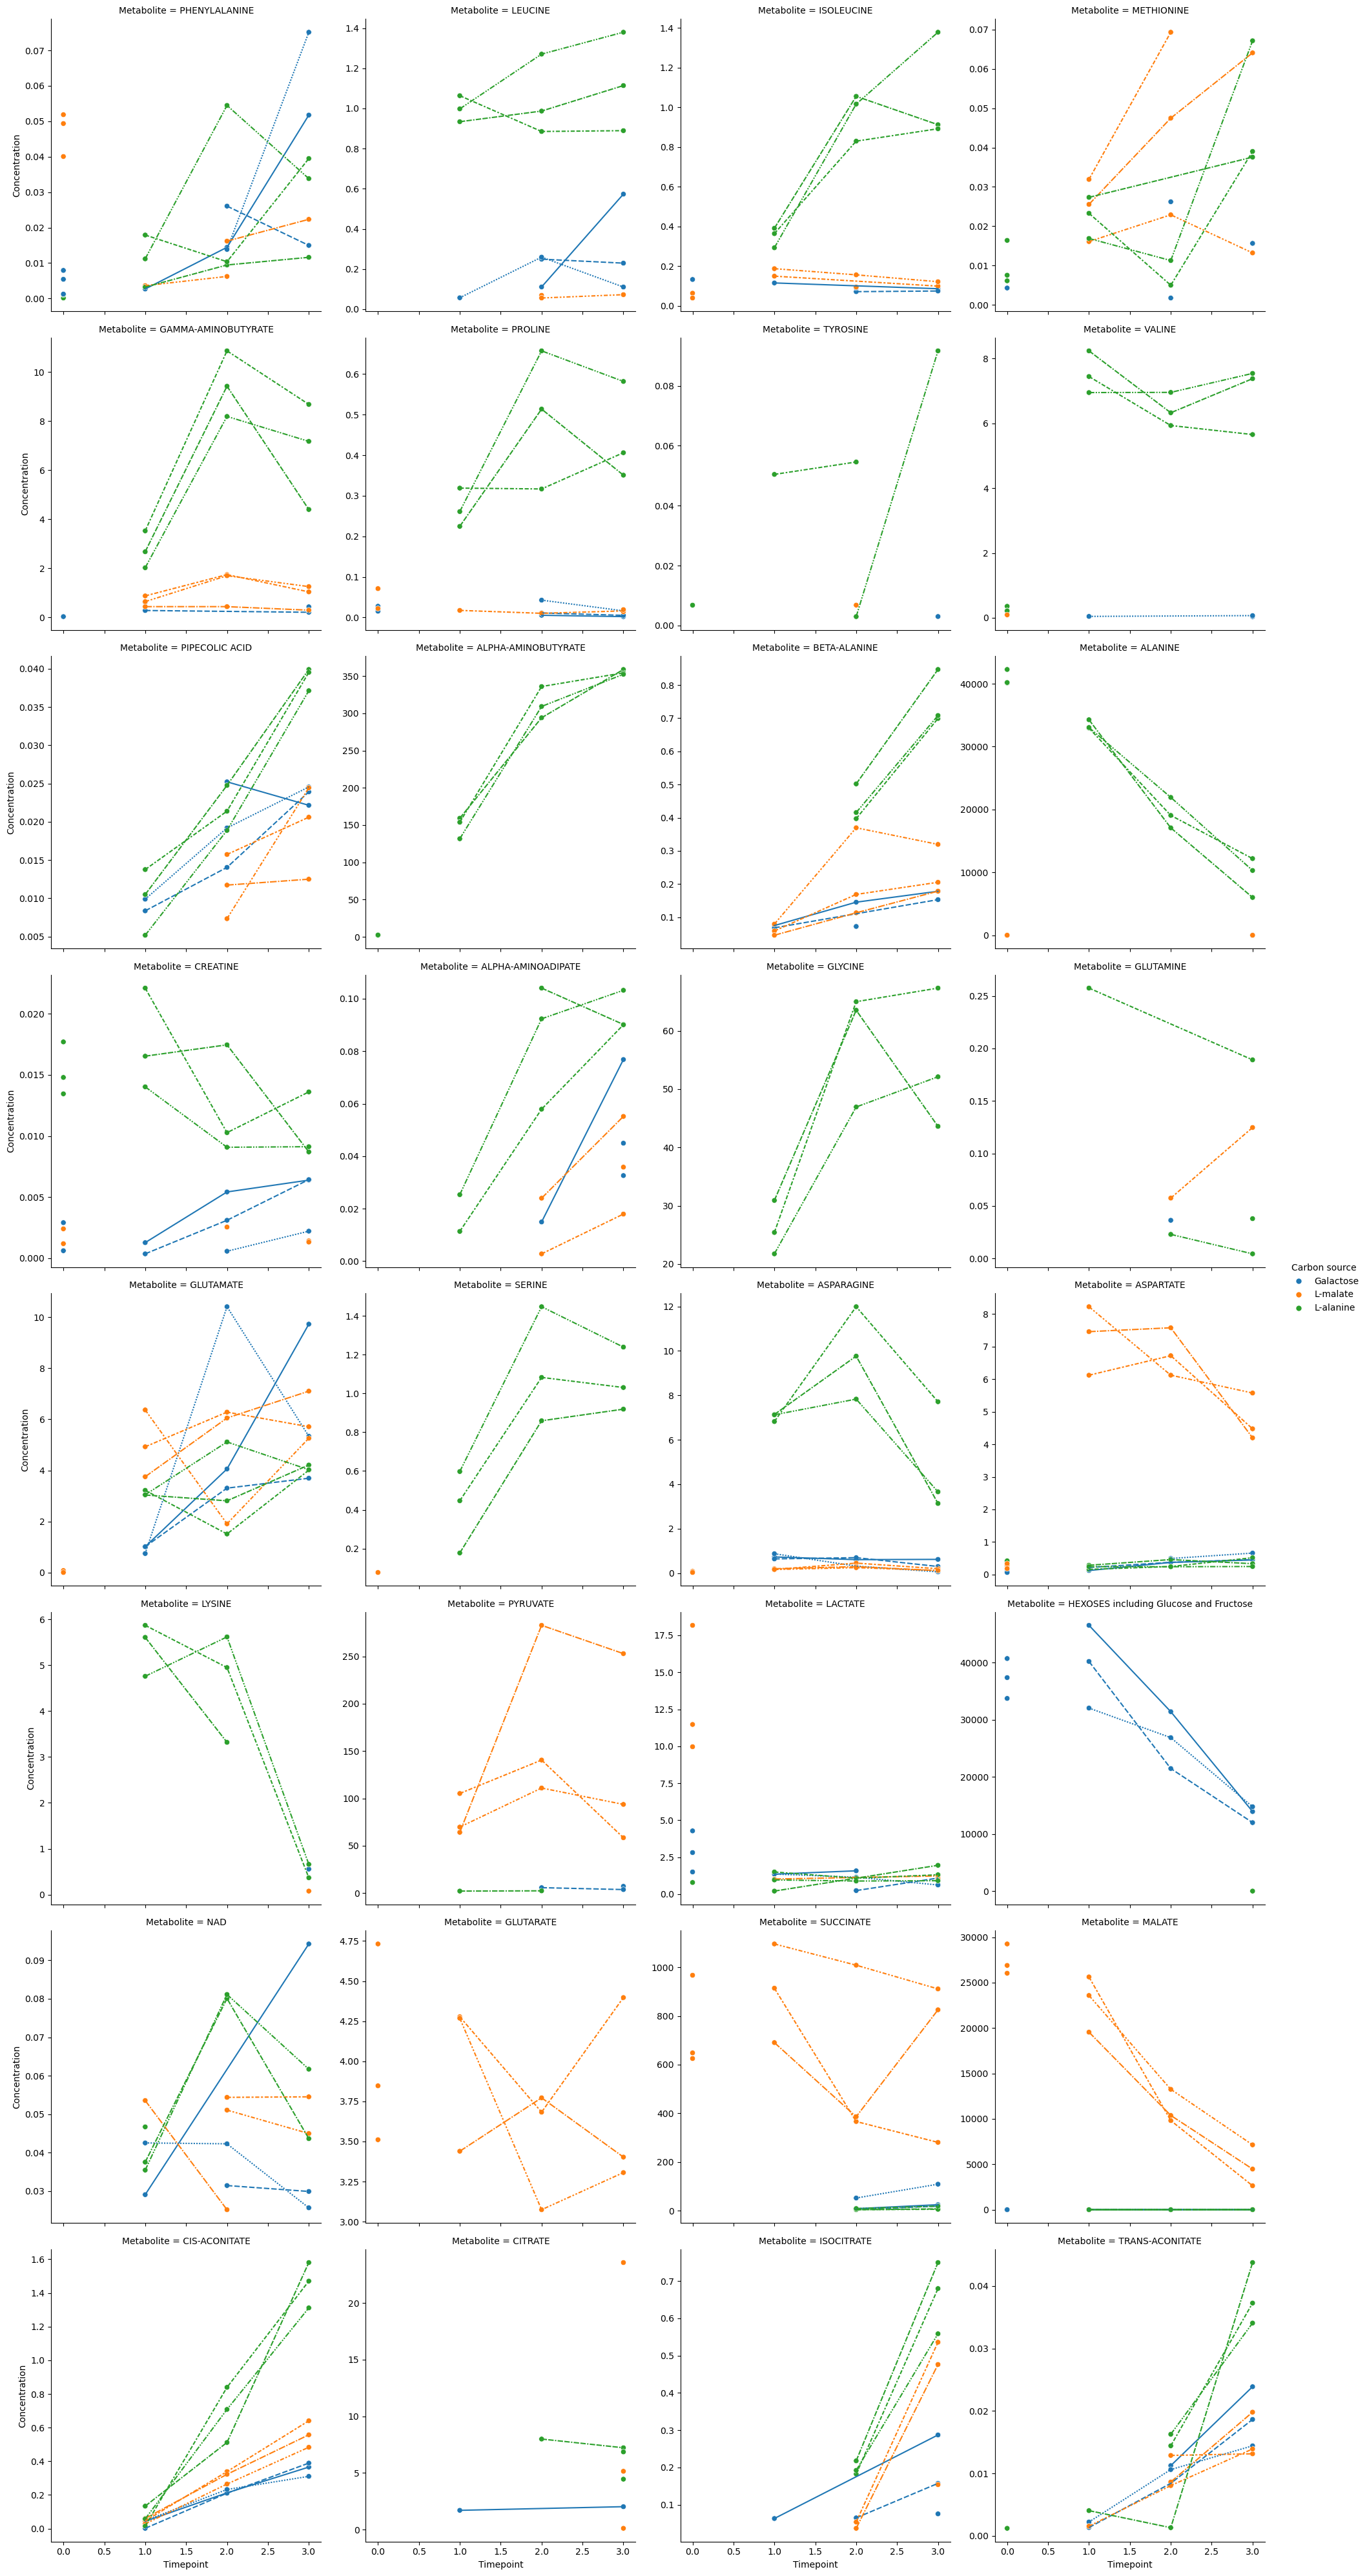

In [29]:
ax = sns.relplot(data = dfl.loc[dfl.Timepoint != 4,:], x = 'Timepoint', y = 'Concentration', hue = 'Carbon source', col = 'Metabolite', col_wrap=4, facet_kws={'sharey': False})
ax.map_dataframe(sns.lineplot, 'Timepoint', 'Concentration', hue = 'Carbon source', style = 'M')
plt.show()

# Estimate rate per bioreactor


M1 Galactose PHENYLALANINE 1.2315561786032251e-05 3.4148980347953656e-06 0.27728317182155565


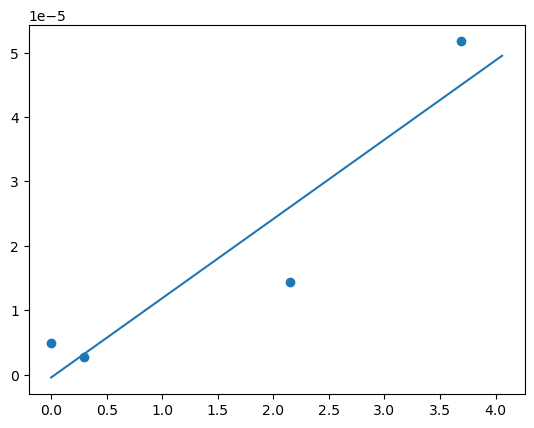

M1 Galactose LEUCINE 0.0001488499191403311 6.905320148700502e-05 0.463911582121209


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


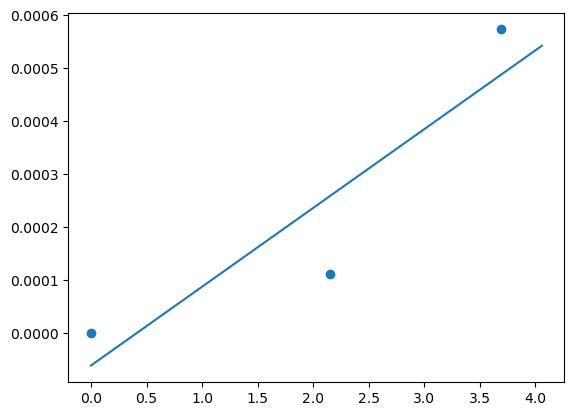

M1 Galactose ISOLEUCINE -1.0952734804795747e-05 3.4842175253397974e-06 0.31811393112651676


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


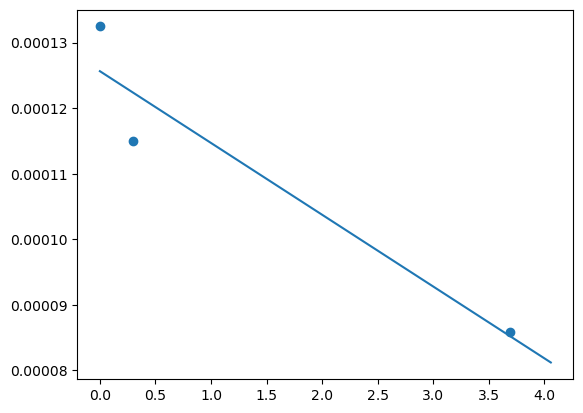

M1 Galactose METHIONINE 3.0726607432818306e-06 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


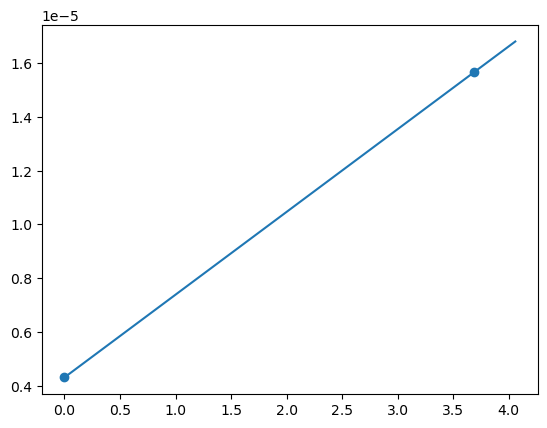

M1 Galactose GAMMA-AMINOBUTYRATE 0.001950981498367631 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


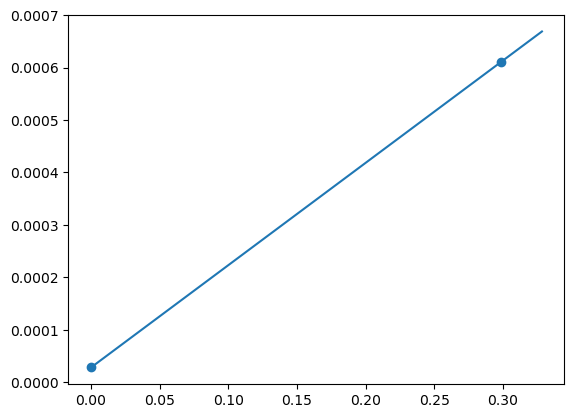

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose PROLINE -6.670306930713443e-06 inf inf


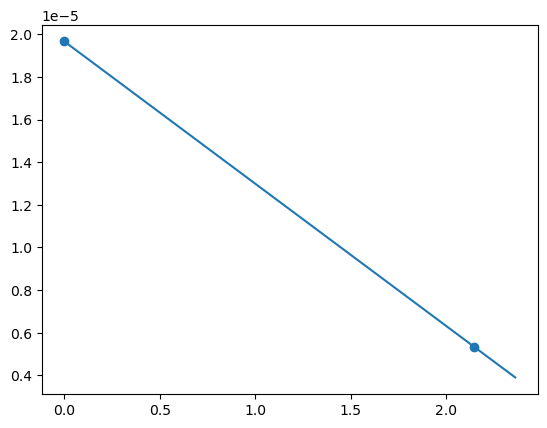

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose VALINE 1.0038756682992082e-05 inf inf


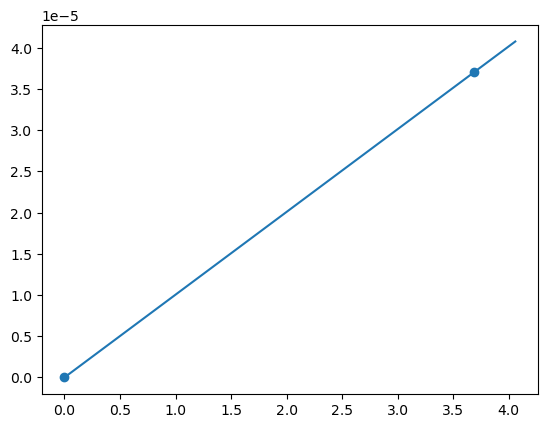

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose PIPECOLIC ACID 1.1750295234262228e-05 inf inf


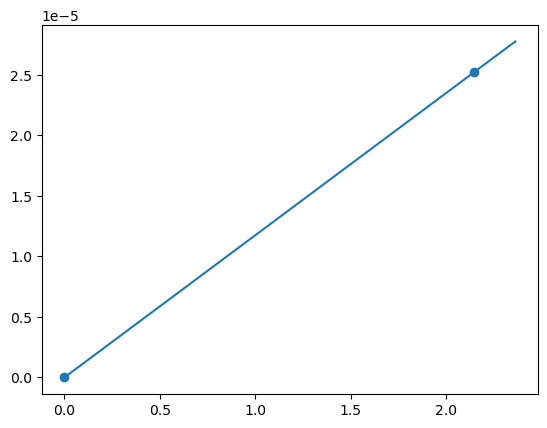

M1 Galactose BETA-ALANINE 4.279138074574256e-05 1.1855489490438804e-05 0.2770532122083567


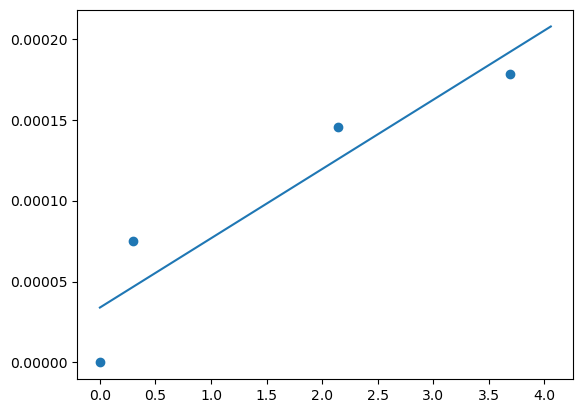

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose ALANINE -0.0005046700957883909 inf inf


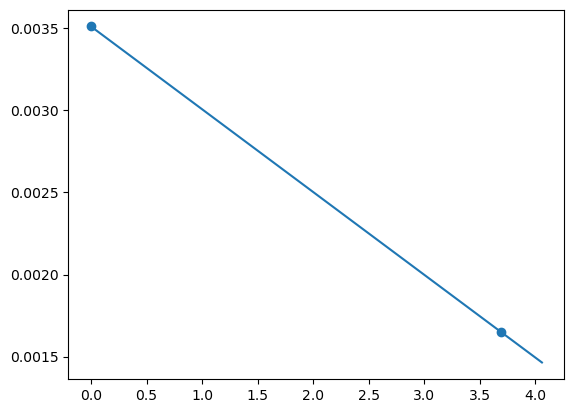

M1 Galactose CREATINE 1.4396009653585384e-06 2.768462710315907e-07 0.19230764475254503


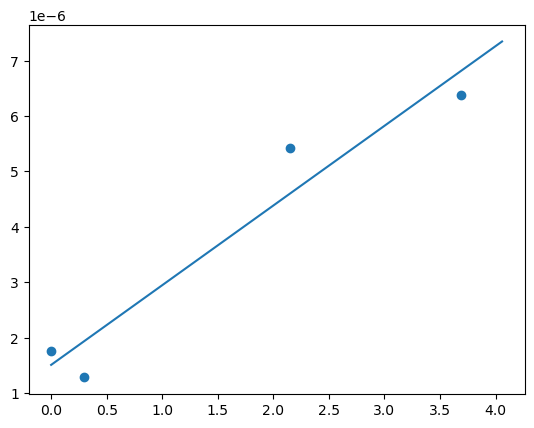

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose ALPHA-AMINOADIPATE 1.9951408447375114e-05 9.235148637057837e-06 0.46288203970245767


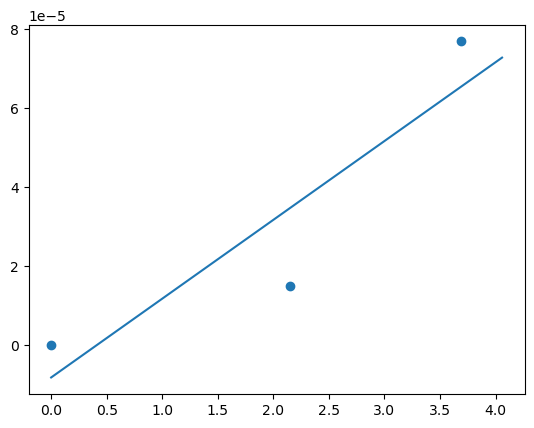

M1 Galactose GLUTAMATE 0.0024945444102328638 0.0003322619113163365 0.13319542837295895


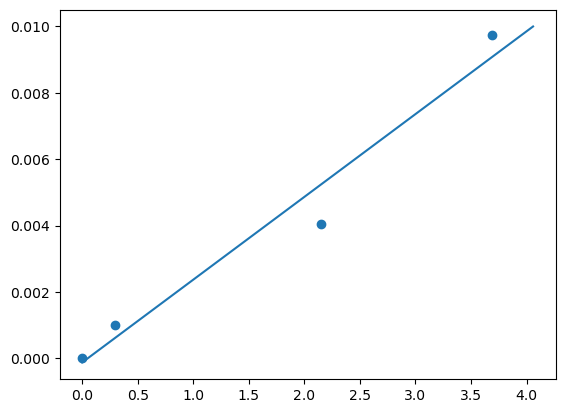

M1 Galactose ASPARAGINE nan nan nan


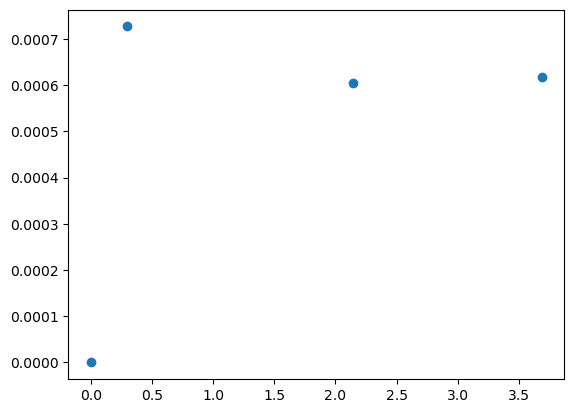

M1 Galactose ASPARTATE 0.00010132233738135021 1.4668033157555407e-05 0.14476603616386038


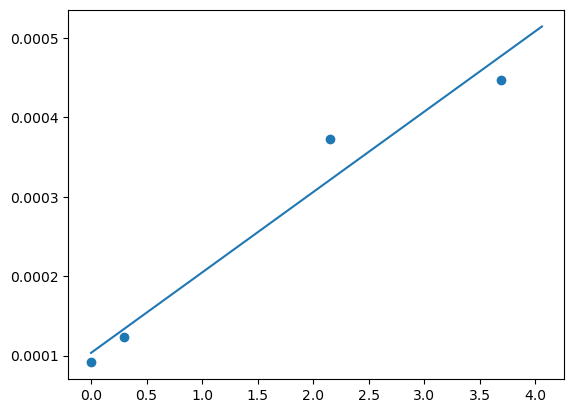

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose PYRUVATE 0.0019269852811640016 inf inf


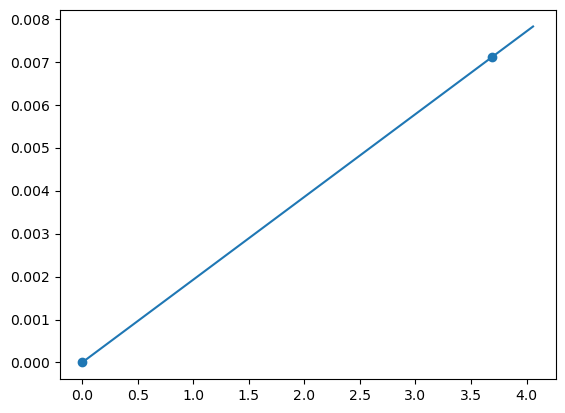

M1 Galactose LACTATE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


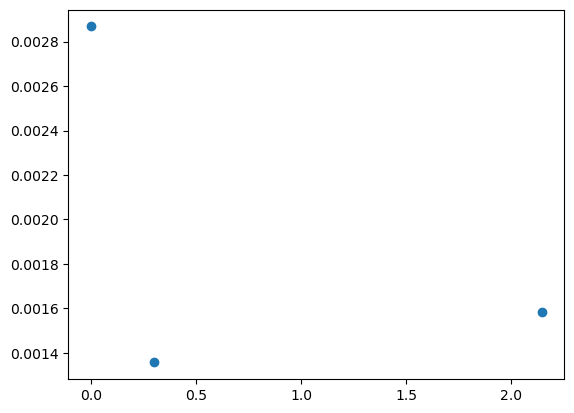

M1 Galactose HEXOSES including Glucose and Fructose -4.65059461695993 4.610324708818367 0.9913409119782864


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


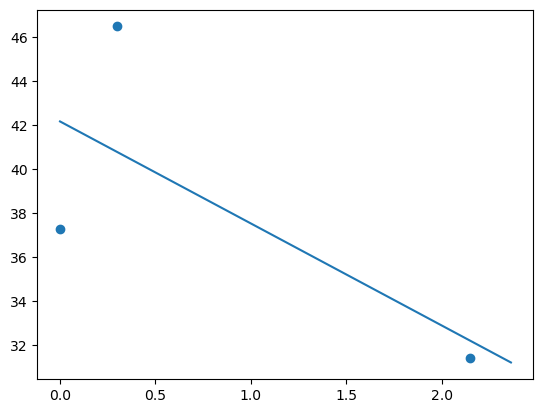

M1 Galactose NAD 2.2916067515776287e-05 5.439484865186886e-06 0.23736554543846317


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


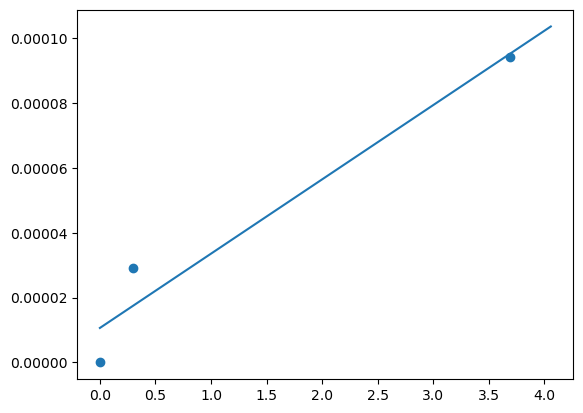

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose SUCCINATE 0.00638158985088221 0.0019154511079265979 0.3001526504655889


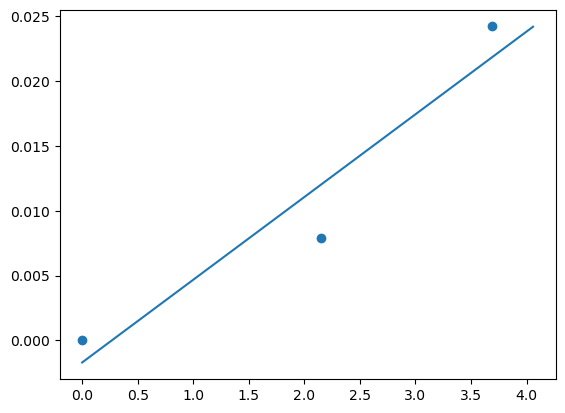

M1 Galactose MALATE 0.004951602541175958 0.0007152895150136577 0.14445616526478788


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


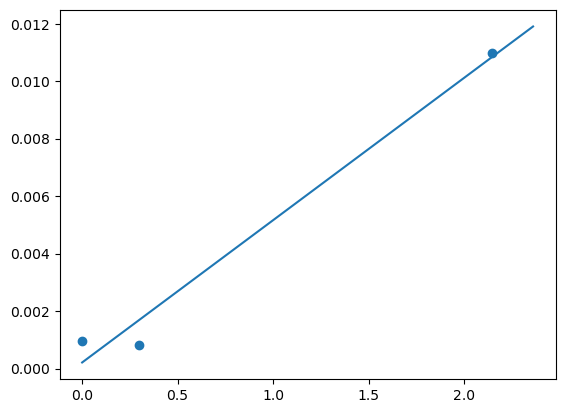

M1 Galactose CIS-ACONITATE 9.715583887714668e-05 2.5358873308512827e-06 0.026101234471948783


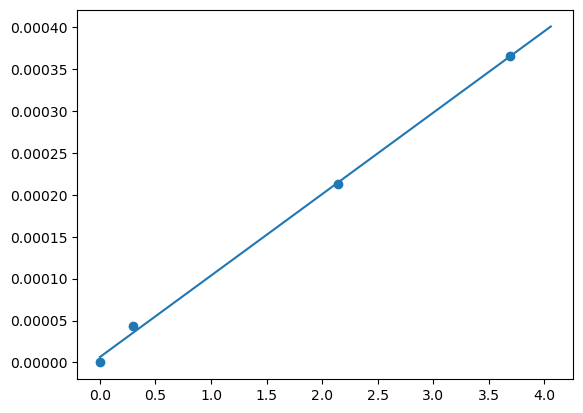

M1 Galactose CITRATE 0.00035917588017814786 0.00038905359850986563 1.0831840888561302


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


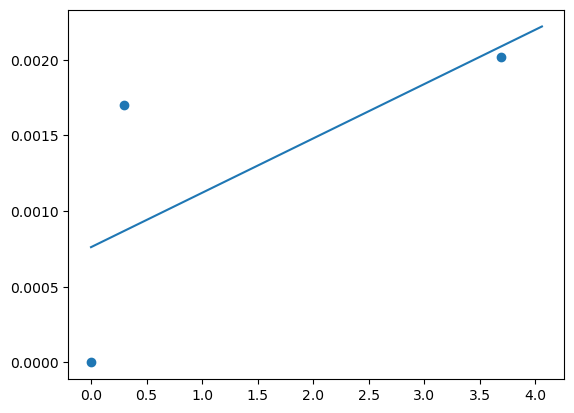

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose ISOCITRATE 7.293143241835718e-05 1.0063651082966141e-05 0.1379878435026195


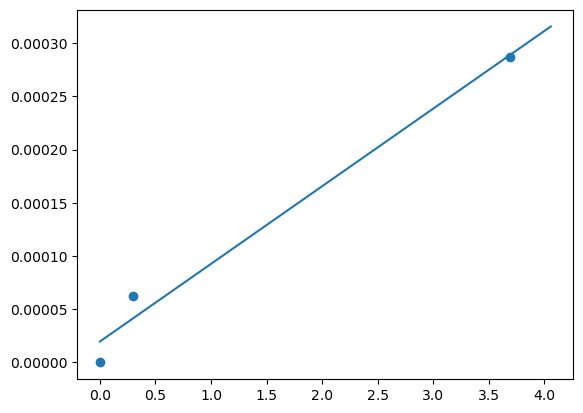

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M1 Galactose TRANS-ACONITATE 6.398431023983556e-06 8.198861084279873e-07 0.12813861794473794


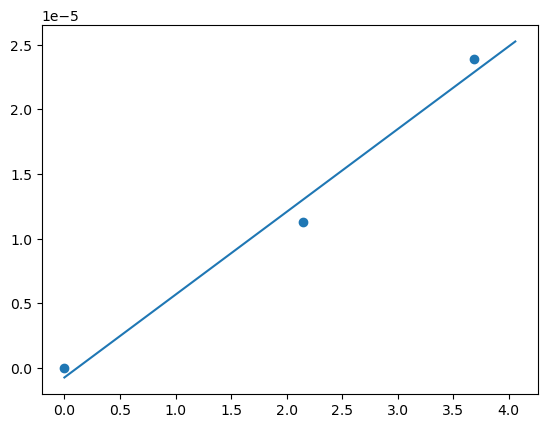

M2 Galactose PHENYLALANINE 1.0199373526461836e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


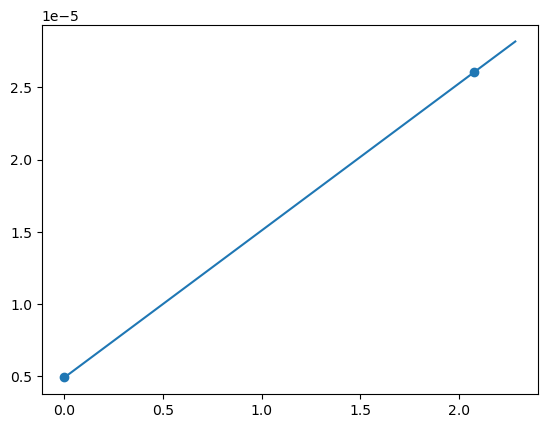

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose LEUCINE 0.00011992447818062472 inf inf


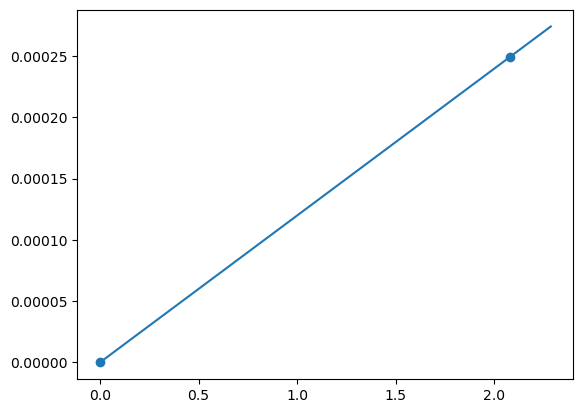

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose ISOLEUCINE nan nan nan


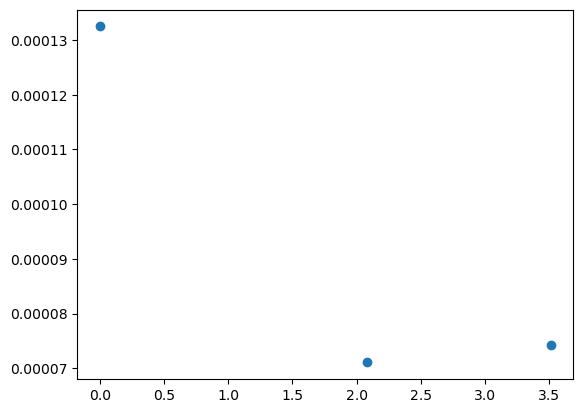

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose METHIONINE -1.2220031487296197e-06 inf inf


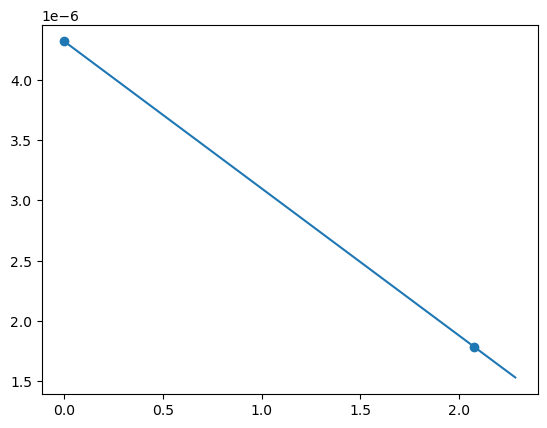

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose GAMMA-AMINOBUTYRATE nan nan nan


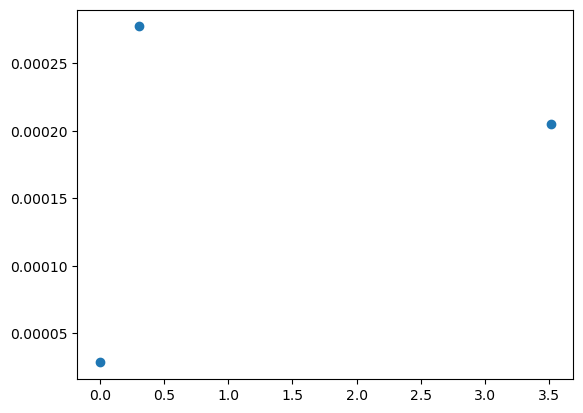

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose PROLINE -4.114485350031394e-06 inf inf


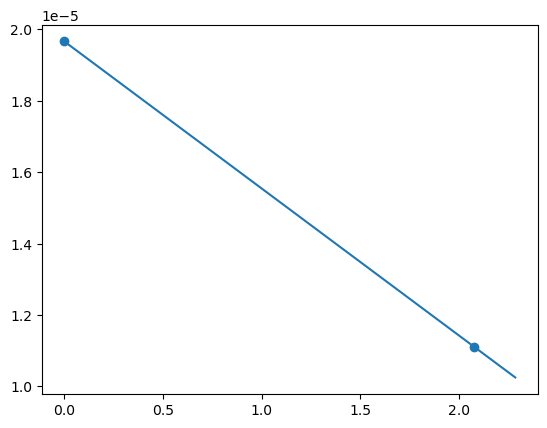

M2 Galactose PIPECOLIC ACID 5.884992473095225e-06 1.2018947560817538e-06 0.20423046615208576


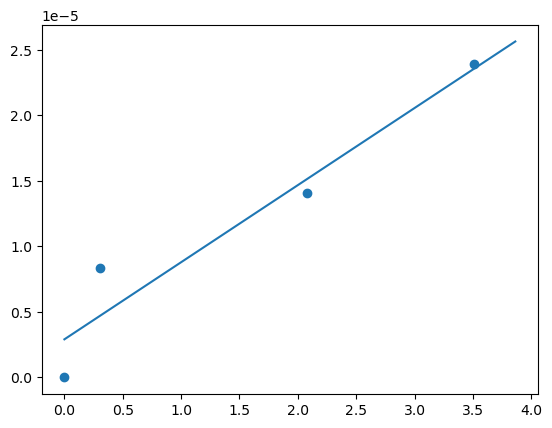

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose BETA-ALANINE 3.652617419382823e-05 1.4666157670415583e-05 0.40152460513901017


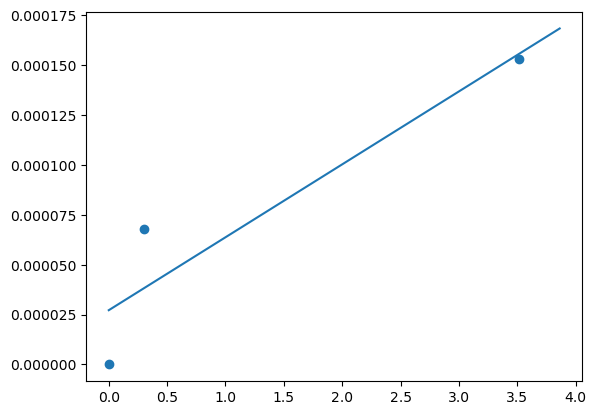

M2 Galactose CREATINE 1.4840033691641731e-06 3.9183081073106054e-07 0.264036335006267


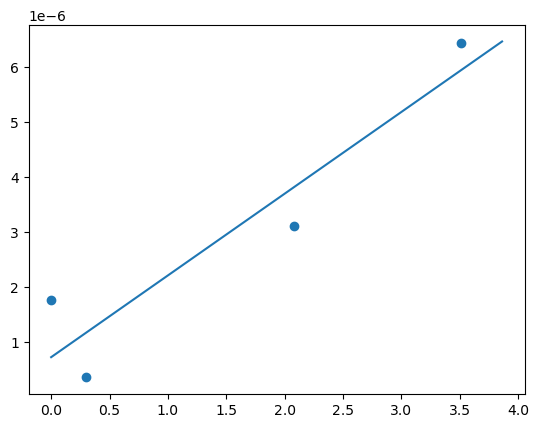

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose ALPHA-AMINOADIPATE 9.285030879297793e-06 inf inf


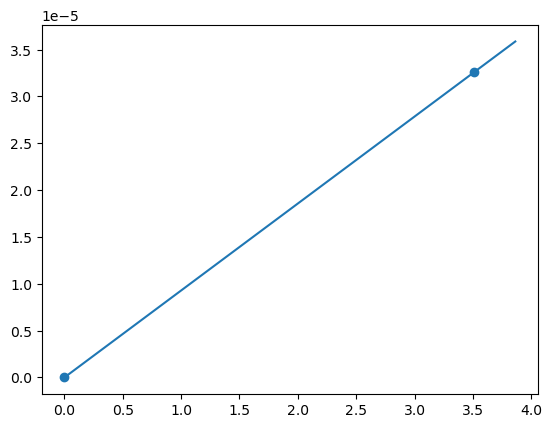

M2 Galactose GLUTAMATE 0.0010351516647688634 0.00023816984229298437 0.23008207434624062


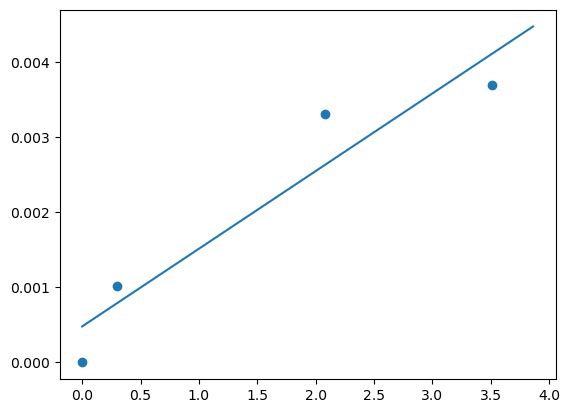

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose ASPARAGINE 0.00022912229158140912 0.00025574315838970533 1.1161862803682618


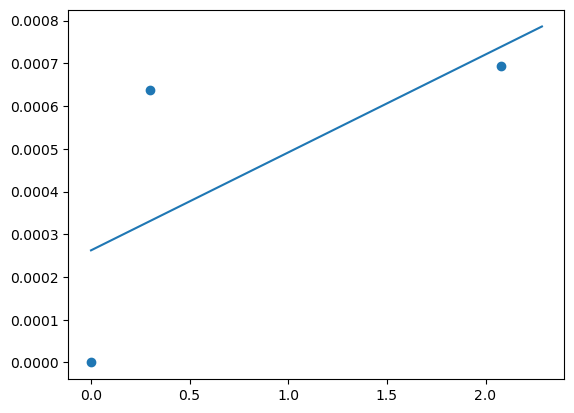

M2 Galactose ASPARTATE 9.564023593805544e-05 1.965707369361397e-05 0.20553142200888677


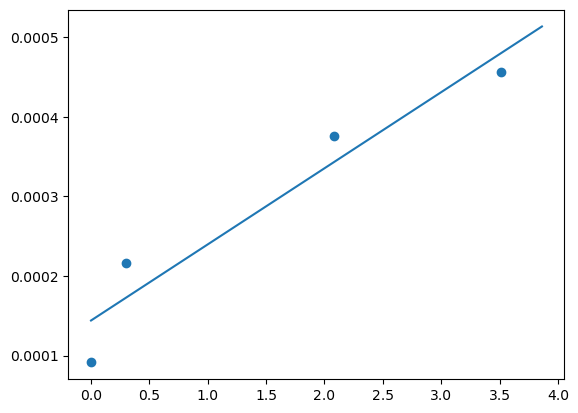

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose PYRUVATE 0.0027316919000444973 inf inf


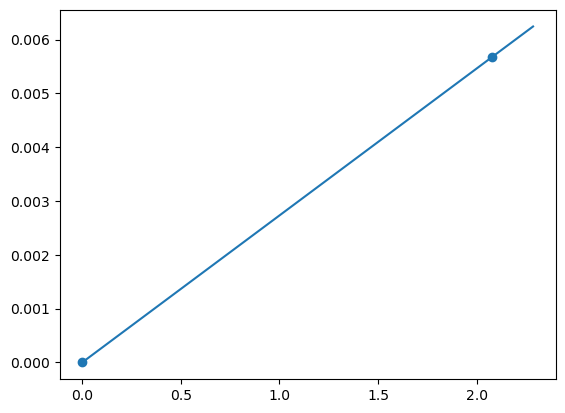

M2 Galactose LACTATE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


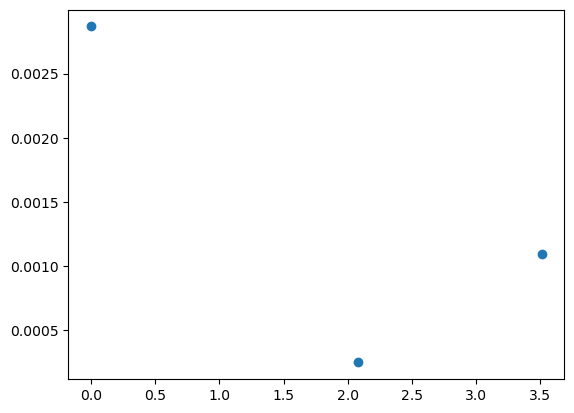

M2 Galactose HEXOSES including Glucose and Fructose -8.62346972250237 2.484169590212376 0.28807077315179763


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


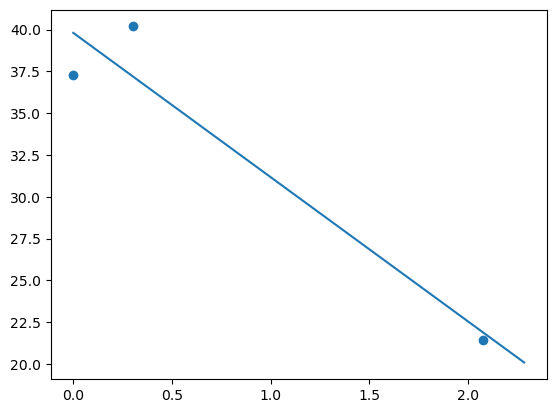

M2 Galactose NAD 1.5130334578750135e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


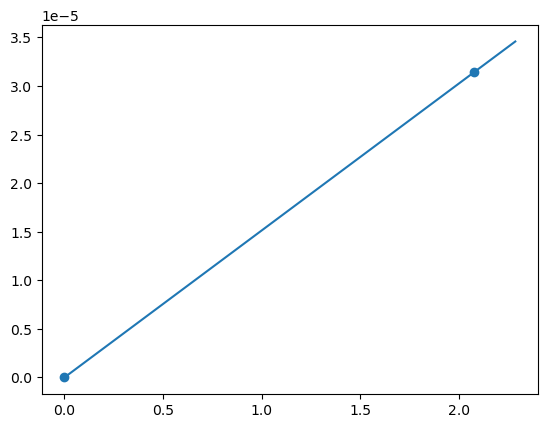

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose SUCCINATE 0.004997846307229557 0.002088367093360402 0.41785340424324513


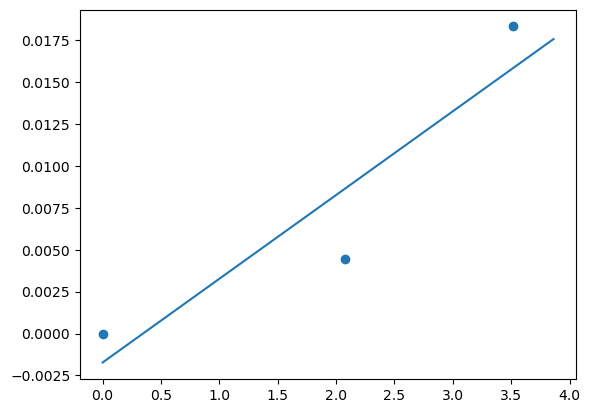

M2 Galactose MALATE 0.0017091090598860316 0.0003790155985888614 0.2217620908370442


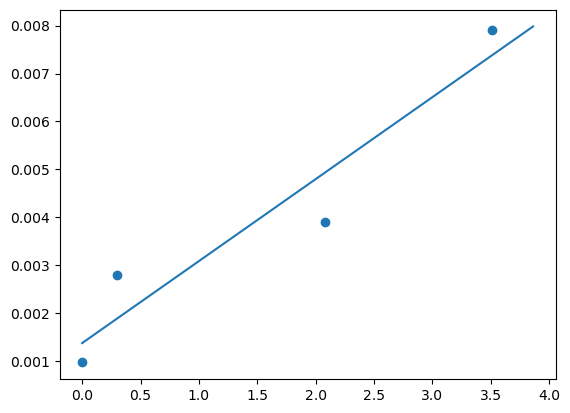

M2 Galactose CIS-ACONITATE 0.00011393929237812382 6.349070708474049e-06 0.05572327663229424


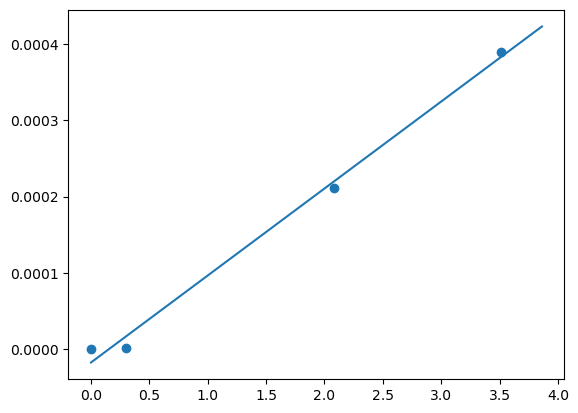

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M2 Galactose ISOCITRATE 4.377543344265966e-05 9.221078973737547e-06 0.2106450638762037


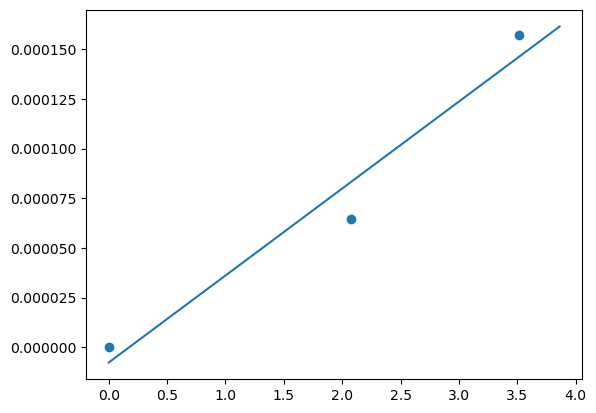

M2 Galactose TRANS-ACONITATE 5.151247542353701e-06 5.366423291164174e-07 0.10417715799990762


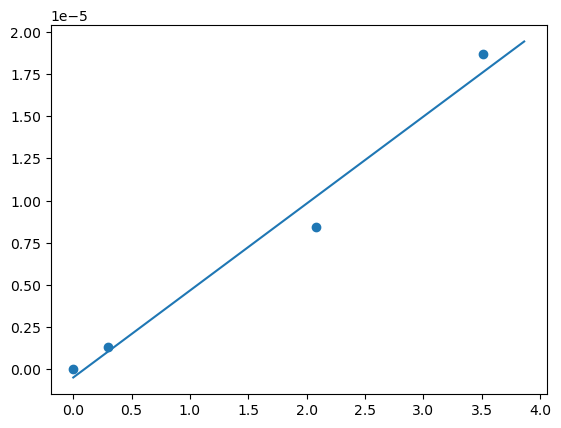

M3 Galactose PHENYLALANINE 1.8762609647335e-05 1.1957980143277193e-05 0.6373303270729016


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


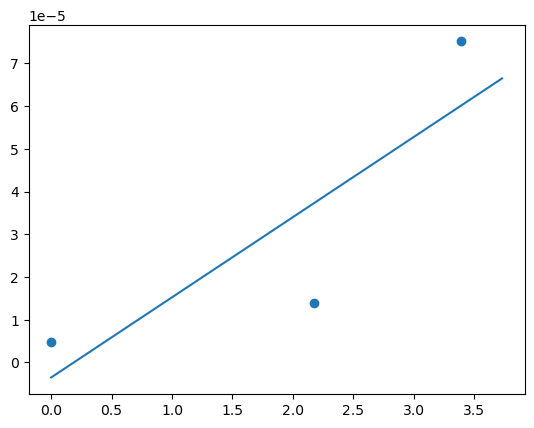

M3 Galactose LEUCINE 0.00011806088848540084 3.471460147060346e-06 0.029403981213385662


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


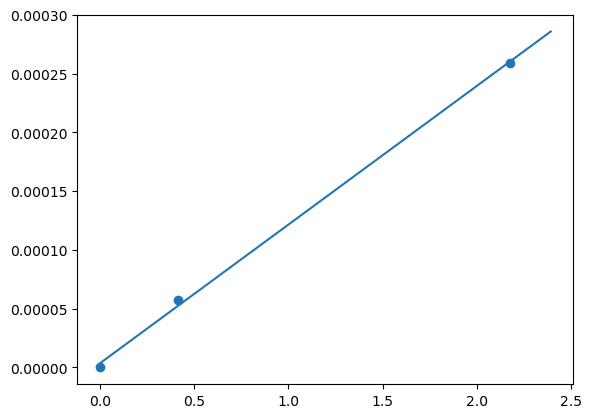

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose ISOLEUCINE -1.9424173007995902e-05 inf inf


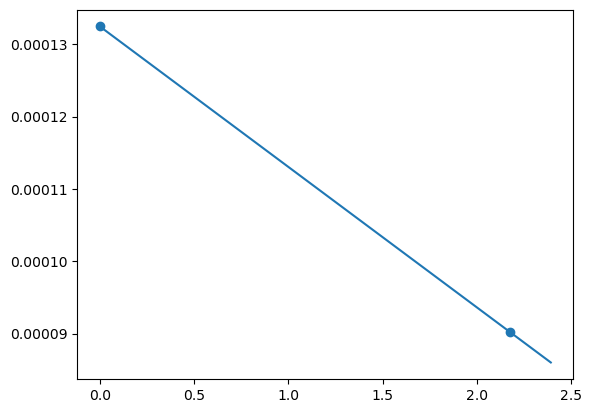

M3 Galactose METHIONINE 1.0073867786358207e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


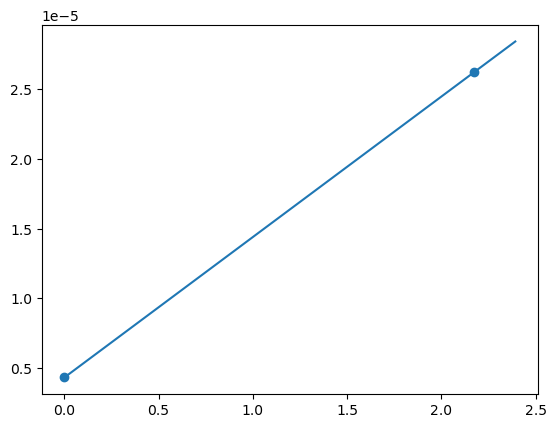

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose GAMMA-AMINOBUTYRATE 0.00011784870161539234 inf inf


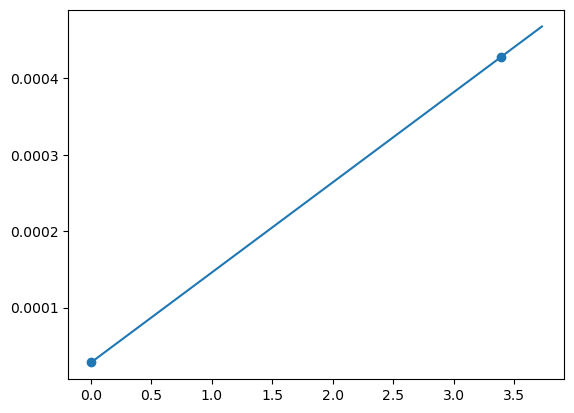

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose PROLINE 1.0575478841193101e-05 inf inf


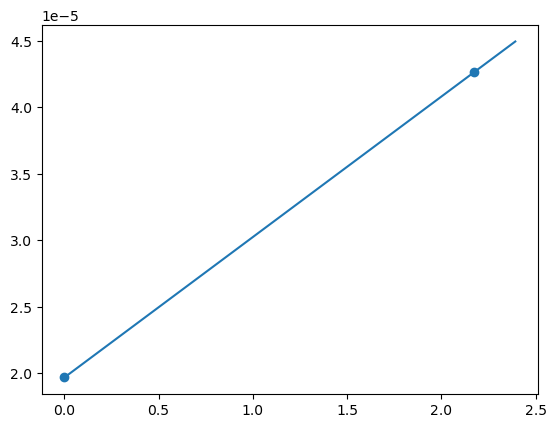

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose TYROSINE 8.901691877151665e-07 inf inf


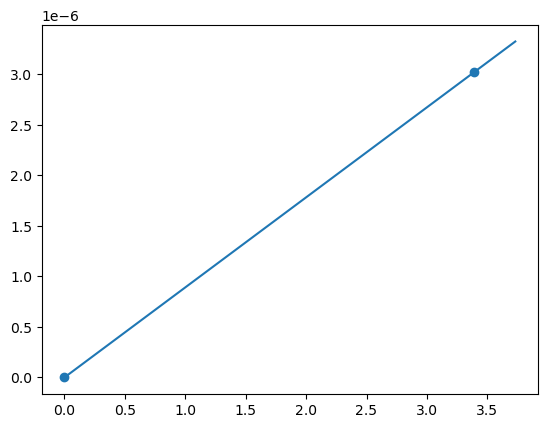

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose VALINE 1.551307948330156e-05 1.0081838287462086e-05 0.649892775854999


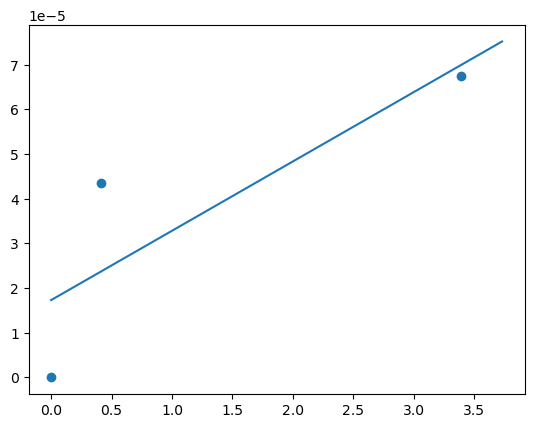

M3 Galactose PIPECOLIC ACID 6.559991786861869e-06 1.3960447847747521e-06 0.21281197143732766


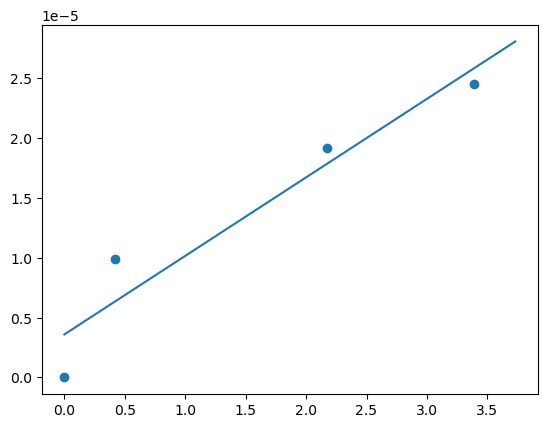

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose BETA-ALANINE 3.316007491729498e-05 inf inf


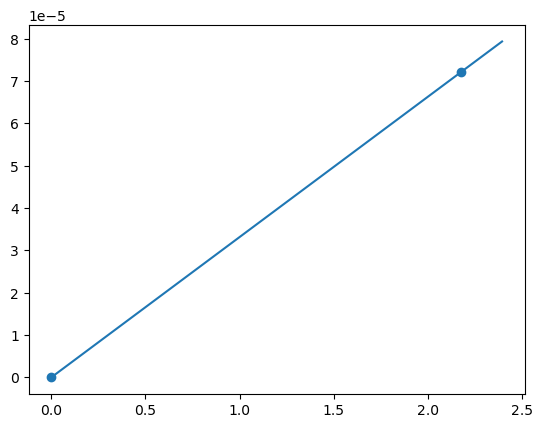

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose ALANINE -0.0006857539612952402 inf inf


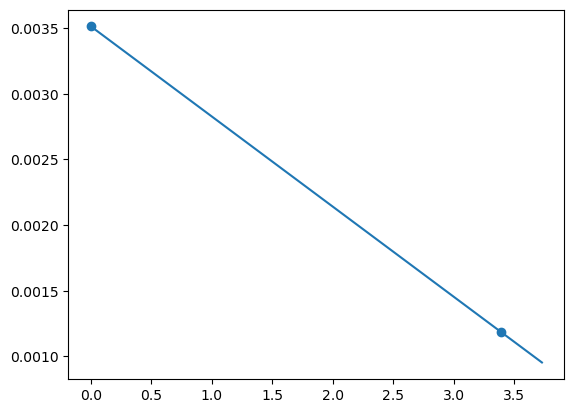

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose CREATINE 5.297187251104676e-08 4.902960548699274e-07 9.255781070749972


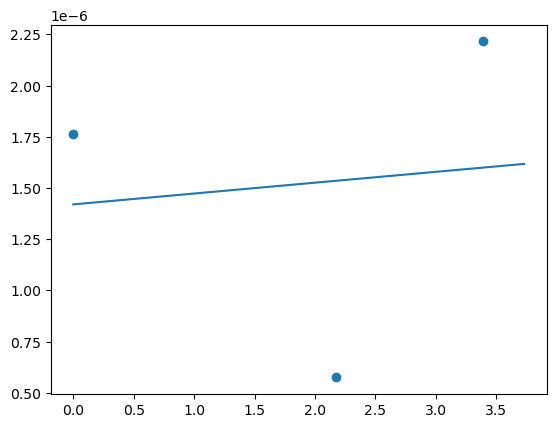

M3 Galactose ALPHA-AMINOADIPATE 1.3253744705371253e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


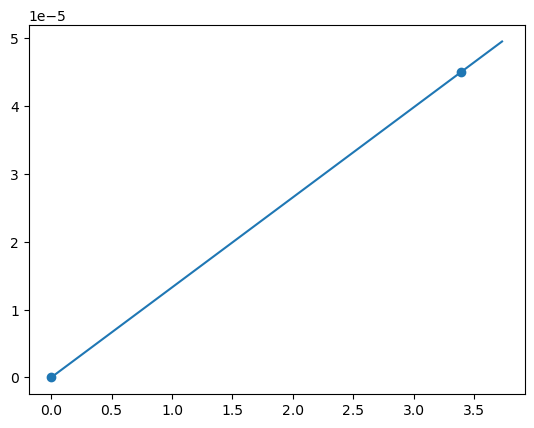

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose GLUTAMINE 1.6705104540987283e-05 inf inf


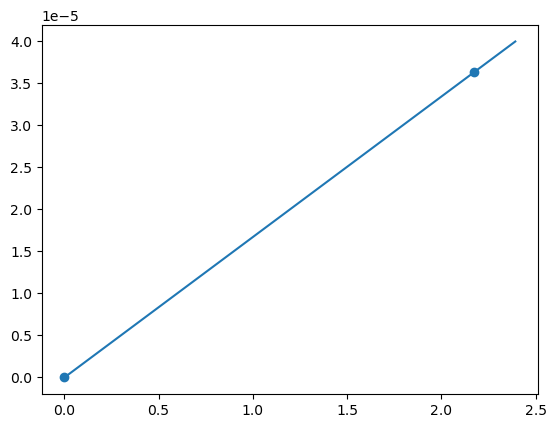

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose GLUTAMATE 0.004996685187694806 0.0005870244856682169 0.11748278380912718


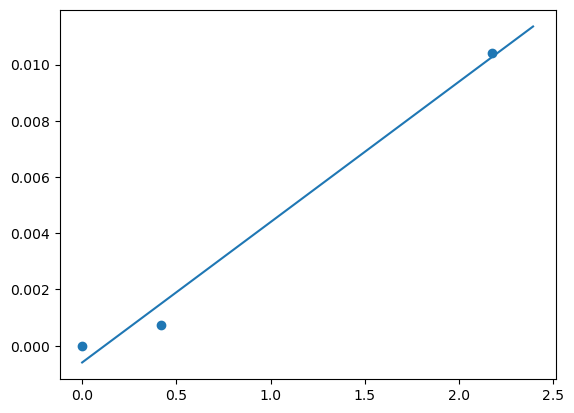

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose ASPARAGINE nan nan nan


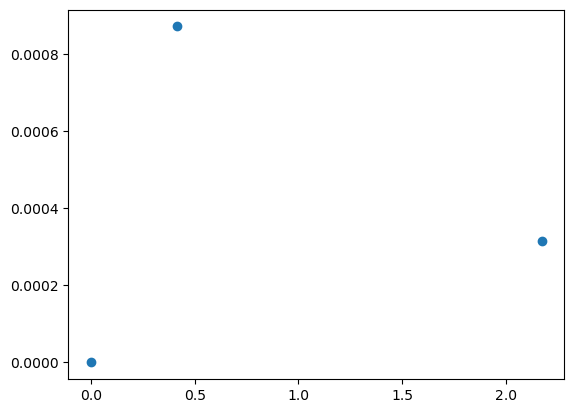

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose ASPARTATE 0.0001693510264669816 1.2396762536930401e-05 0.07320157896620366


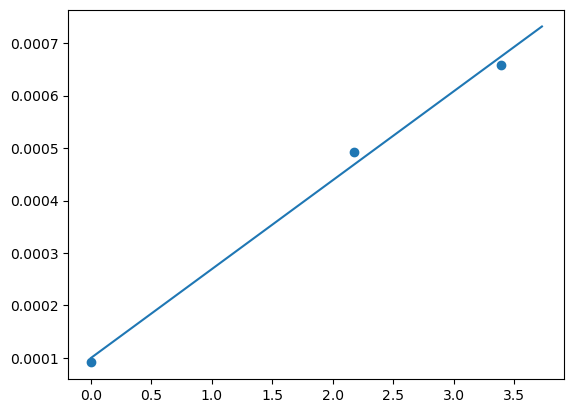

M3 Galactose LYSINE 0.0001638372137058139 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


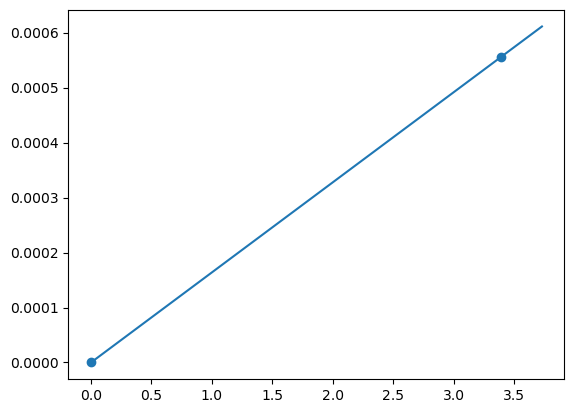

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose LACTATE -0.0005920570704232713 0.0005554987072867061 0.938251960895545


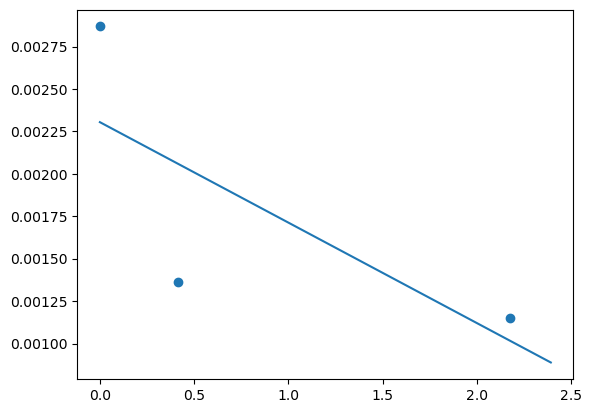

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose HEXOSES including Glucose and Fructose -4.2398931580035635 1.5245350532605988 0.35956921470597997


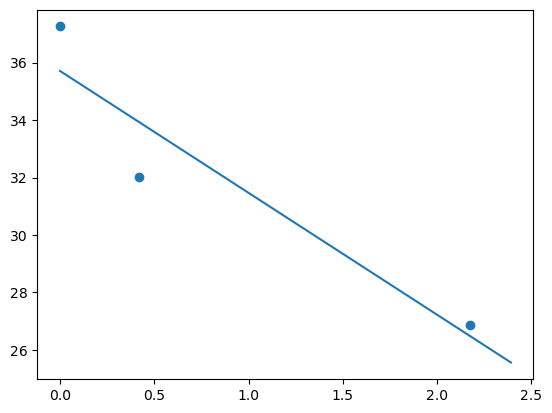

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose NAD nan nan nan


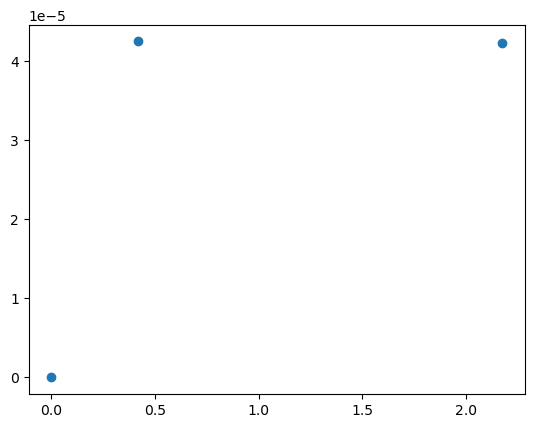

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose SUCCINATE 0.03103491586091463 0.005935757629225374 0.19126063224488604


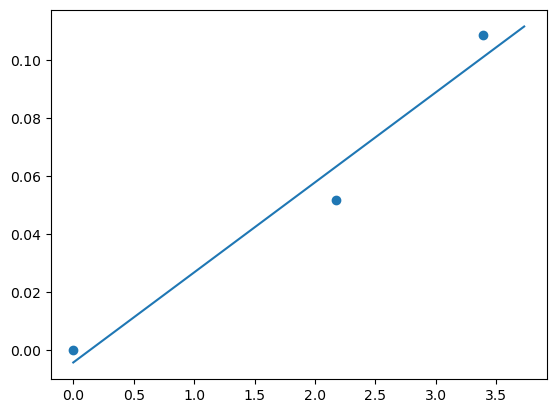

M3 Galactose MALATE -0.0009376162765917862 0.001766217238728692 1.8837314185168068


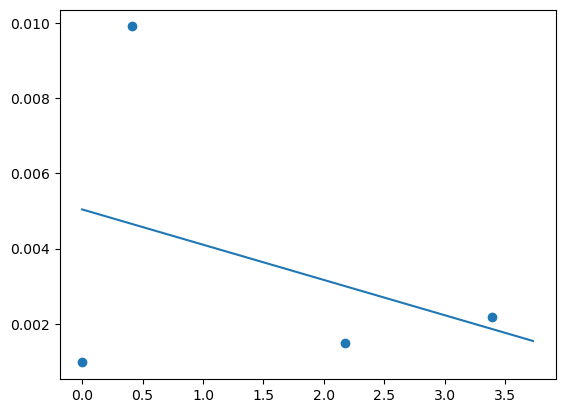

M3 Galactose CIS-ACONITATE 9.32431246814258e-05 6.9679547454650716e-06 0.07472888504403694


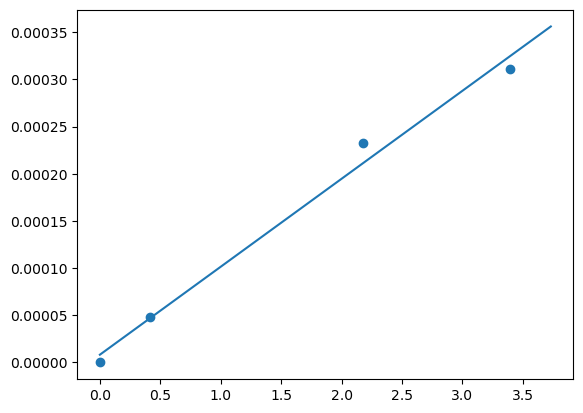

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M3 Galactose ISOCITRATE 2.223464020454447e-05 inf inf


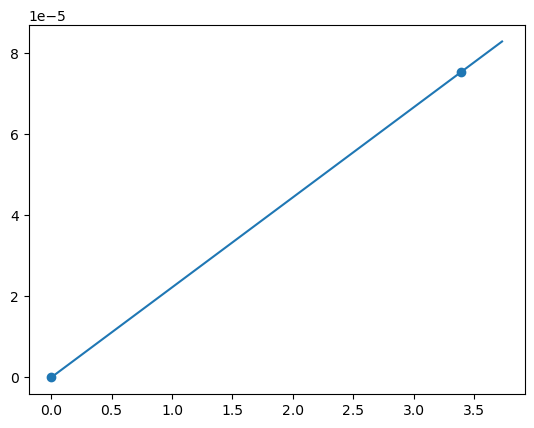

M3 Galactose TRANS-ACONITATE 4.312364060082335e-06 2.8848740537616344e-07 0.06689773900273517


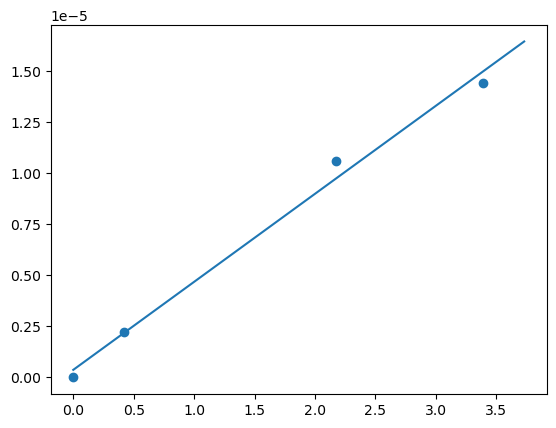

M5 L-malate ISOLEUCINE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


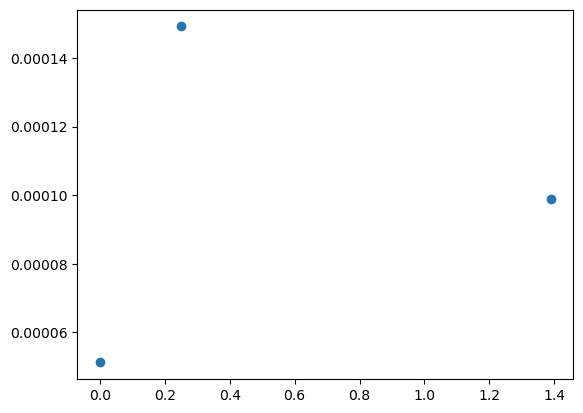

M5 L-malate METHIONINE 6.531412109609924e-05 1.5485777547732287e-05 0.23709692923751438


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


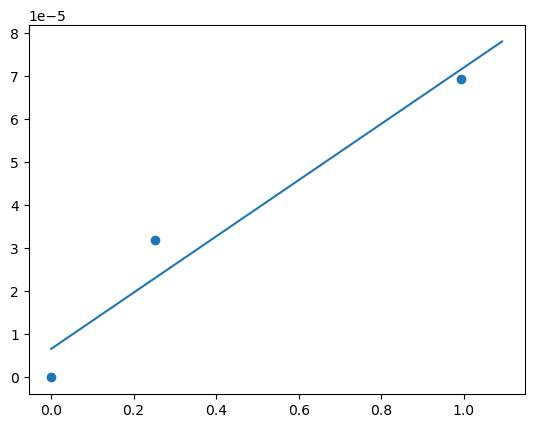

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate GAMMA-AMINOBUTYRATE 0.0016187063069687594 0.000465563573231833 0.2876146038521726


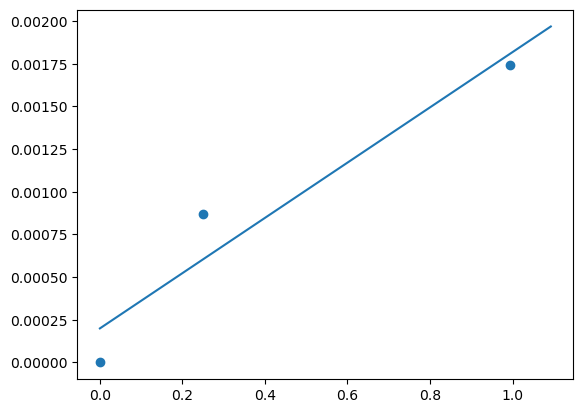

M5 L-malate PROLINE -1.8079333547853048e-05 1.248862193392633e-05 0.6907678261961916


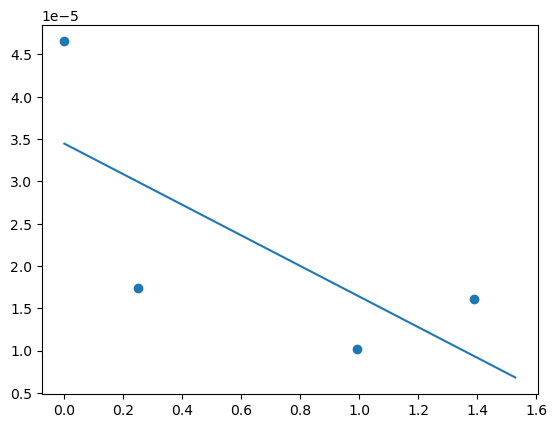

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate TYROSINE 6.868467660596074e-06 inf inf


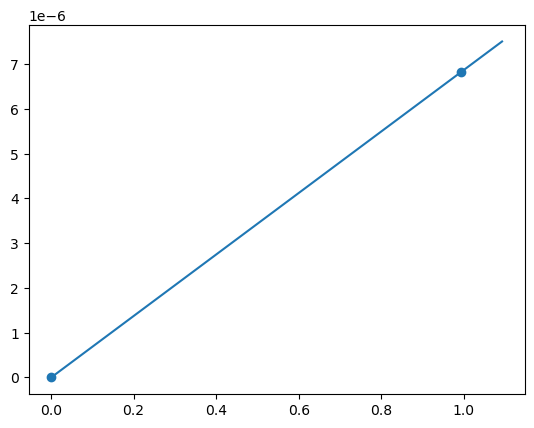

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate PIPECOLIC ACID 1.5023006899133352e-05 7.829754427934035e-07 0.05211842396468391


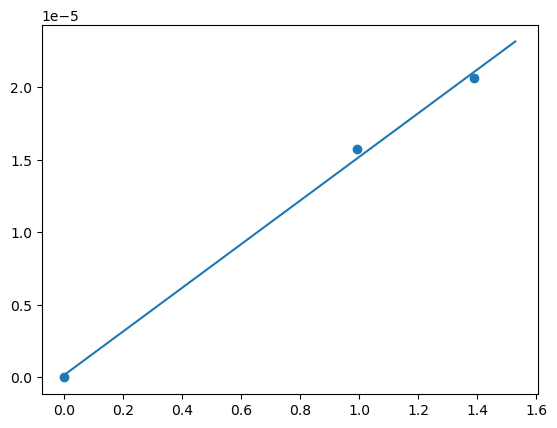

M5 L-malate BETA-ALANINE 0.00014663108880773497 1.3674873958009638e-05 0.09326039975015361


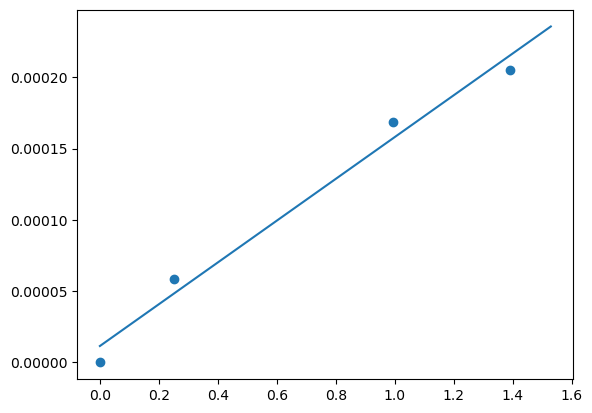

M5 L-malate ALANINE -0.0024966130317736084 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


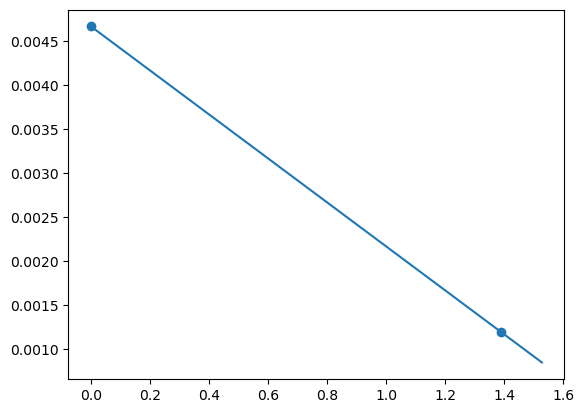

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate CREATINE 7.567969439369165e-07 inf inf


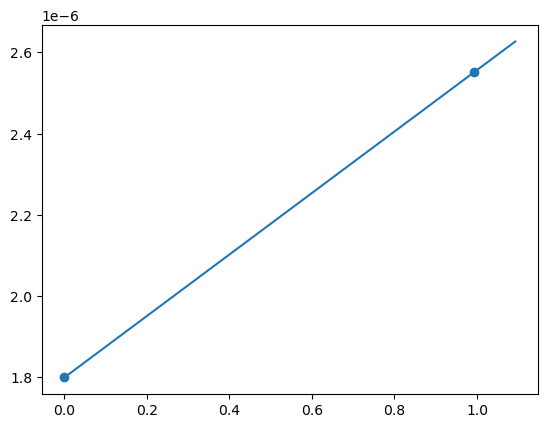

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate ALPHA-AMINOADIPATE 1.0955637263748447e-05 7.864133112810826e-06 0.7178161273039566


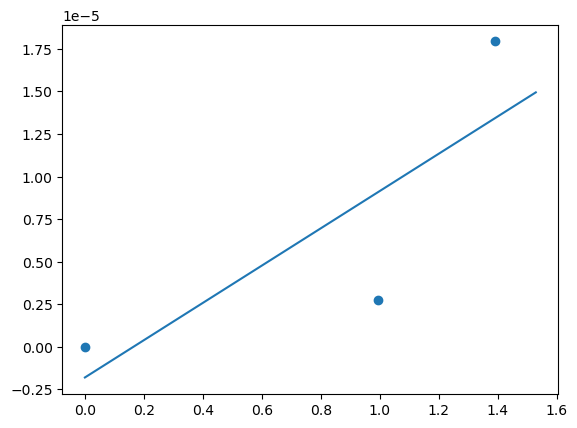

M5 L-malate GLUTAMINE 8.359376121009307e-05 2.4805856908946904e-05 0.29674292135992386


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


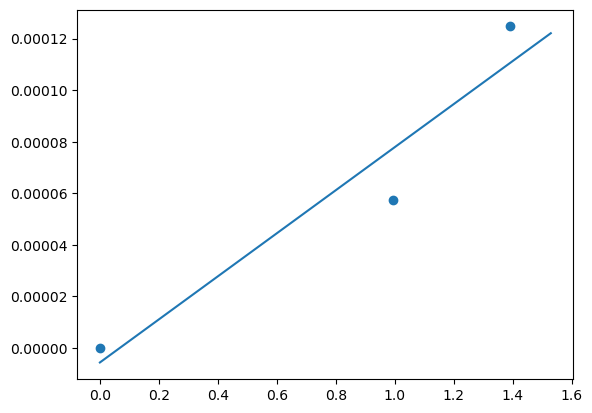

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate GLUTAMATE 0.0052636608753808675 0.0035533810881287556 0.6750778920330122


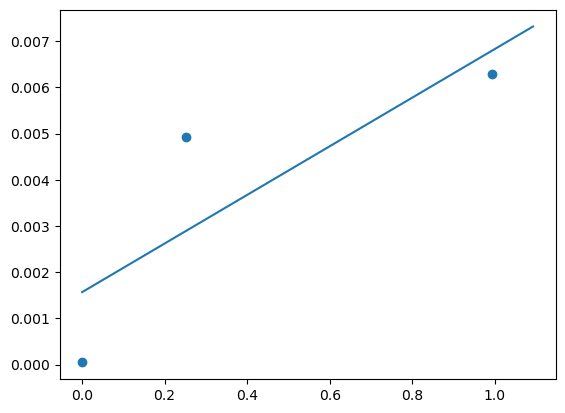

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate ASPARAGINE 0.00039599931083616493 1.2077506781149729e-05 0.03049880757531546


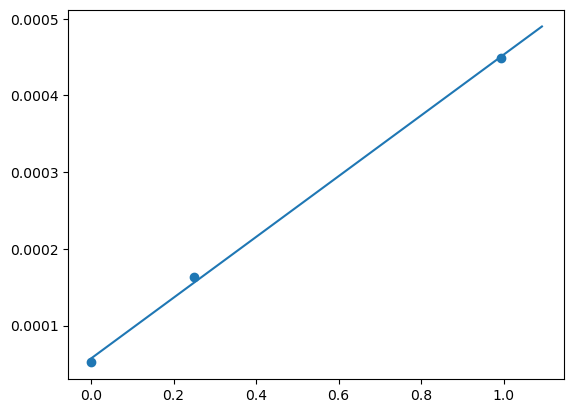

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate ASPARTATE 0.005199377794459895 0.0045404955473425015 0.873276712490588


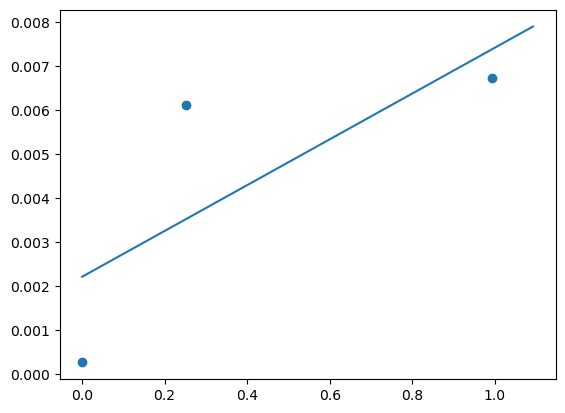

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate LYSINE 5.540233989425954e-05 inf inf


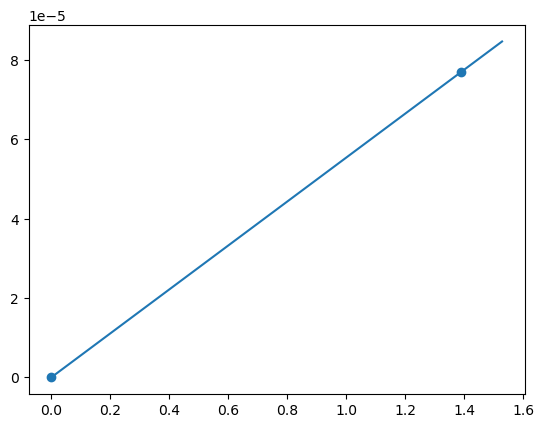

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate PYRUVATE 0.12003472919117775 0.07491886136018704 0.6241432114272923


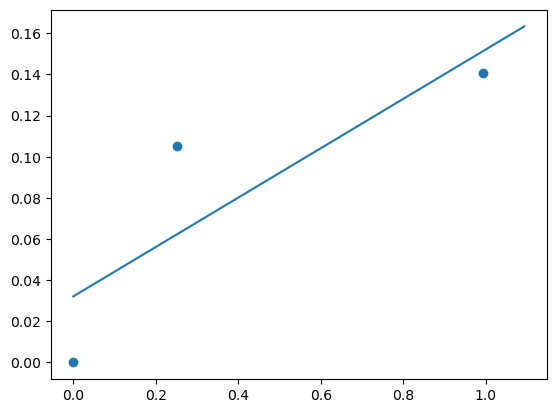

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate LACTATE -0.008698737755477881 inf inf


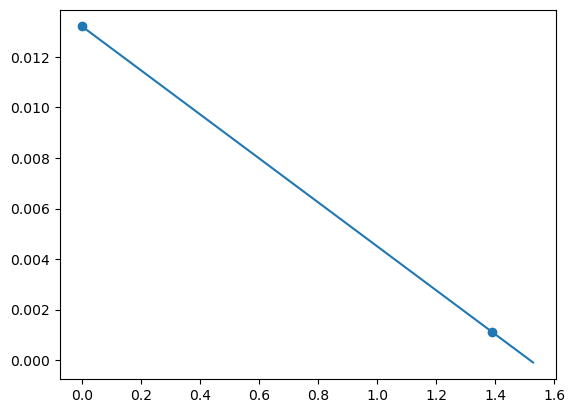

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate NAD 4.2223413855507006e-05 1.2052939376990749e-05 0.285456297262869


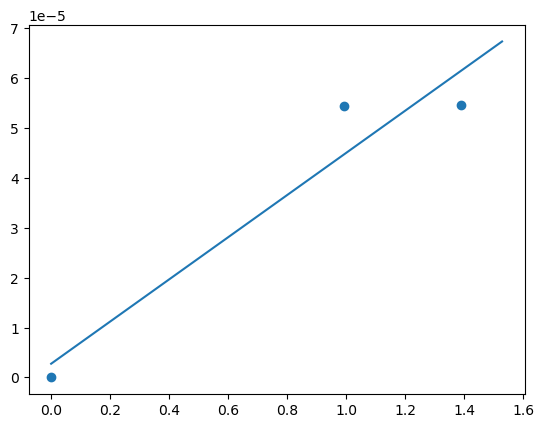

M5 L-malate GLUTARATE nan nan nan


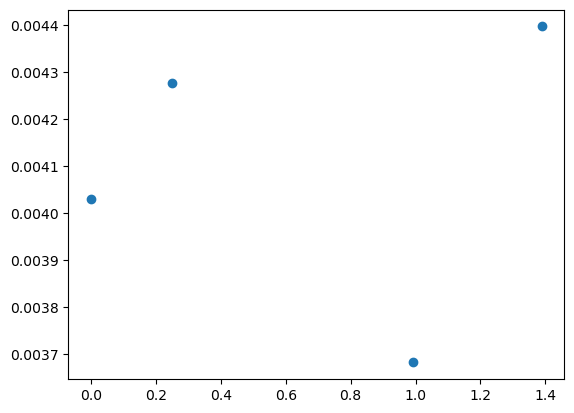

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate SUCCINATE -0.464182319986439 0.28299727315225454 0.6096683586753633


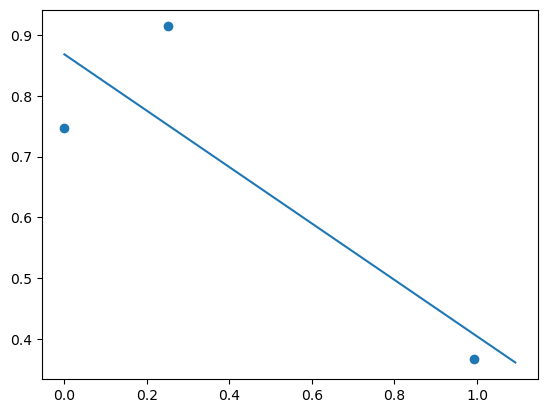

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate MALATE -18.5167494330341 2.8678031199287024 0.15487616389151476


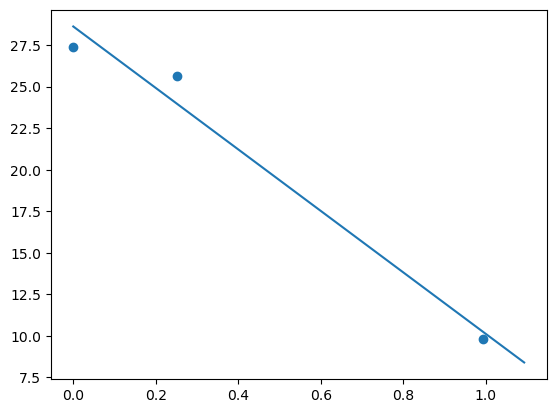

M5 L-malate CIS-ACONITATE 0.00045180848369544513 6.351027576518064e-05 0.1405690199655295


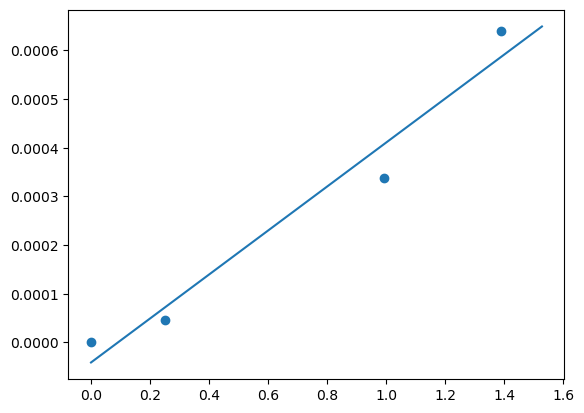

M5 L-malate CITRATE 0.016968095029251933 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


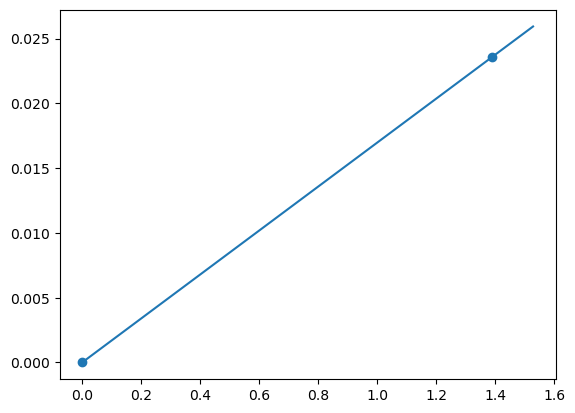

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate ISOCITRATE 0.00032155434378262714 0.0002580229172154469 0.8024239827712359


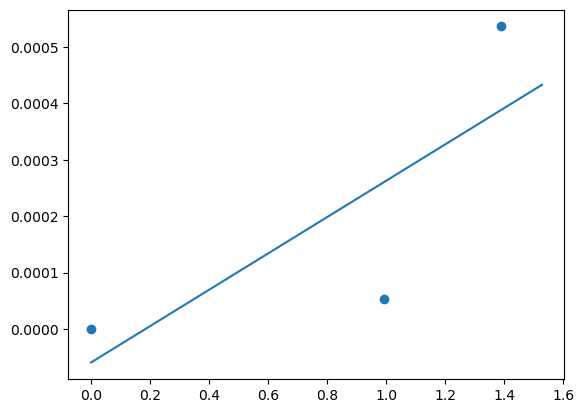

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M5 L-malate TRANS-ACONITATE 1.0144299943158042e-05 2.7295683214238755e-06 0.2690740944883899


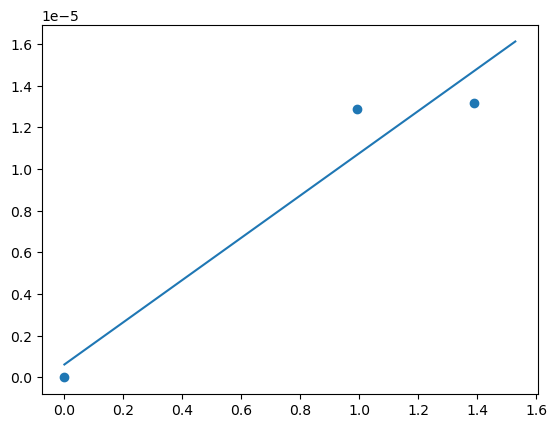

M6 L-malate PHENYLALANINE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


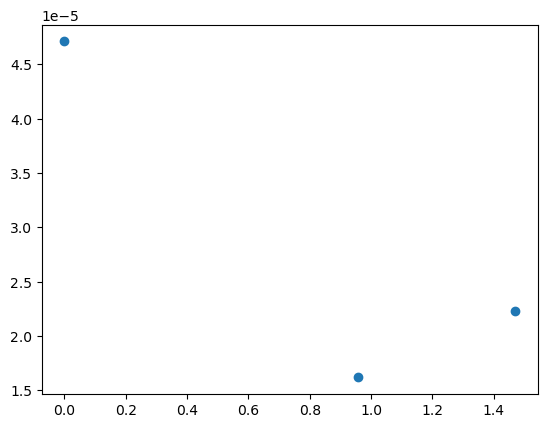

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate LEUCINE 7.221432413633437e-05 inf inf


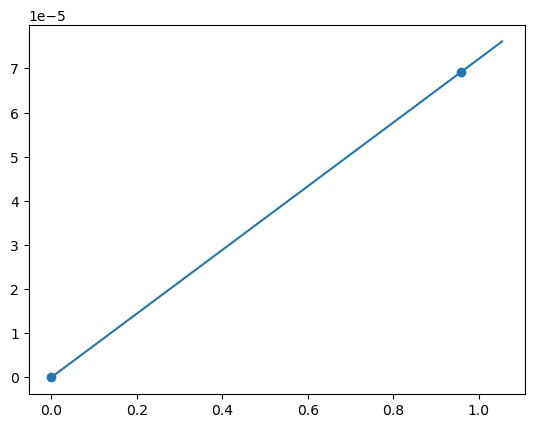

M6 L-malate ISOLEUCINE 4.476141067292168e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


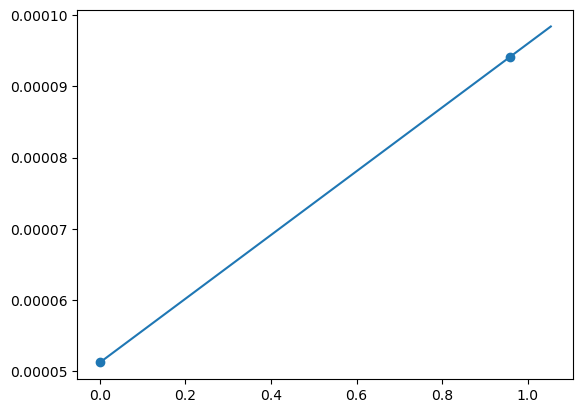

M6 L-malate METHIONINE 3.885877143893093e-05 7.964025512101746e-06 0.2049479491295222


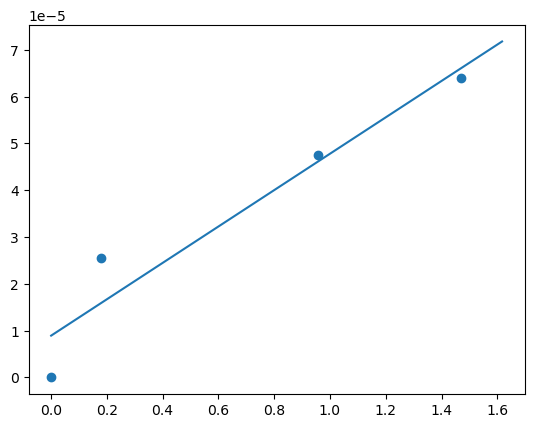

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate GAMMA-AMINOBUTYRATE nan nan nan


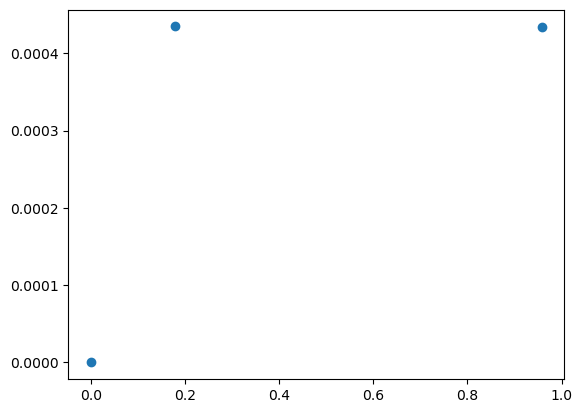

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate PROLINE -2.195264990485171e-05 inf inf


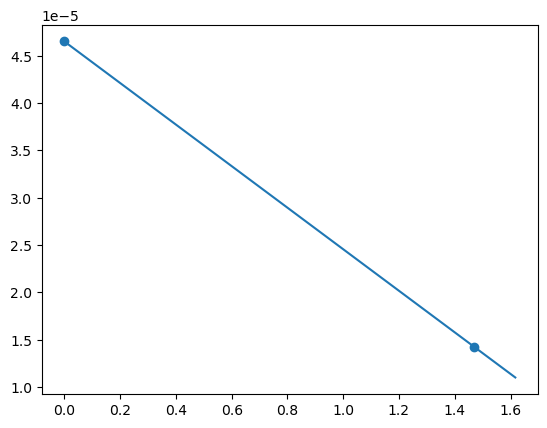

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate PIPECOLIC ACID 8.981463493183831e-06 2.728878804784906e-06 0.30383453730629684


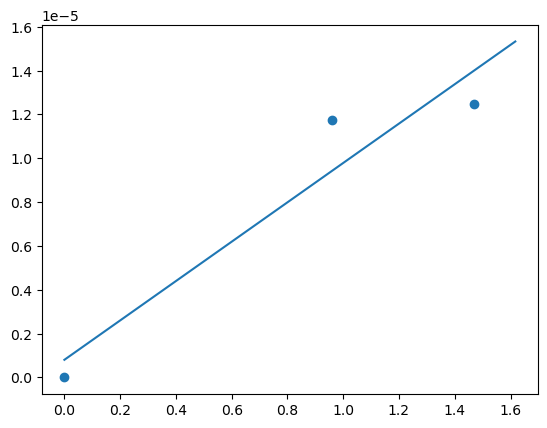

M6 L-malate BETA-ALANINE 0.00011273119261321761 1.1385358811316214e-05 0.10099563880584096


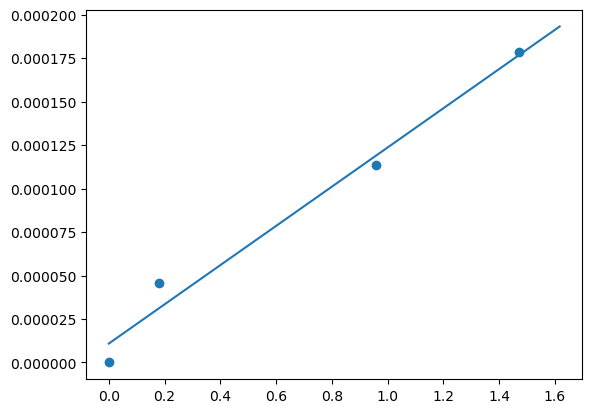

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate CREATINE -2.5485914325921856e-07 inf inf


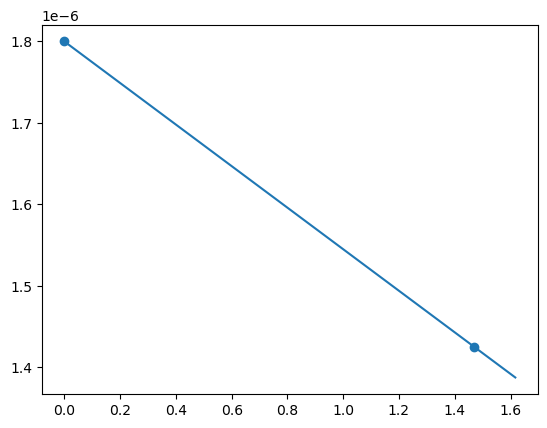

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate ALPHA-AMINOADIPATE 3.592308764863914e-05 9.115327110059817e-06 0.2537456467889427


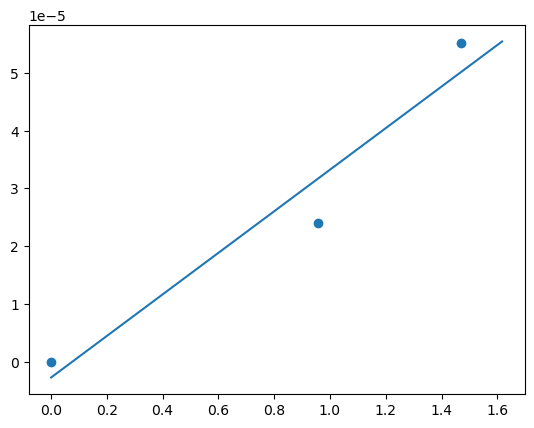

M6 L-malate GLUTAMATE 0.004152712742662007 0.0013274499572558916 0.31965850746636487


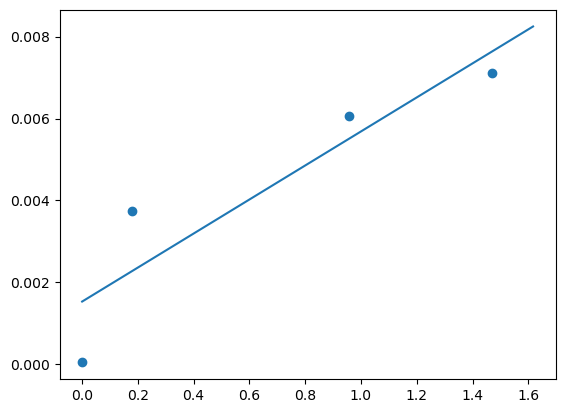

M6 L-malate ASPARAGINE 0.0002108087012207973 0.00010575787614001218 0.501676996858129


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


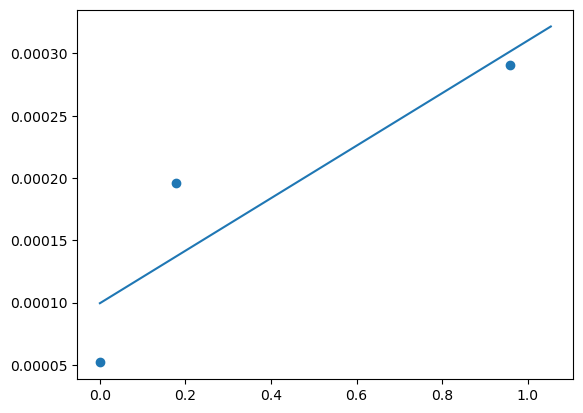

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate ASPARTATE 0.0053849876294429725 0.006210366476691719 1.1532740470443985


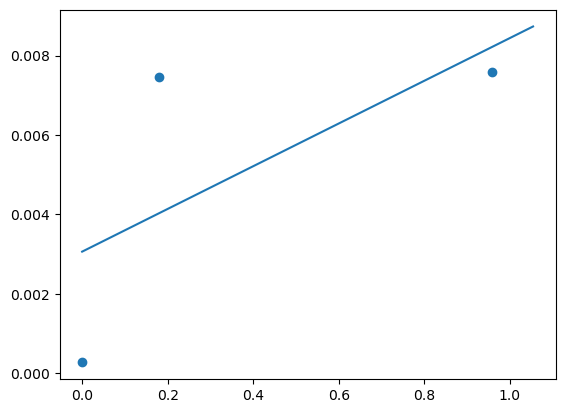

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate PYRUVATE 0.29087592687061464 0.012062654028846287 0.04147010087298118


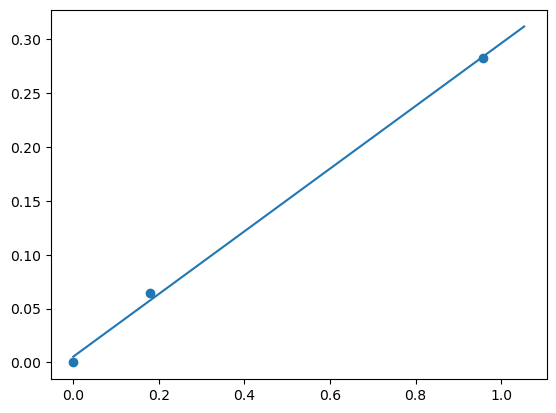

M6 L-malate LACTATE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


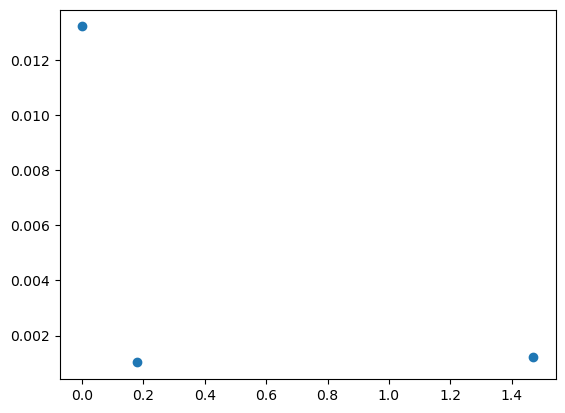

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate NAD nan nan nan


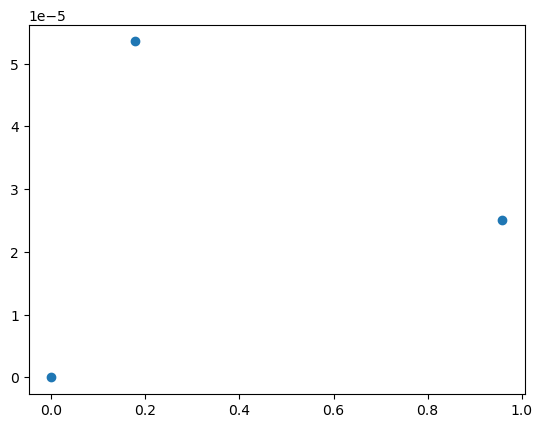

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate GLUTARATE nan nan nan


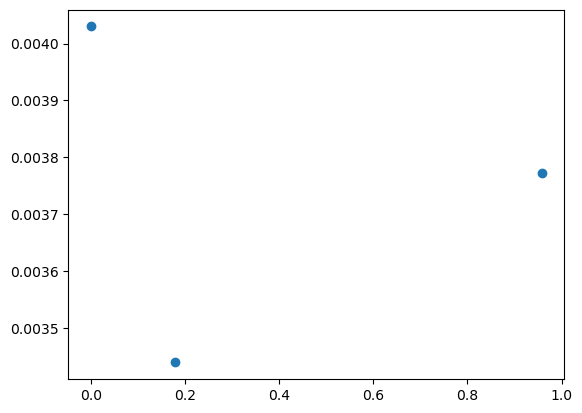

M6 L-malate SUCCINATE nan nan nan


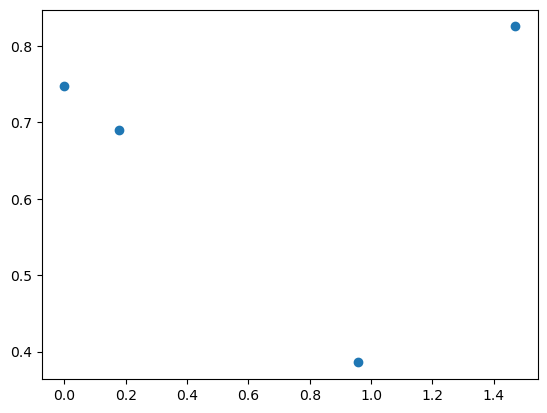

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate MALATE -15.958593028683637 4.978514371020687 0.31196449223765593


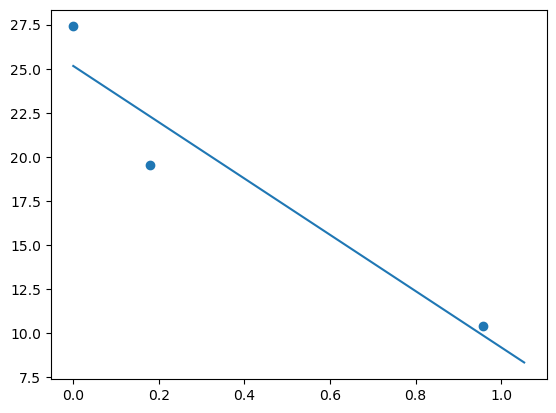

M6 L-malate CIS-ACONITATE 0.00037268975981924875 1.940549973347478e-05 0.05206877630039065


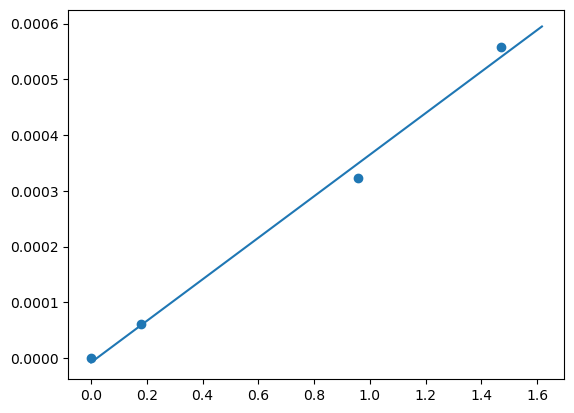

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate CITRATE 0.0035006826251090103 inf inf


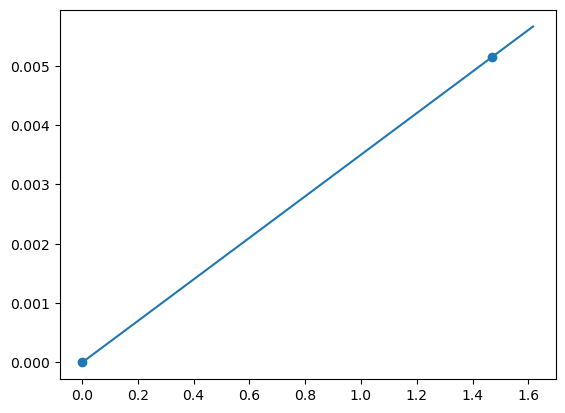

M6 L-malate ISOCITRATE 0.0002873171755659889 0.00020858642467200532 0.7259796573633611


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


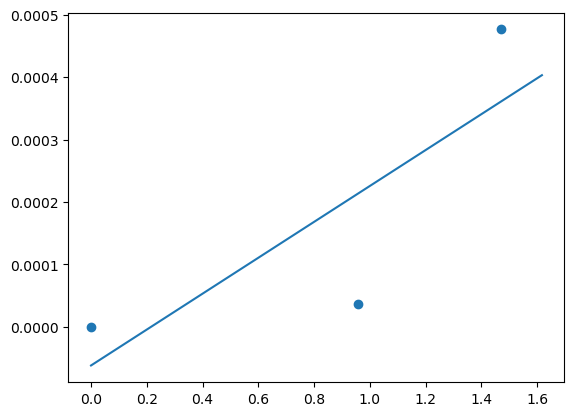

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M6 L-malate TRANS-ACONITATE 1.2909712911764085e-05 3.2613999845540855e-06 0.2526314881551012


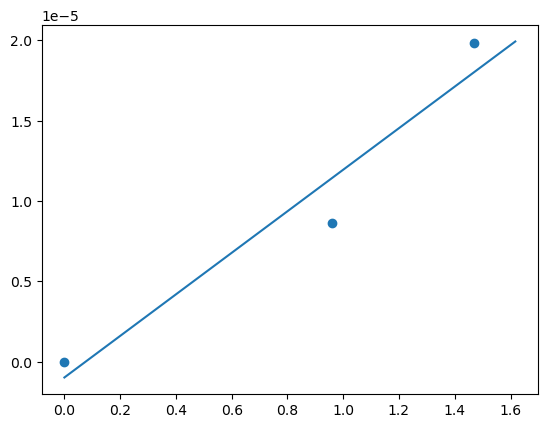

M7 L-malate PHENYLALANINE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


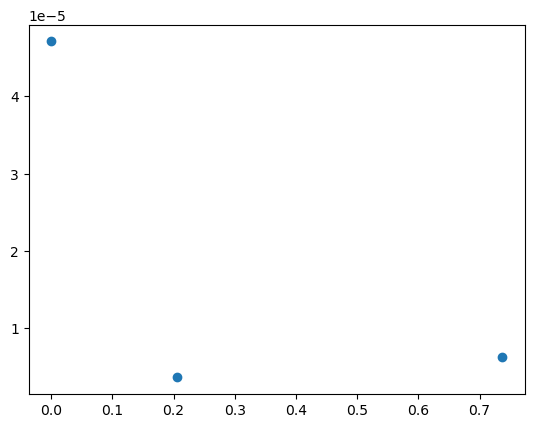

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate LEUCINE 7.058797434693795e-05 5.0679929574123435e-06 0.07179683231173765


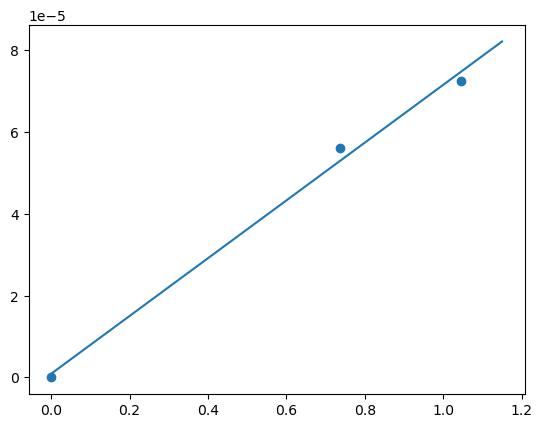

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate ISOLEUCINE nan nan nan


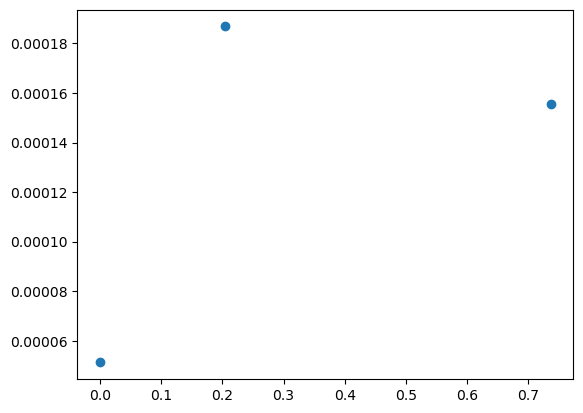

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate METHIONINE 2.7441839772136927e-05 1.4324706559602855e-05 0.5220024123217659


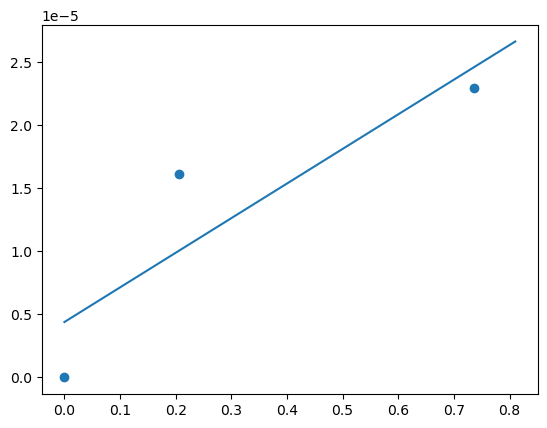

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate GAMMA-AMINOBUTYRATE 0.0022386921218991683 0.00024592126383580576 0.10985041731740286


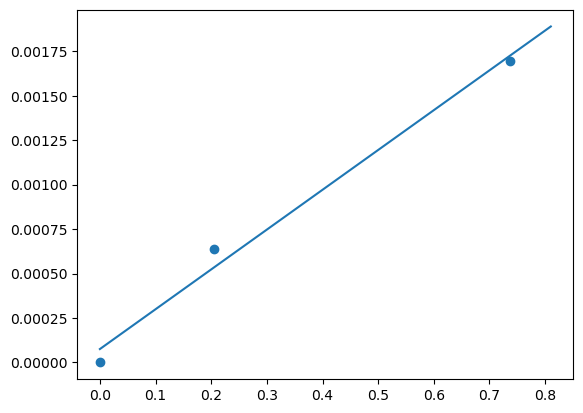

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate PROLINE -2.6079279134597515e-05 inf inf


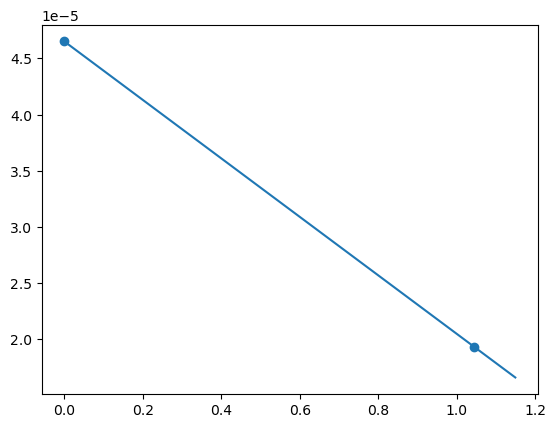

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate PIPECOLIC ACID 2.093816518141386e-05 1.034268154744821e-05 0.4939631270379449


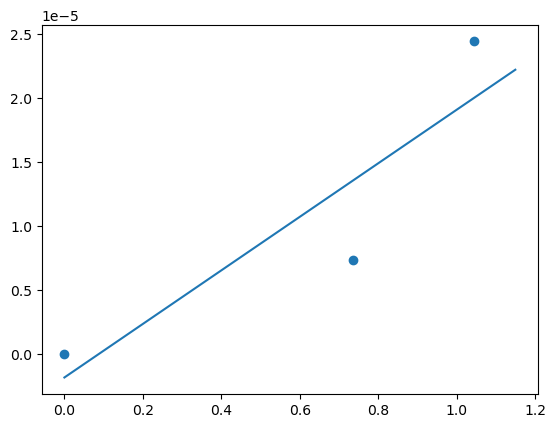

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate BETA-ALANINE 0.0005107974844827852 3.5026275074703134e-05 0.0685717454348262


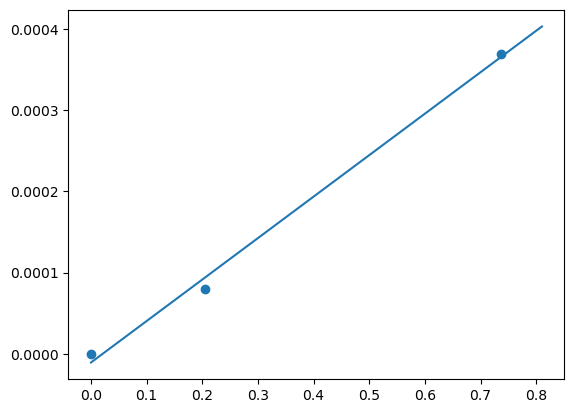

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate CREATINE -4.546045813876541e-07 inf inf


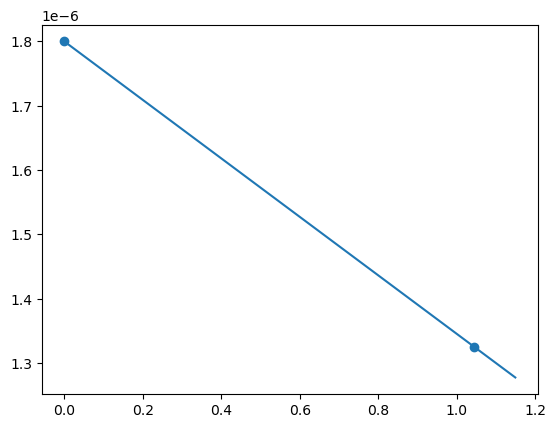

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate ALPHA-AMINOADIPATE 3.4286529411733714e-05 inf inf


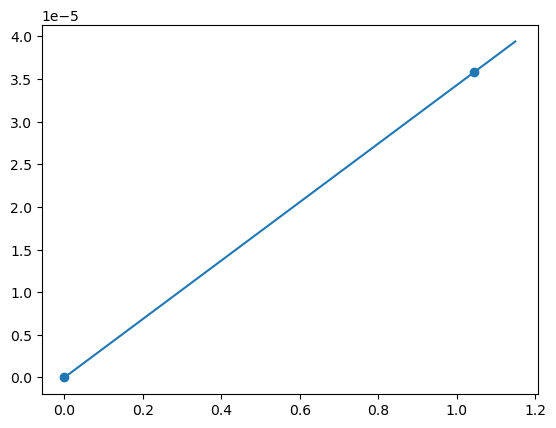

M7 L-malate GLUTAMATE nan nan nan


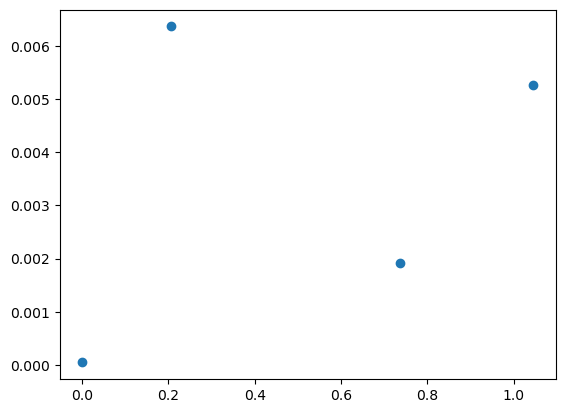

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate ASPARAGINE 0.00024046090084473836 8.214372102251672e-05 0.34160947053739754


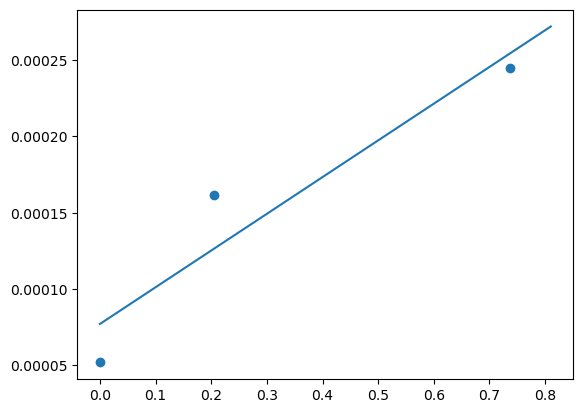

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate ASPARTATE nan nan nan


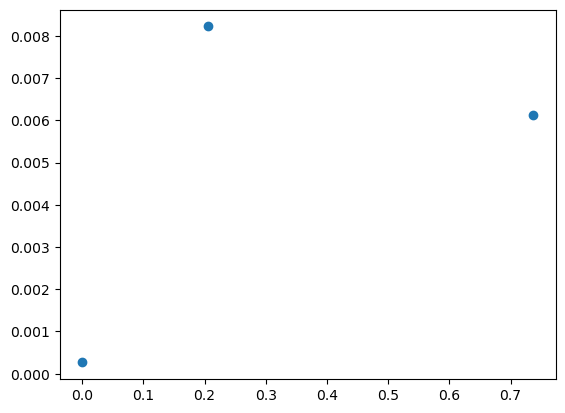

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate PYRUVATE 0.13606279489153317 0.05708755780857933 0.4195677286659334


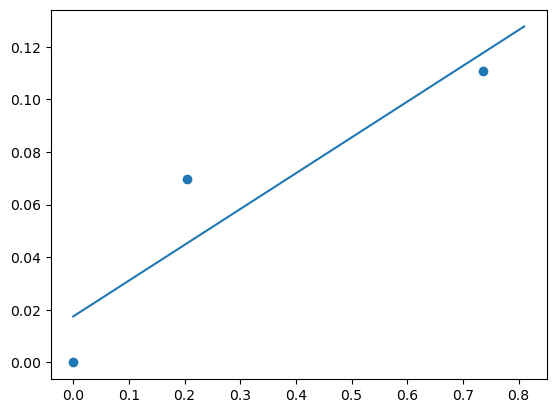

M7 L-malate LACTATE -0.011638334115209493 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


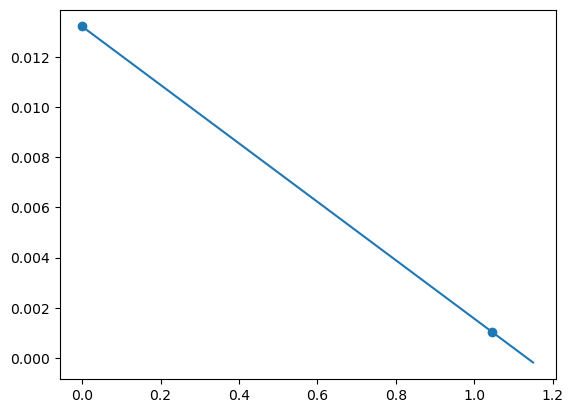

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate NAD 6.932914936856806e-05 inf inf


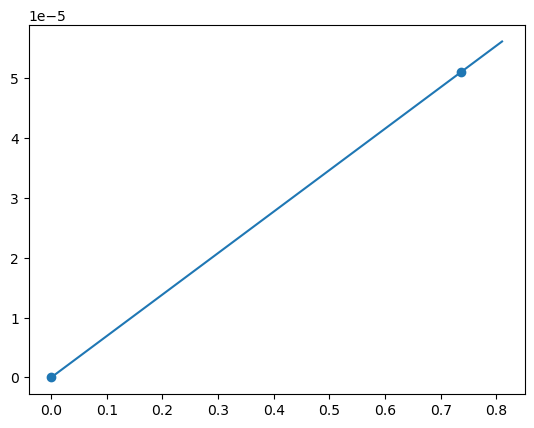

M7 L-malate GLUTARATE -0.0010086740971618395 0.00044521303366729125 0.4413844223025168


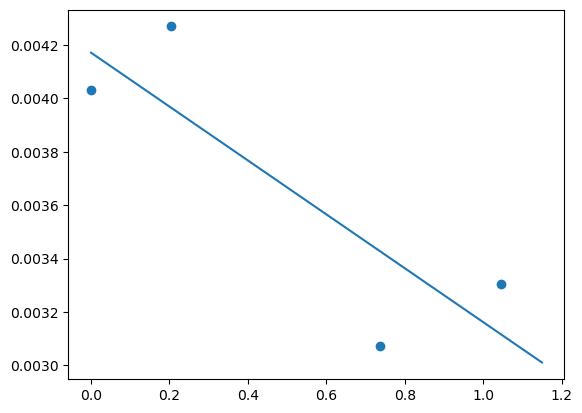

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate SUCCINATE nan nan nan


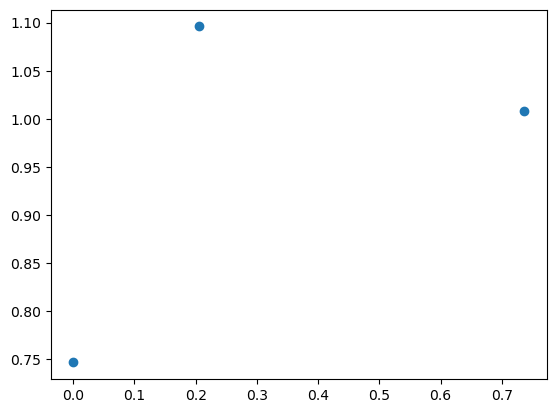

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate MALATE -19.248405505964417 0.18980580486438114 0.00986085859452446


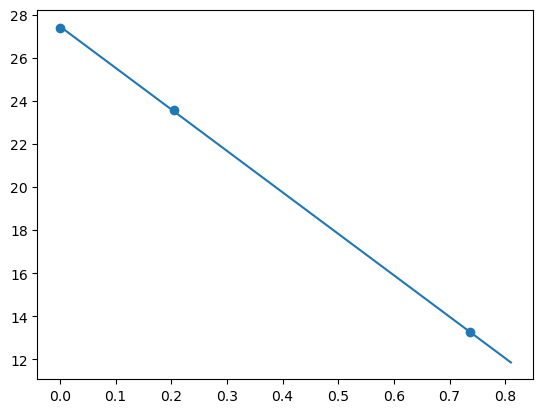

M7 L-malate CIS-ACONITATE 0.00046428631334858916 6.077597834873355e-05 0.1309019383112906


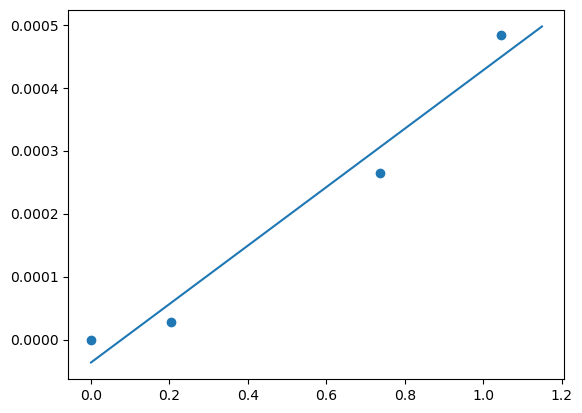

M7 L-malate CITRATE 0.00010428178861152898 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


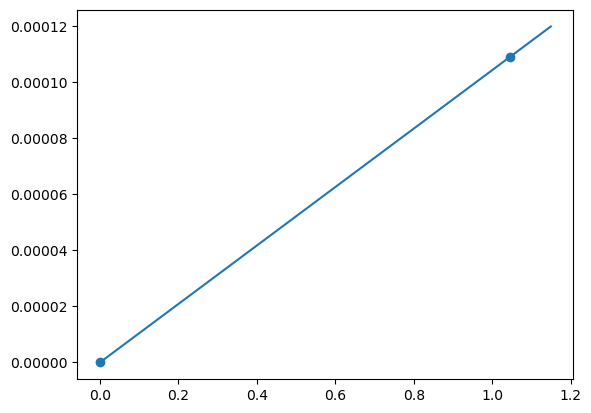

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M7 L-malate ISOCITRATE 0.00014715585862307774 inf inf


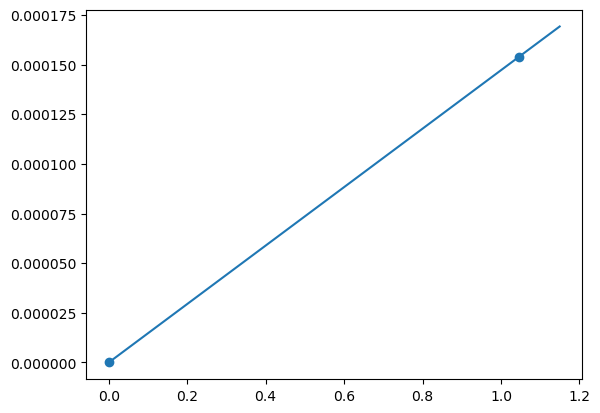

M7 L-malate TRANS-ACONITATE 1.321275498528574e-05 1.2918050050120026e-06 0.09776954211673561


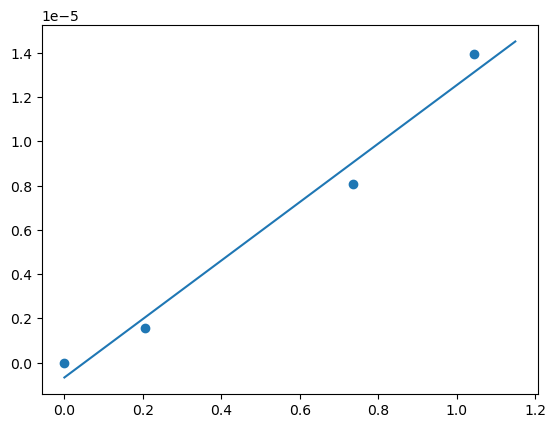

M9 L-alanine PHENYLALANINE 5.819647226824972e-06 7.079156960851191e-07 0.12164237255173575


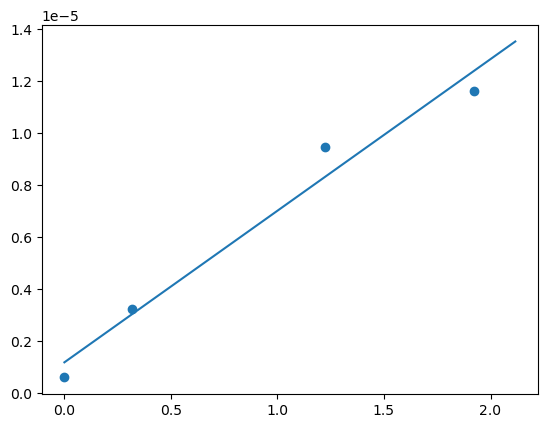

M9 L-alanine LEUCINE 0.0004431019475235015 0.0002693860133623456 0.6079549297130041


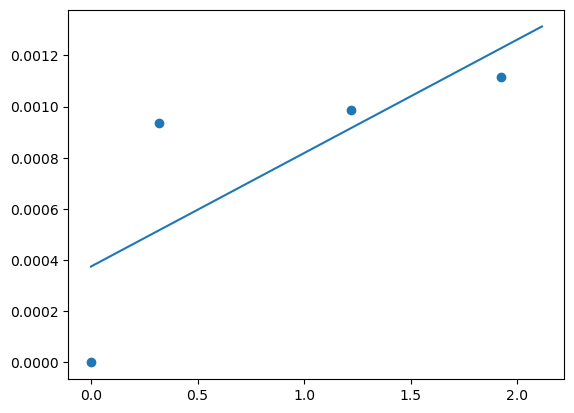

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine ISOLEUCINE 0.0008345480676046308 0.00010218254556050974 0.12244057535691158


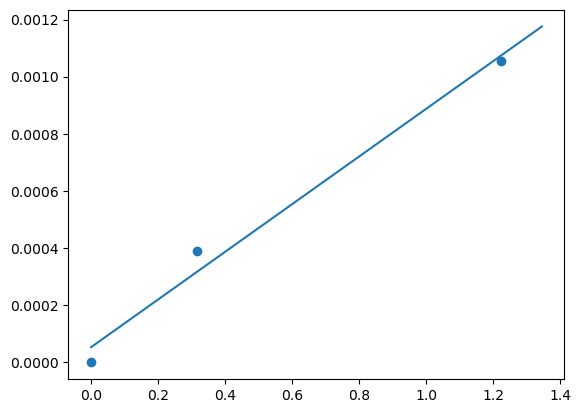

M9 L-alanine METHIONINE 1.1725140000878937e-05 6.662025714123552e-06 0.5681830420467606


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


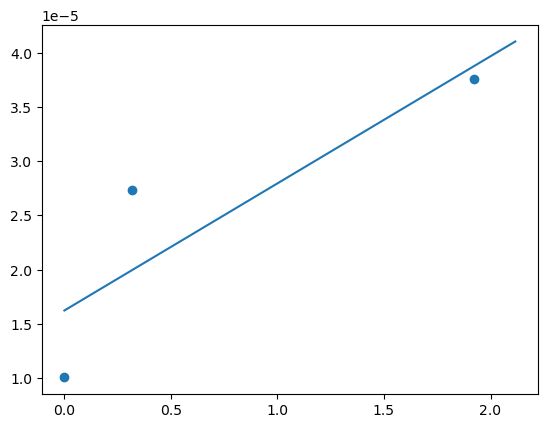

M9 L-alanine GAMMA-AMINOBUTYRATE 0.007653293340696602 0.00019915790401398345 0.0260225101989696


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


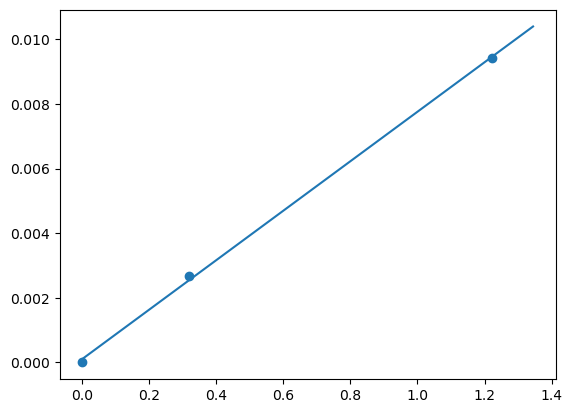

M9 L-alanine PROLINE 0.00039801638438777086 8.001979909706667e-05 0.20104649515912063


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


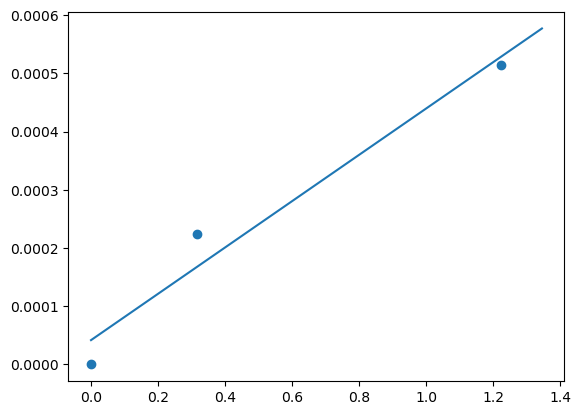

M9 L-alanine VALINE nan nan nan


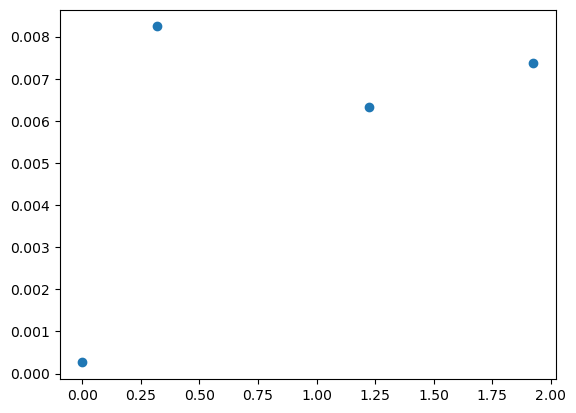

M9 L-alanine PIPECOLIC ACID 1.9715983170072018e-05 1.511692209004412e-06 0.07667343778722095


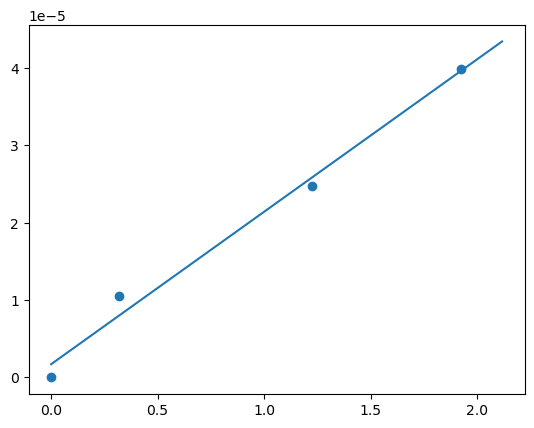

M9 L-alanine ALPHA-AMINOBUTYRATE 0.1719571259683955 0.03845616990711913 0.22363812892631796


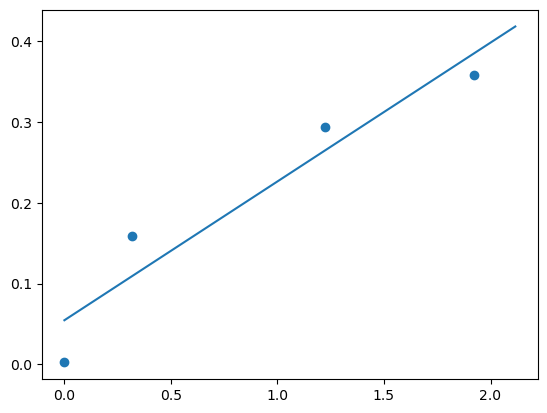

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine BETA-ALANINE 0.00043693818085084997 2.1221066090505704e-05 0.048567662476146876


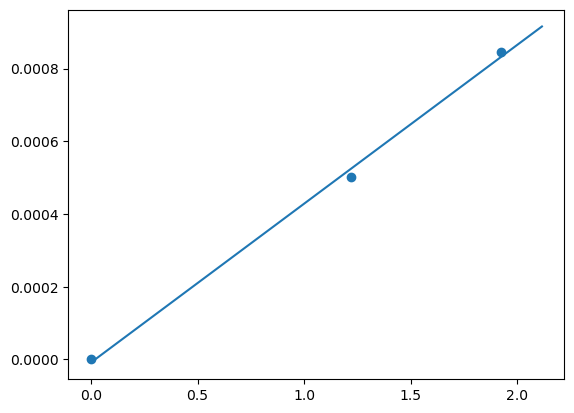

M9 L-alanine ALANINE -19.350783975073533 0.3634970360574844 0.018784615472206112


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


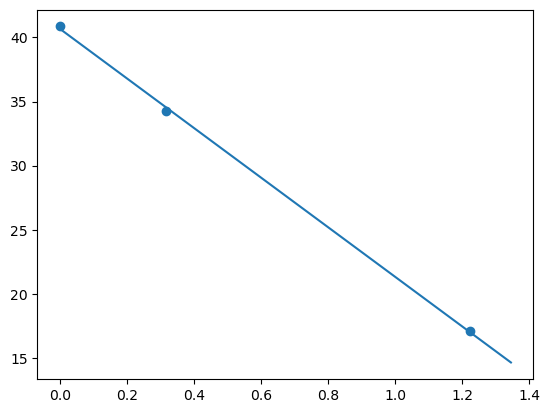

M9 L-alanine CREATINE 1.5923774928204108e-06 5.794718406435569e-07 0.36390356134536883


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


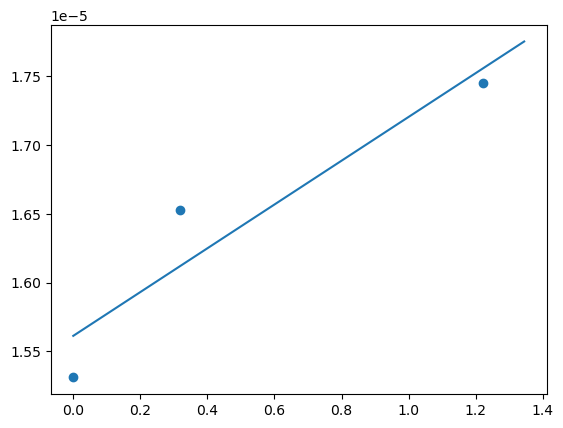

M9 L-alanine ALPHA-AMINOADIPATE 8.512594715424331e-05 inf inf


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


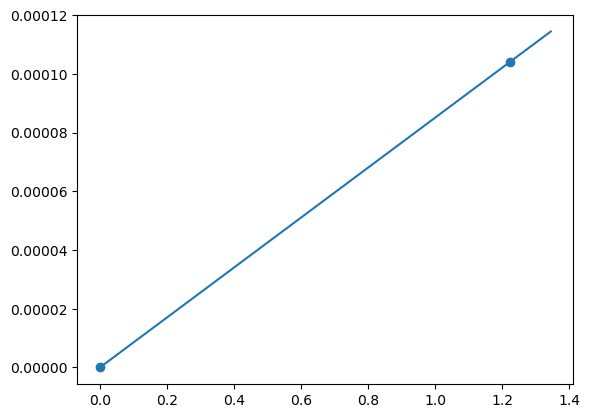

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine GLYCINE 0.048459505821553055 0.012644533692029145 0.26092989347830514


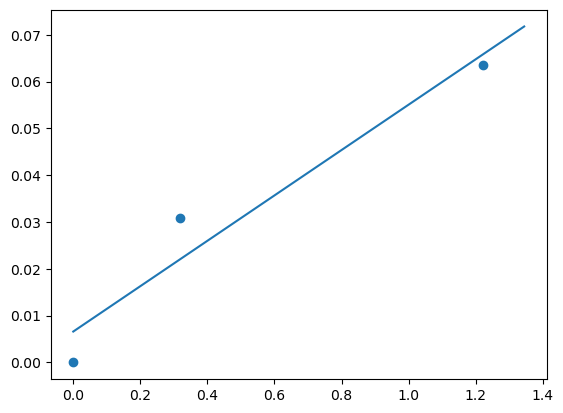

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine GLUTAMINE 1.9700666591905363e-05 inf inf


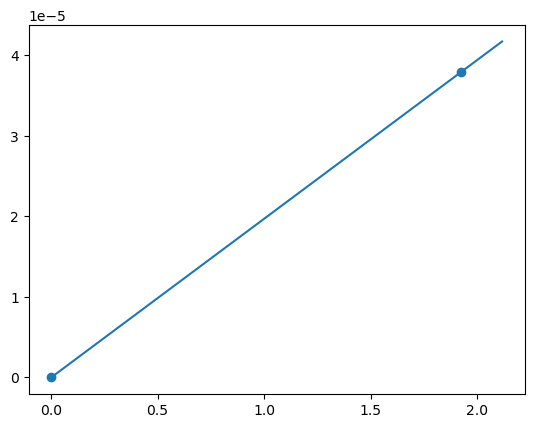

M9 L-alanine GLUTAMATE 0.0016505540175051343 0.0008492025045888295 0.5144954334014626


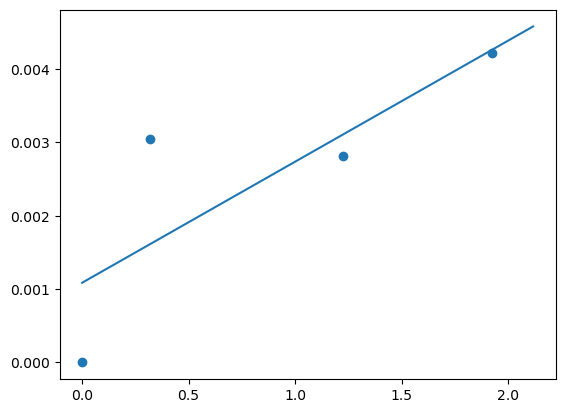

M9 L-alanine SERINE 0.0005142642836483128 0.00010503916114133095 0.2042513246227372


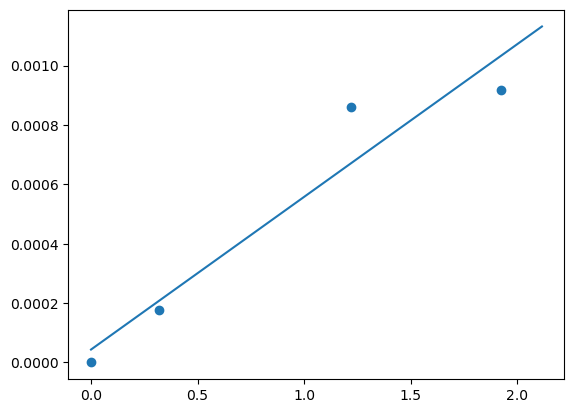

M9 L-alanine ASPARAGINE 0.006835407572571941 0.004002043645743444 0.5854872007635977


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


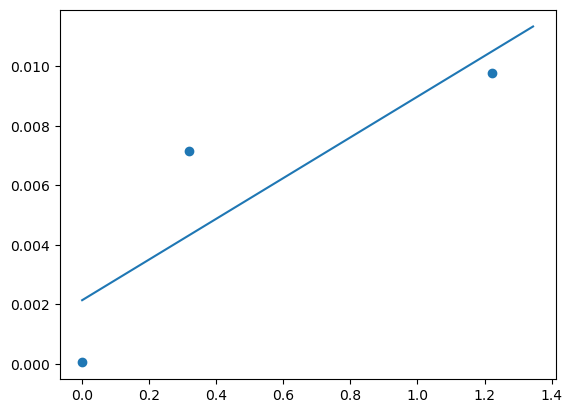

M9 L-alanine ASPARTATE 0.00010568546777750785 8.831276082456923e-05 0.835618772208946


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


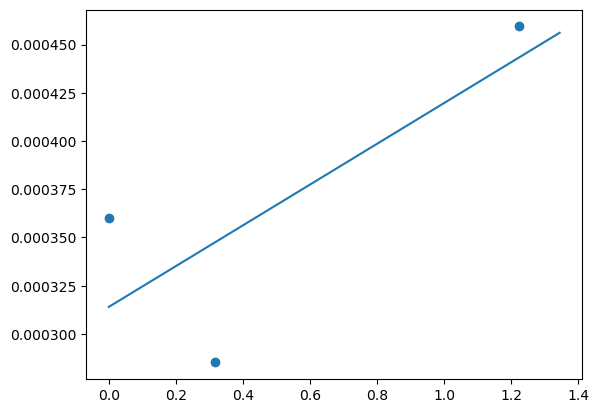

M9 L-alanine LYSINE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


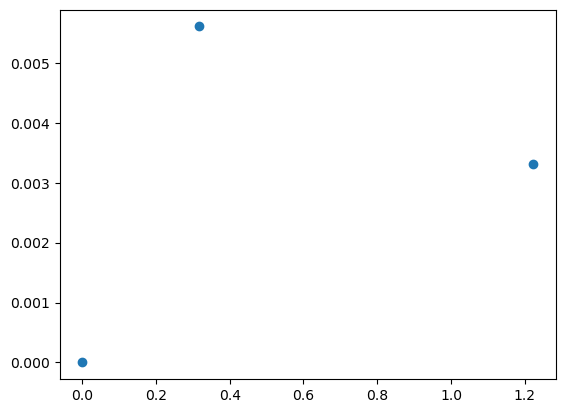

M9 L-alanine PYRUVATE 0.0015494455896480804 0.0012824345930459403 0.8276732023466631


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


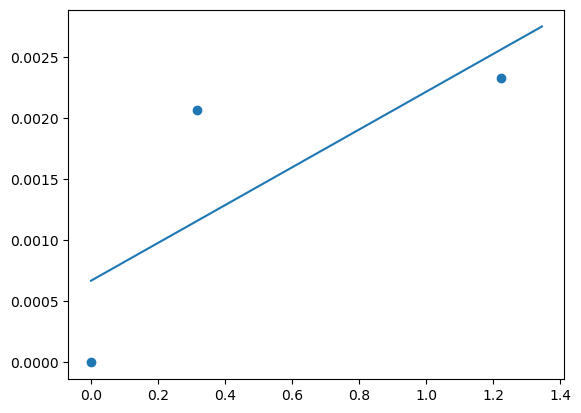

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine LACTATE 0.0007595078700513063 0.00040328419795145374 0.5309809336461663


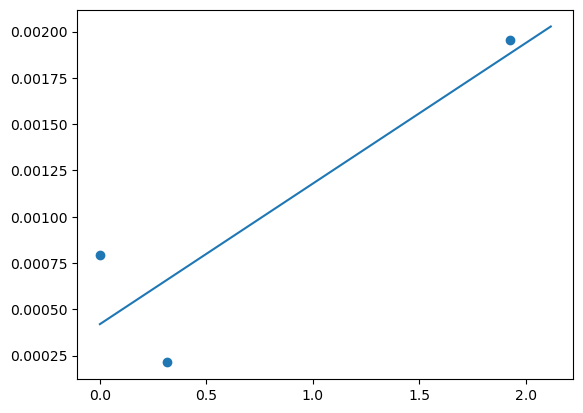

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine NAD 6.142219942677481e-05 1.4692791002546892e-05 0.23920978310233051


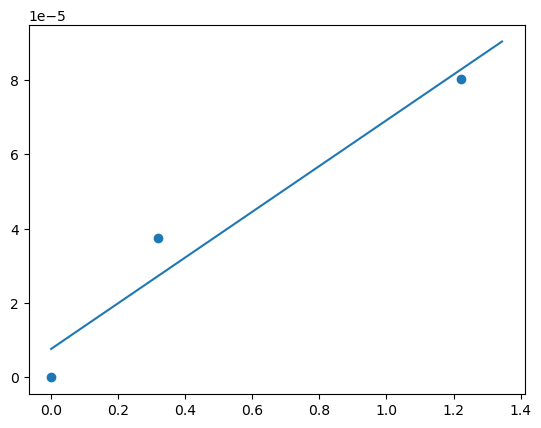

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine SUCCINATE 0.003588355111544148 0.0004807779599435946 0.1339828263922032


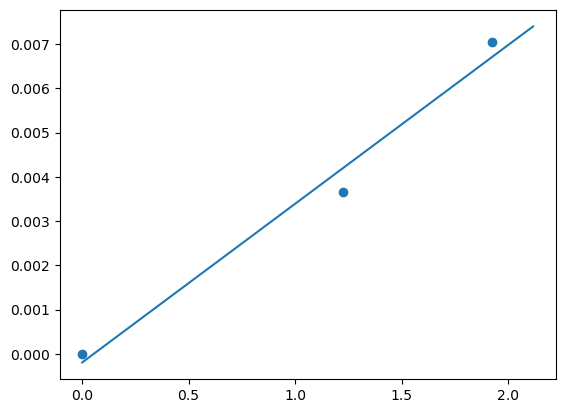

M9 L-alanine MALATE 0.004559756235270076 0.0012286373624202027 0.26945242224060034


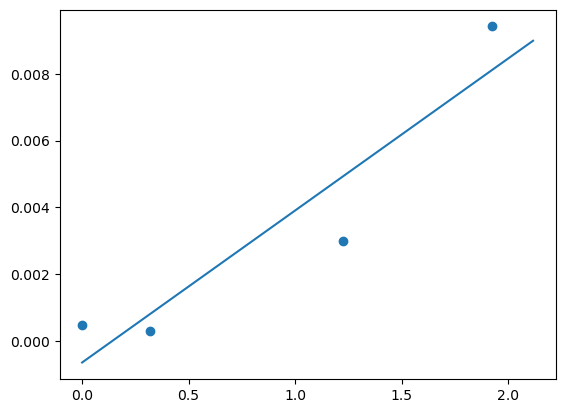

M9 L-alanine CIS-ACONITATE 0.000775348159883001 0.00018531026759293197 0.23900265349297412


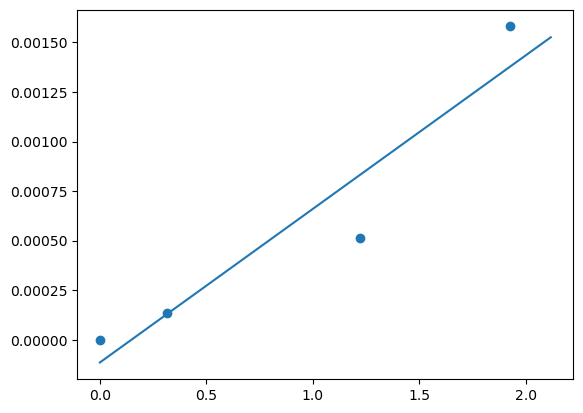

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine CITRATE 0.006537865131872577 inf inf


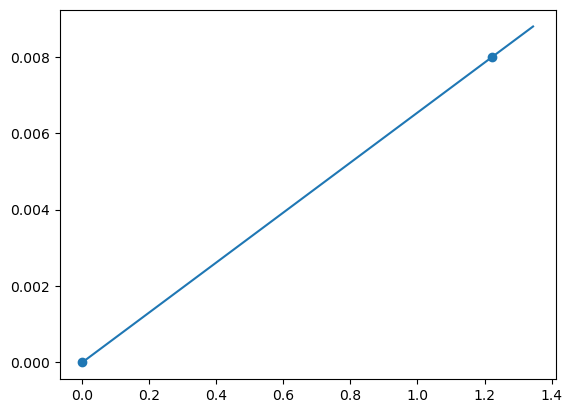

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M9 L-alanine ISOCITRATE 0.00036586248156853185 0.00015150478719833866 0.41410309837949155


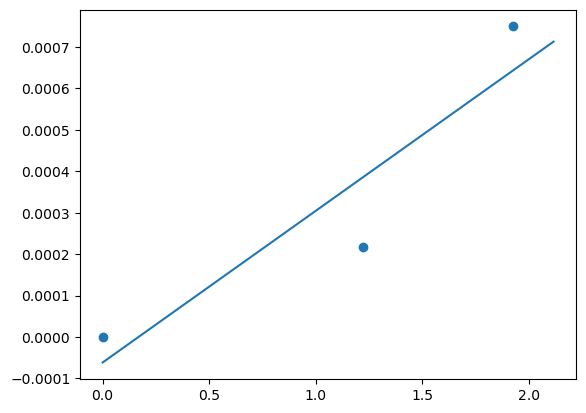

M9 L-alanine TRANS-ACONITATE 1.8933396294907924e-05 1.0193663035077468e-05 0.5383959051139188


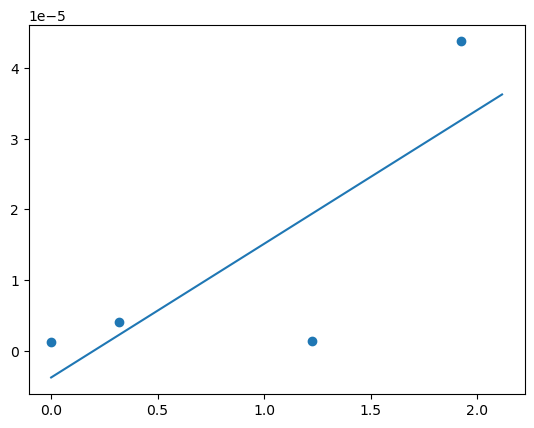

M10 L-alanine PHENYLALANINE 1.747950109015824e-05 8.661792877450584e-06 0.4955400519027153


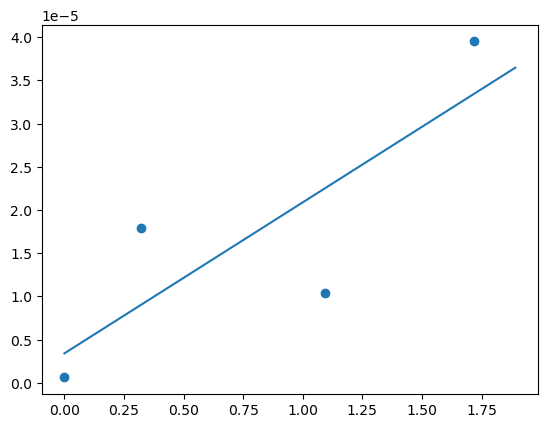

M10 L-alanine LEUCINE nan nan nan


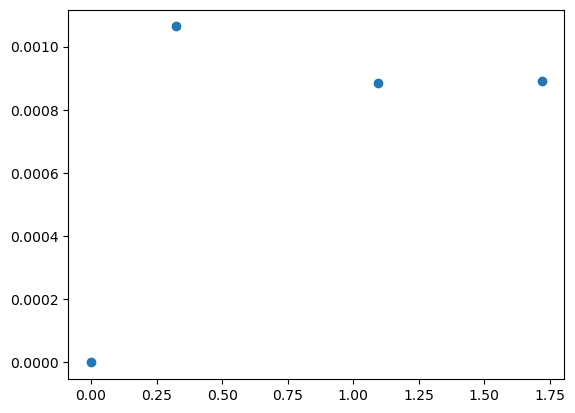

M10 L-alanine ISOLEUCINE 0.0005133419691746751 0.0001233647534287491 0.2403169053702907


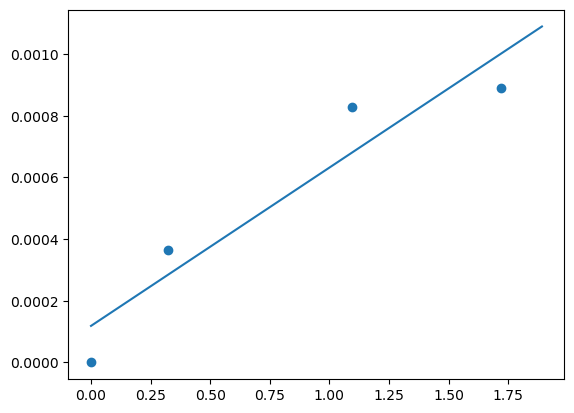

M10 L-alanine METHIONINE 1.0813125848293964e-05 1.1598675290985893e-05 1.0726477665860024


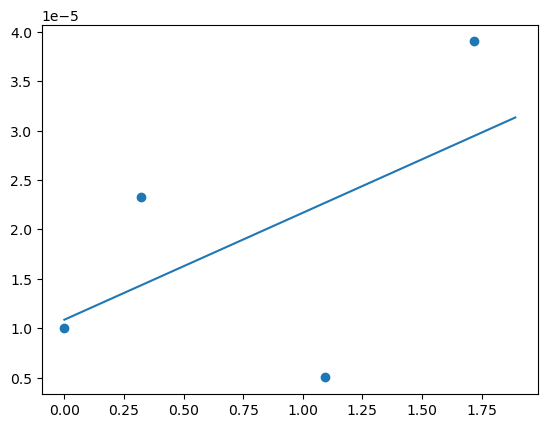

M10 L-alanine GAMMA-AMINOBUTYRATE 0.00986676686501258 0.0003163981419517462 0.03206705360331252


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


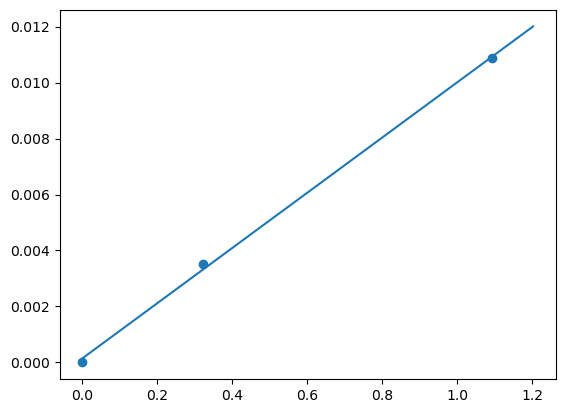

M10 L-alanine PROLINE 0.00018405434559490784 9.828742659116733e-05 0.5340130724622598


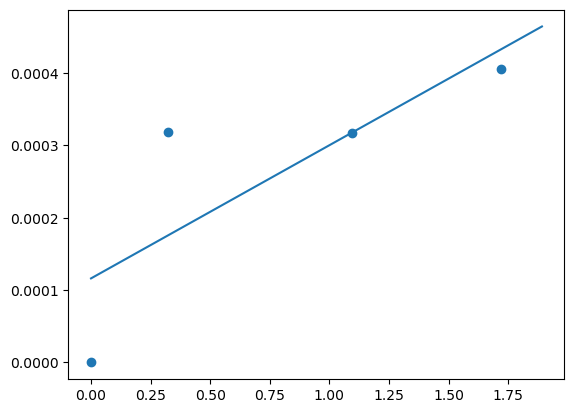

M10 L-alanine TYROSINE 3.673954113345878e-05 2.9557339896254465e-05 0.8045103173413489


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


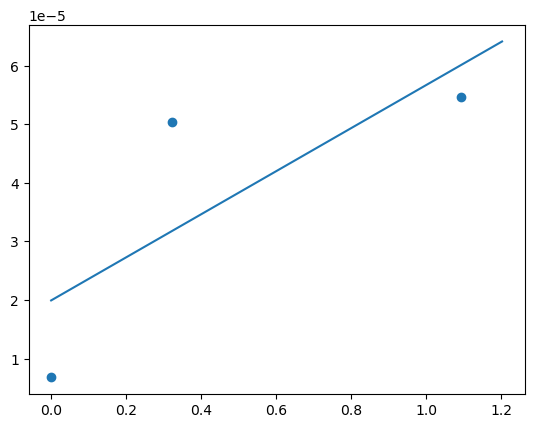

M10 L-alanine VALINE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


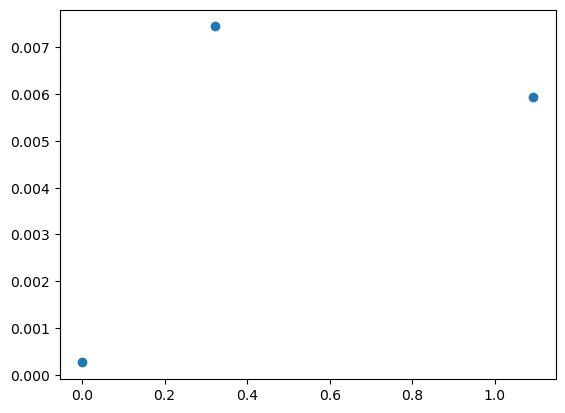

M10 L-alanine PIPECOLIC ACID 2.0721341858720267e-05 3.466372786735784e-06 0.16728515027500562


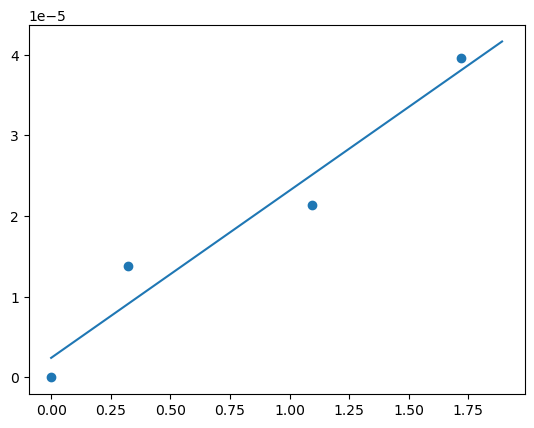

M10 L-alanine ALPHA-AMINOBUTYRATE 0.2016358082608342 0.052249819438301856 0.2591296649586763


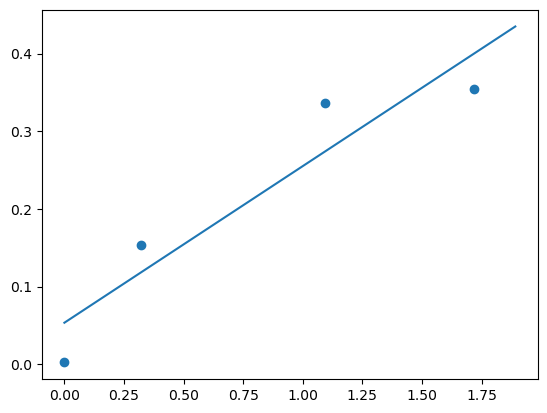

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine BETA-ALANINE 0.00040179120635784214 3.10213883694762e-05 0.07720773346604311


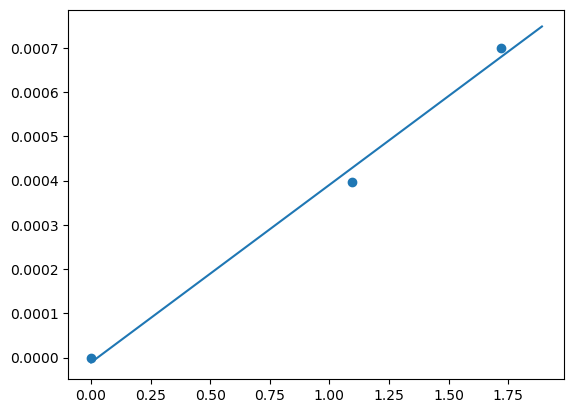

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine ALANINE -19.597281380227223 1.4762386107129684 0.07532874494532833


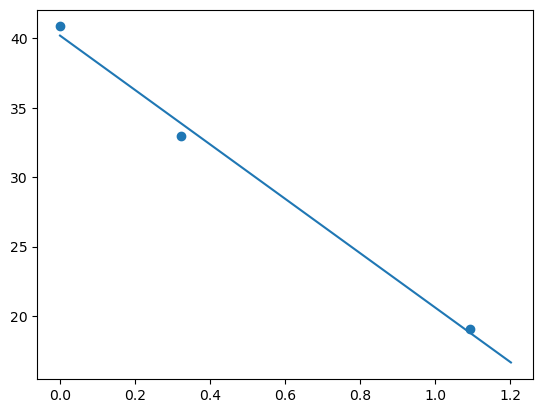

M10 L-alanine CREATINE -3.4936313986361354e-06 3.816366235340791e-06 1.0923780444699023


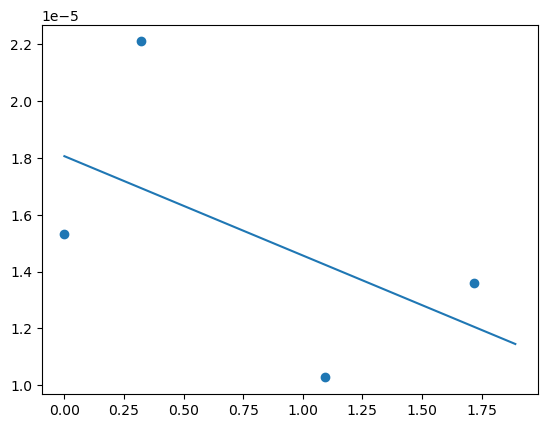

M10 L-alanine ALPHA-AMINOADIPATE 5.393131633880977e-05 2.427182352111728e-06 0.045005064160933375


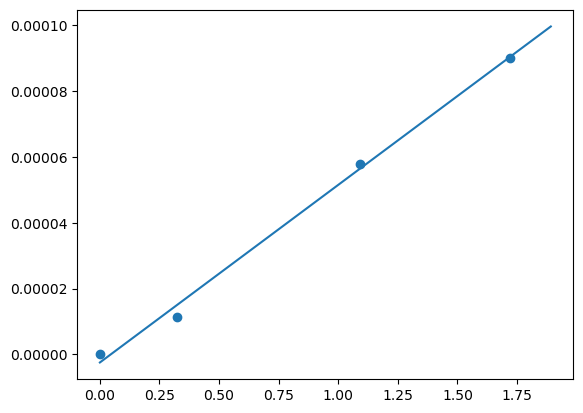

M10 L-alanine GLYCINE 0.039698038001831214 0.00986301011062655 0.24845082042018257


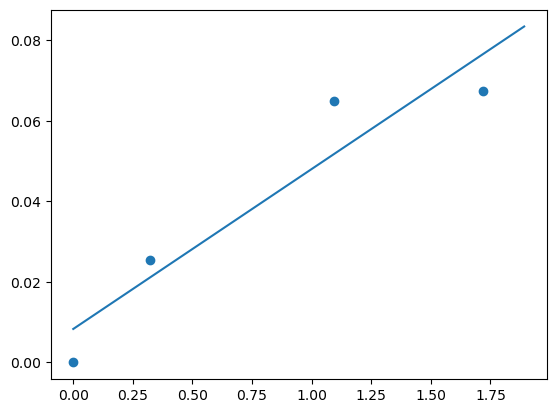

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine GLUTAMINE nan nan nan


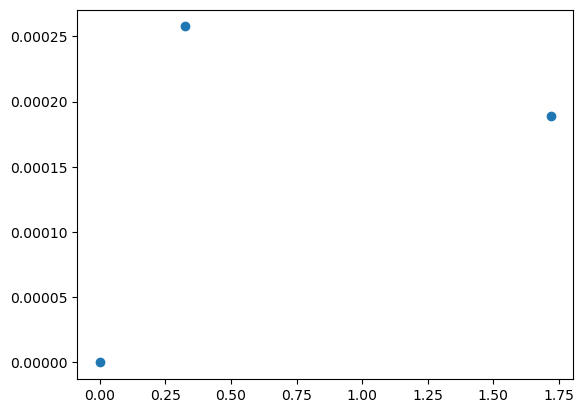

M10 L-alanine GLUTAMATE 0.001521242395492599 0.0012338554833254112 0.8110840763978787


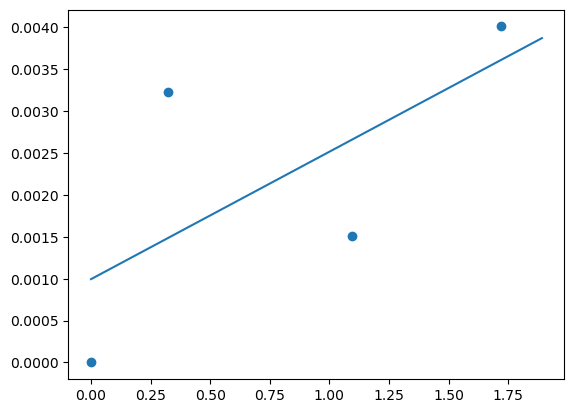

M10 L-alanine SERINE 0.0009608545701934504 0.00012671733695853035 0.1318798295698569


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


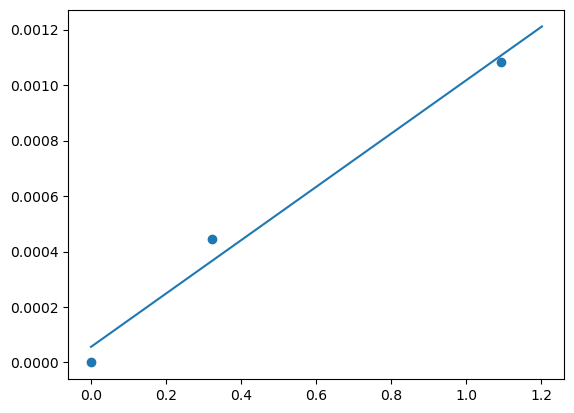

M10 L-alanine ASPARAGINE 0.010156817022433153 0.0032457644263520023 0.3195651176134363


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


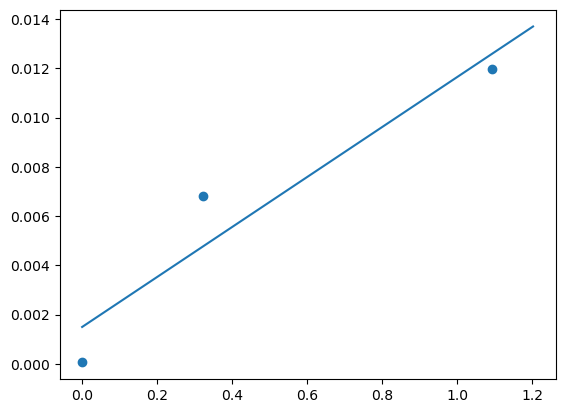

M10 L-alanine ASPARTATE 0.00011327027581390124 0.00011621577937123066 1.0260042057474


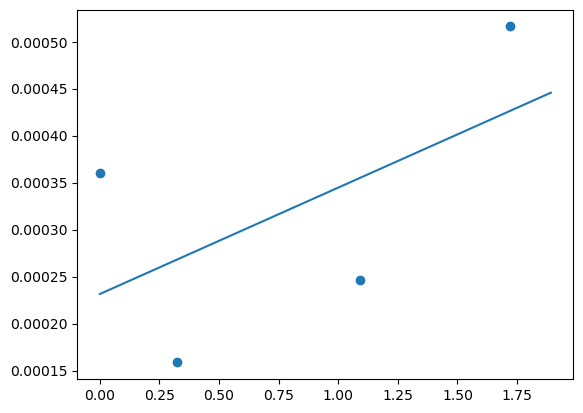

M10 L-alanine LYSINE nan nan nan


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


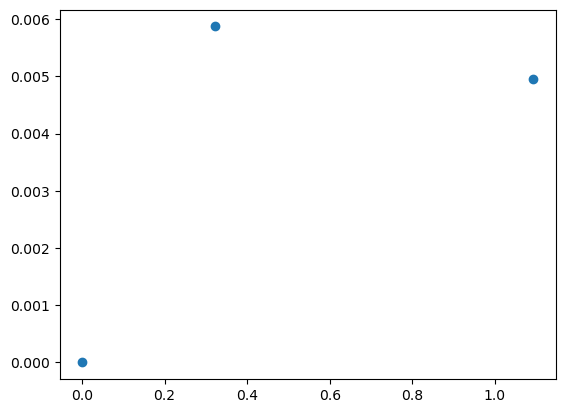

M10 L-alanine LACTATE nan nan nan


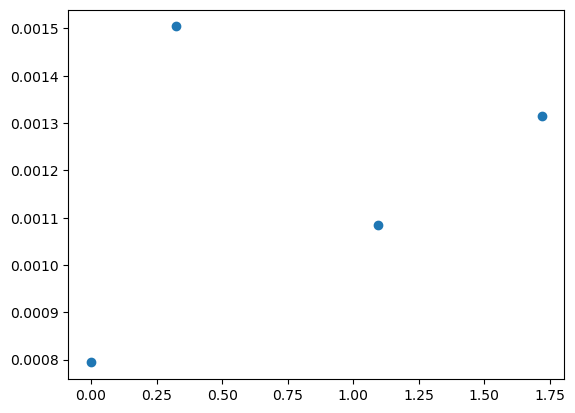

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine NAD 0.00014471166041903652 inf inf


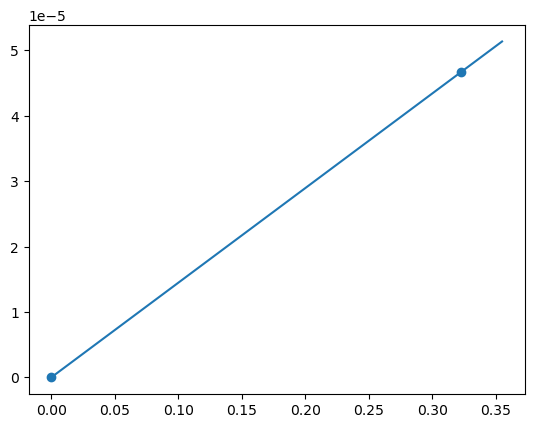

M10 L-alanine SUCCINATE 0.003158541530178886 0.0003311139798138632 0.10483128895098313


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


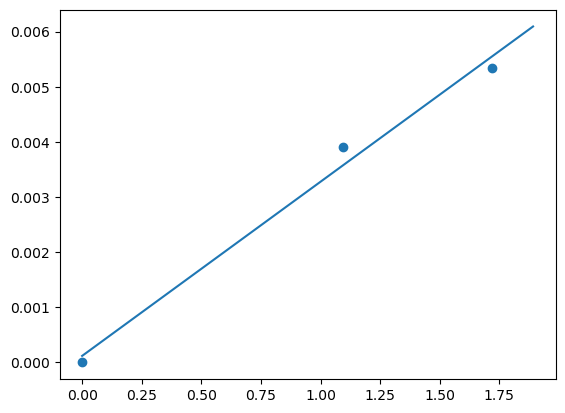

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine MALATE 0.002691931523242022 3.301725326547707e-05 0.012265264914953264


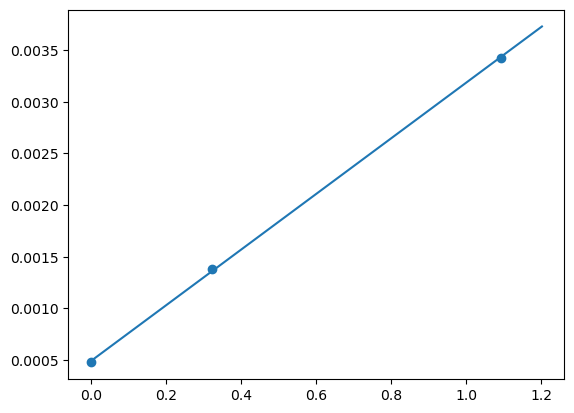

M10 L-alanine CIS-ACONITATE 0.0009056544358945927 0.00010655889402688927 0.11765955071111853


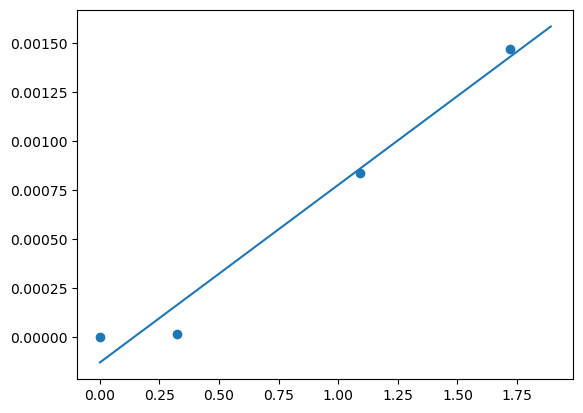

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine CITRATE 0.002587173371708938 inf inf


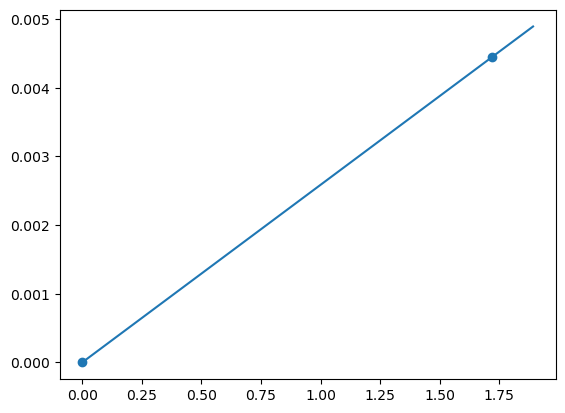

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine ISOCITRATE 0.0003696726980713423 0.00016370739863690156 0.4428441686145511


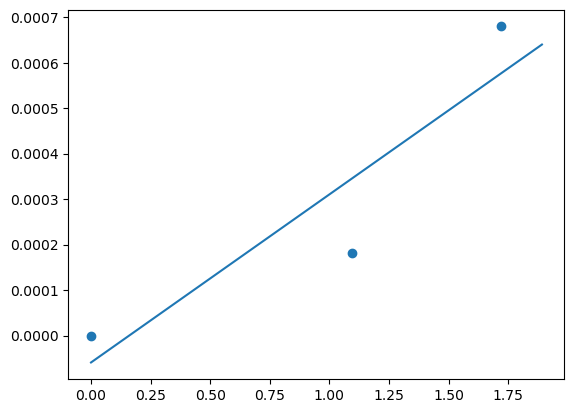

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M10 L-alanine TRANS-ACONITATE 1.9974503895528892e-05 6.363864360545196e-06 0.31859937016857215


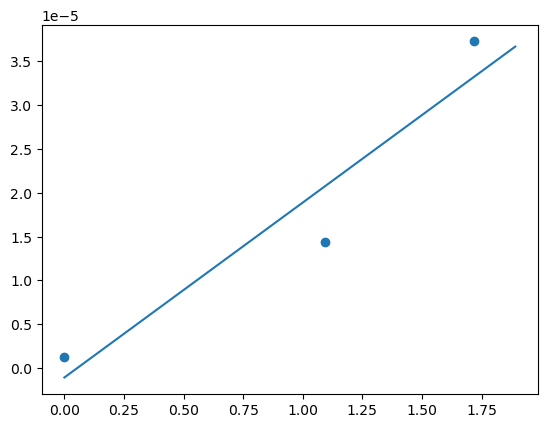

M11 L-alanine PHENYLALANINE 4.972505060691352e-05 3.894886405589275e-06 0.07832845533691121


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


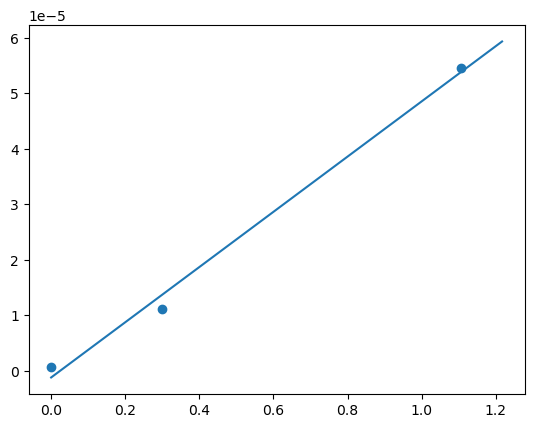

M11 L-alanine LEUCINE 0.0006916834116943552 0.0003186308583818155 0.4606599681222568


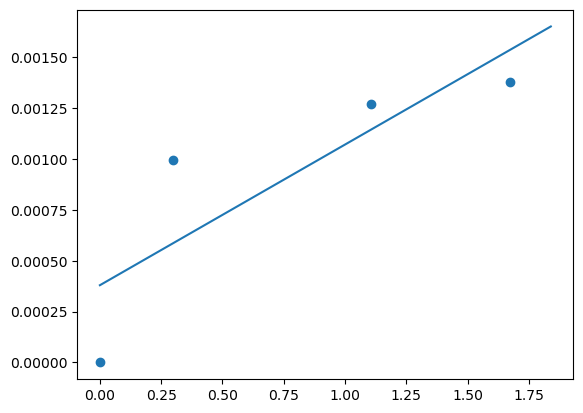

M11 L-alanine ISOLEUCINE 0.0008320208630736212 4.552554589691446e-05 0.054716832134155444


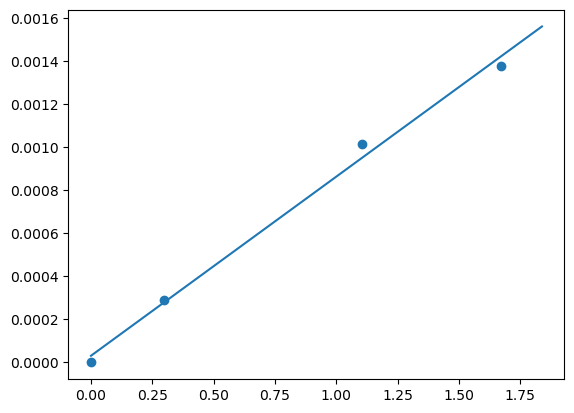

M11 L-alanine METHIONINE 2.7979892683988223e-05 1.5908873755881278e-05 0.5685823721899153


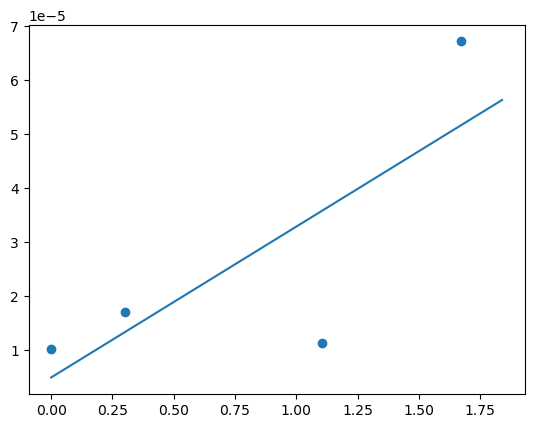

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine GAMMA-AMINOBUTYRATE 0.007454849855883106 0.0001909326933232642 0.025611876431365924


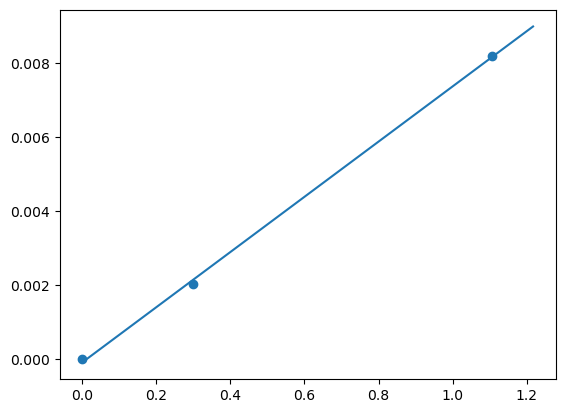

M11 L-alanine PROLINE 0.0005727122986378672 8.112298640064873e-05 0.14164701298294236


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


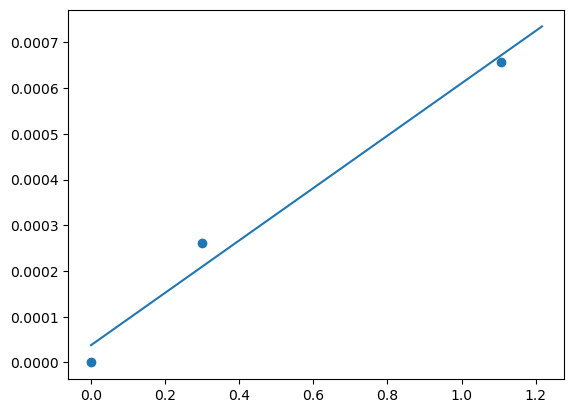

M11 L-alanine TYROSINE 4.330042950205482e-05 4.0038926824393584e-05 0.9246773596666873


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


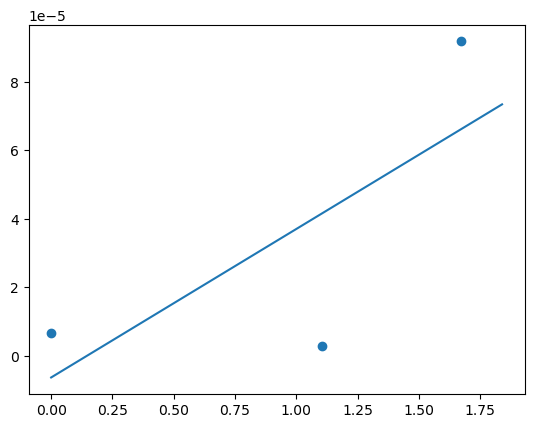

M11 L-alanine VALINE 0.003264534721609144 0.0022273521284887987 0.6822877740417782


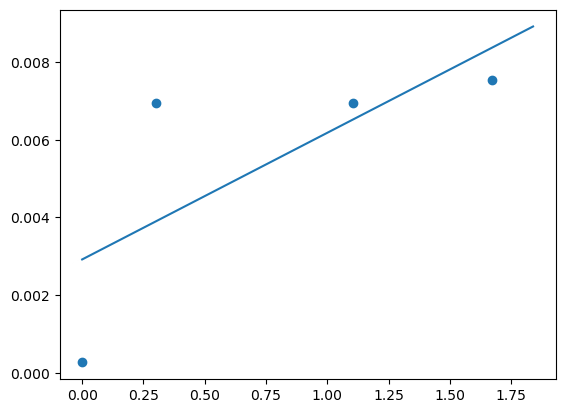

M11 L-alanine PIPECOLIC ACID 2.1507791945186837e-05 2.448342052845926e-06 0.11383511887624675


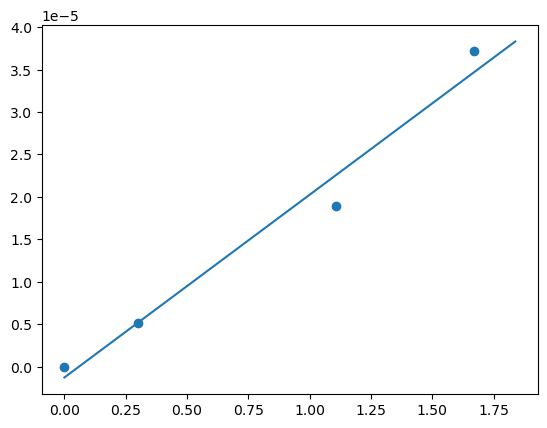

M11 L-alanine ALPHA-AMINOBUTYRATE 0.20592673456673413 0.038077812719320606 0.1849095155101429


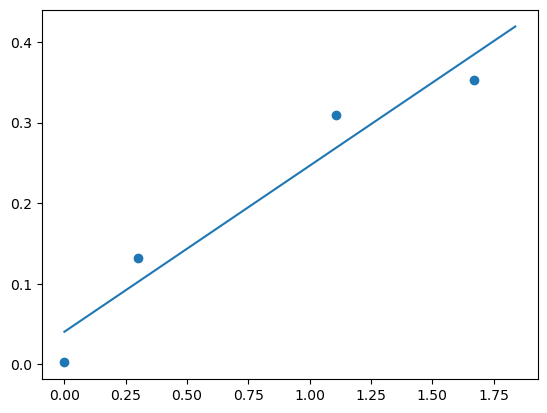

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine BETA-ALANINE 0.00041704723809726237 3.539905782223451e-05 0.08488021161281221


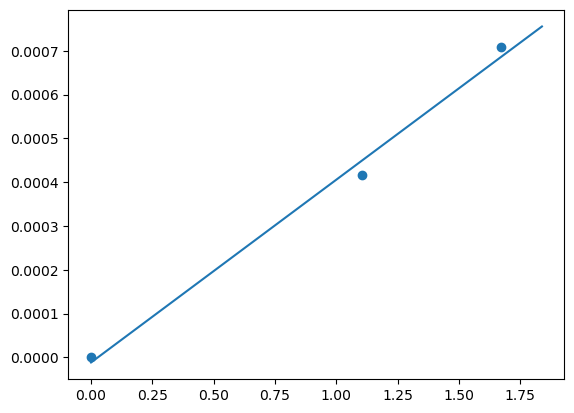

M11 L-alanine ALANINE -16.41856985195011 2.6335142494032757 0.1603985166278341


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


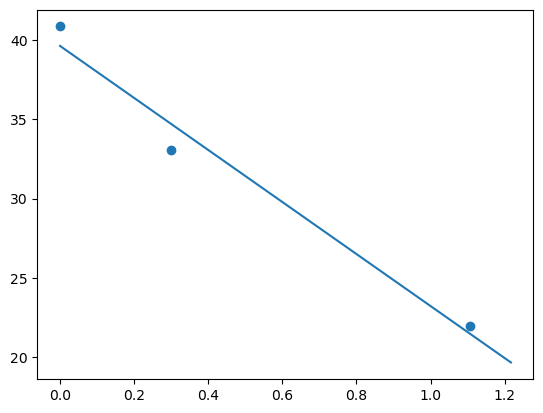

M11 L-alanine CREATINE -4.065179130221184e-06 9.321284084673206e-07 0.22929577728512152


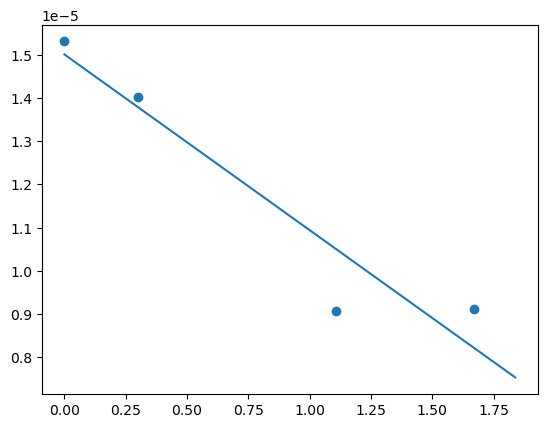

M11 L-alanine ALPHA-AMINOADIPATE 6.455250198561267e-05 1.0351333628314262e-05 0.1603552660223975


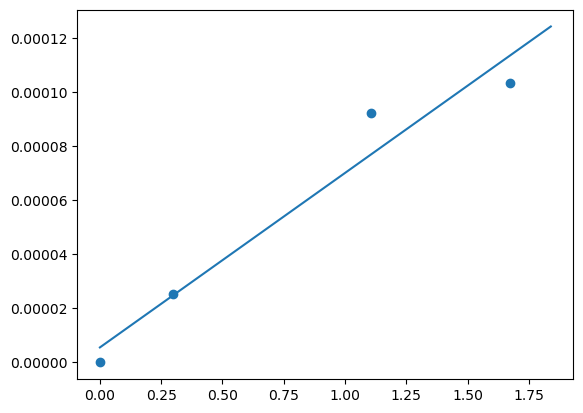

M11 L-alanine GLYCINE 0.03023285756479041 0.006630207716080903 0.21930469860058915


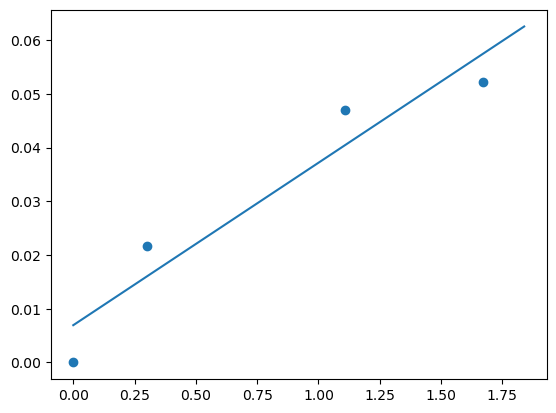

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine GLUTAMINE 2.0714779543206288e-05 inf inf


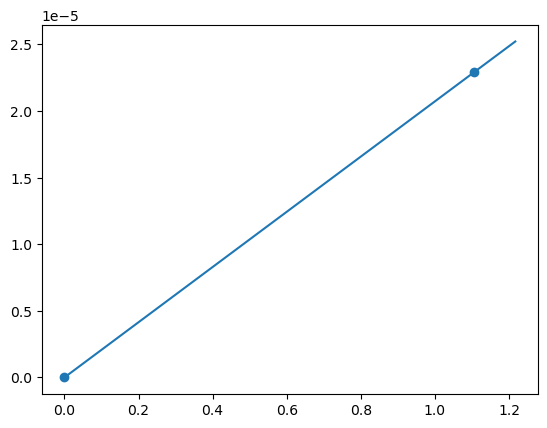

M11 L-alanine GLUTAMATE 0.0041955044433807836 0.0016226837769902803 0.38676726455393856


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


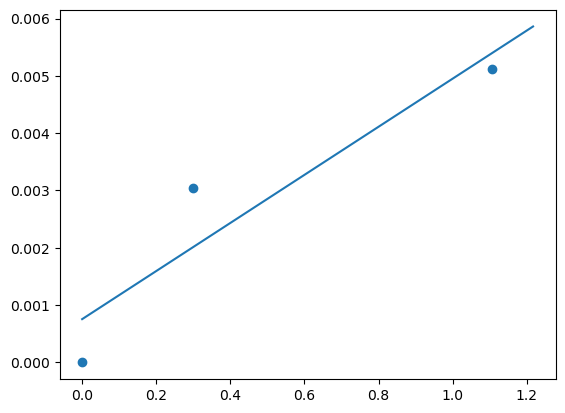

M11 L-alanine SERINE 0.0012554281804386305 0.0002005985318379865 0.15978495222872882


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


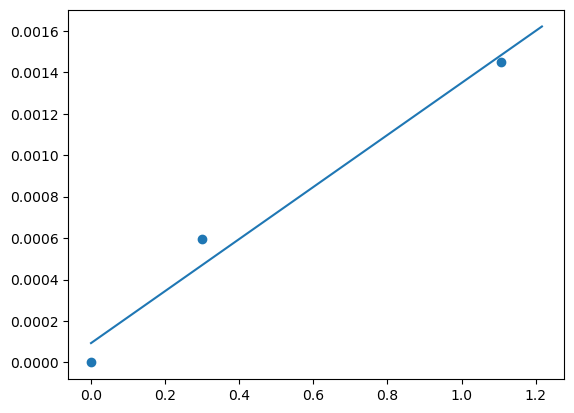

M11 L-alanine ASPARAGINE 0.005748535254331529 0.004845792406106117 0.8429612399880138


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


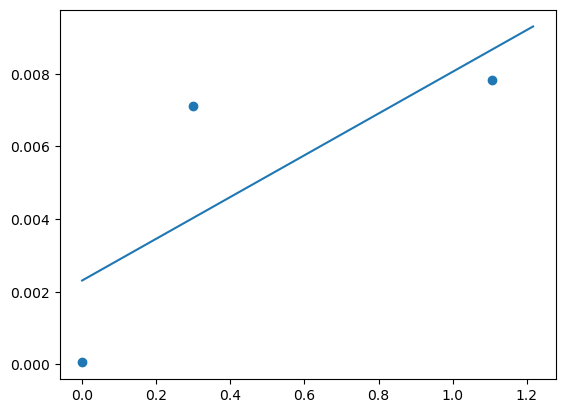

M11 L-alanine ASPARTATE nan nan nan


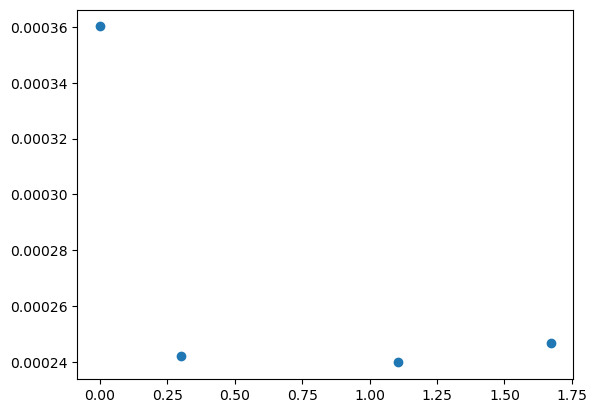

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine LYSINE 0.004241171891937304 0.0031596947587538464 0.7450051163360288


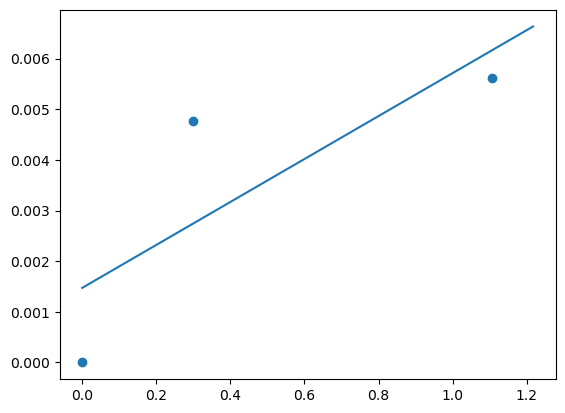

M11 L-alanine LACTATE nan nan nan


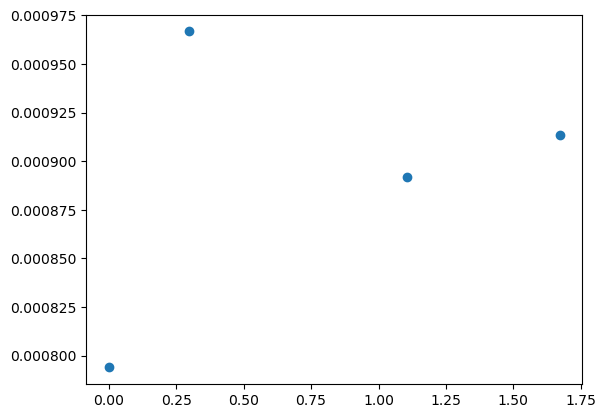

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine HEXOSES including Glucose and Fructose 0.007639901303113679 inf inf


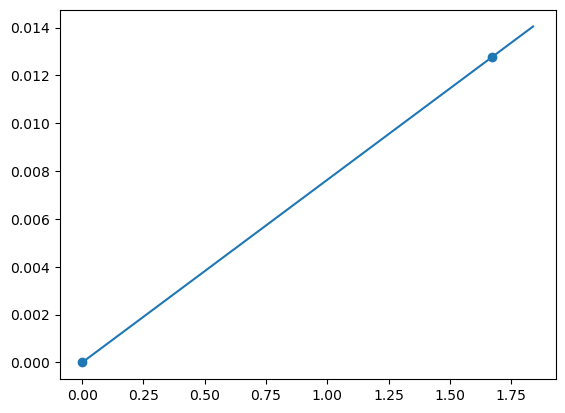

M11 L-alanine NAD 6.984773649709687e-05 1.3176471530638986e-05 0.18864564825499605


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


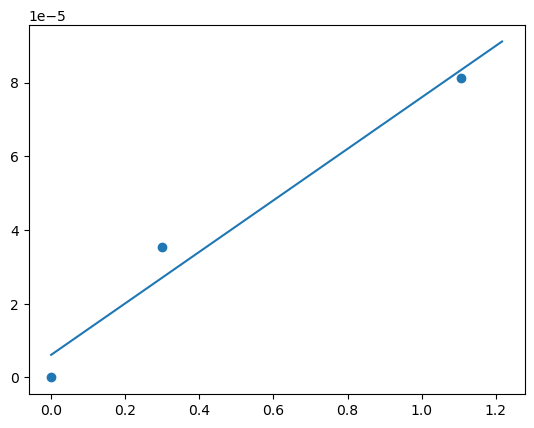

M11 L-alanine SUCCINATE 0.010569656574585744 0.0026528408959446757 0.25098647976163296


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


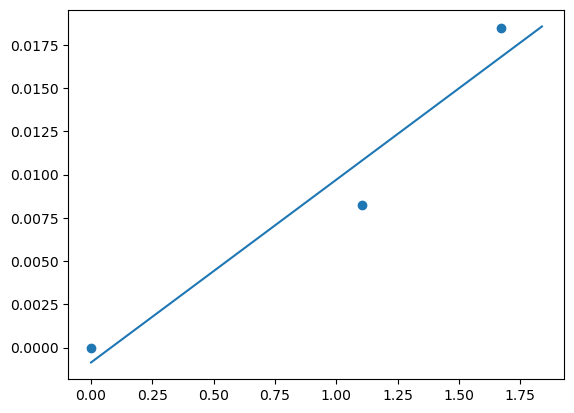

M11 L-alanine MALATE 0.003237204994053648 0.0015576717238003023 0.48117796885324093


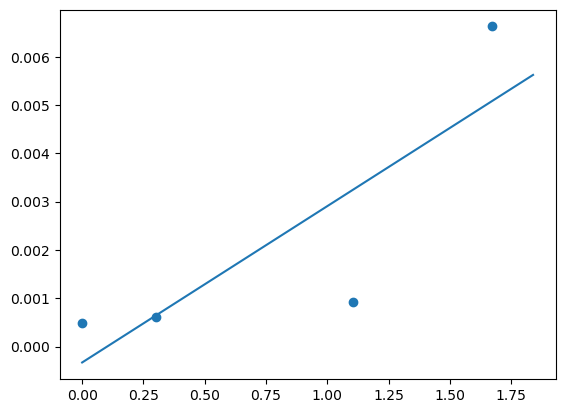

M11 L-alanine CIS-ACONITATE 0.0008013294425863586 8.961923196314918e-05 0.11183818689338998


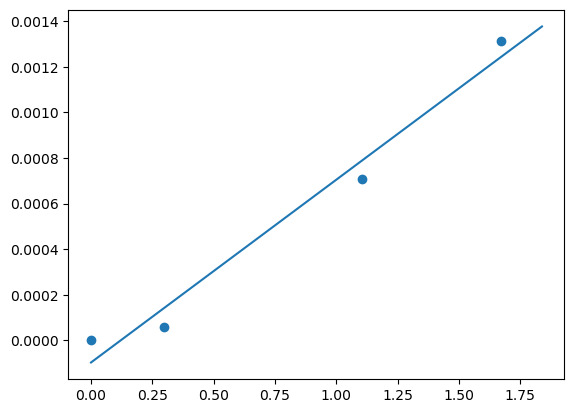

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine CITRATE 0.0041026161864174725 inf inf


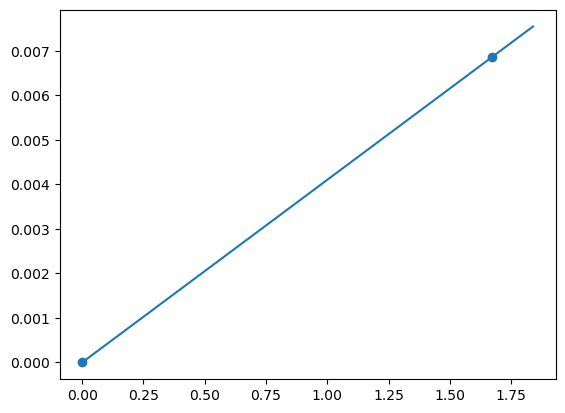

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


M11 L-alanine ISOCITRATE 0.00031193714414818333 0.00011845922294903731 0.3797535021759517


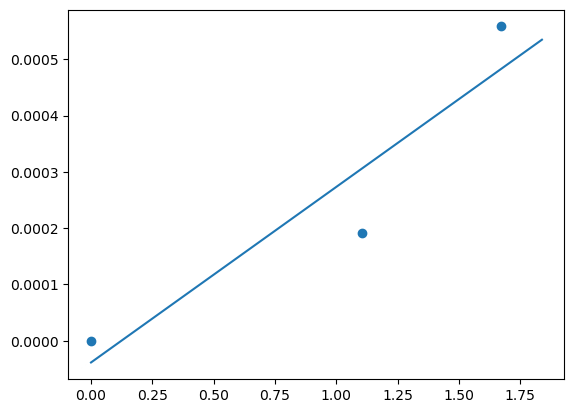

M11 L-alanine TRANS-ACONITATE 1.8823451484561548e-05 4.462363335235912e-06 0.23706403360169168


/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


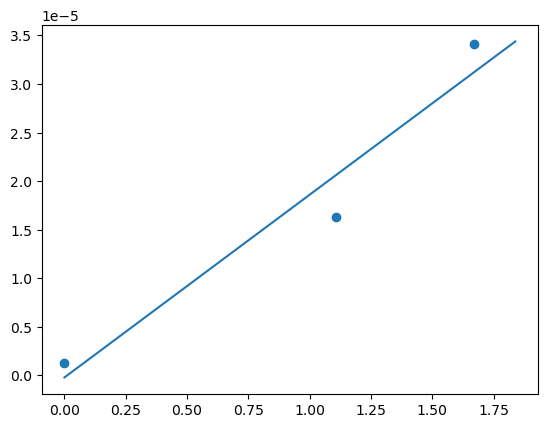

In [30]:
data = []
plot = True
data_rate = []

for m in dfl.M.unique():
    for met in dfl.Metabolite.unique():
        
        idx = (dfl.M == m) & (dfl.Metabolite == met) & (dfl.Timepoint != 4) & ~control_idx_l
        dfi = dfl.loc[idx,['Concentration', 'Hours', 'Carbon source', 'Timepoint']].copy()
        dfi.sort_values('Hours', inplace=True)
        # print(m, met)
        # print(dfi)
        dfi.dropna(axis = 0, inplace=True)
    
        if not len(dfi):
            continue
        cs = dfi['Carbon source'].values[0]  
        # if len(dfi) == 1:
        # Add medium concentrations
        medium_values = control_df.loc[control_df['Carbon source']==cs, met].values
        if np.isfinite(medium_values).sum() == 0:
            dfi.loc[-1,:] = [0, 0, cs, 0]
        else:
            dfi.loc[-1,:] = [np.nanmean(medium_values), 0, cs, 0]
            
        if (2 in dfi.Timepoint.values) and (3 in dfi.Timepoint.values):
            t3_value = dfi.loc[dfi.Timepoint == 3, 'Concentration'].values[0]
            t2_value = dfi.loc[dfi.Timepoint == 2, 'Concentration'].values[0]
            if  t3_value < t2_value:
                # Indicates that the matbolite is being reconsumed, discard last point from estimating rates
                dfi = dfi.loc[dfi.Timepoint != 3, :]

        # # If medium values are larger than values at t1
        # if len(dfi.loc[dfi.Timepoint > 0, :]) > 1:
            
        #     non_medium_conc = dfi.loc[dfi.Timepoint > 0,'Concentration'].values
        #     if (dfi.loc[-1, 'Concentration'] > non_medium_conc[0]) and (non_medium_conc[0] < non_medium_conc[1]):
        #         dfi.drop(index = [-1], inplace = True)
        #         print('Drop 0', m, met, cs)
                # The maximum value 
        # print(dfi)
        time_conc_dict = {key: (value['Hours'], value['Concentration']) for key, value in dfi[['Hours', 'Concentration']].to_dict(orient = 'index').items()}
        rel = M_to_rel[m]
        gdw = gdw_df[['Hours', rel]].copy()
        gdw.dropna(inplace=True)
        m_data = []
        for index, val_tuple in time_conc_dict.items():
            time, conc = val_tuple
            # Calculate cumulative OD
            tidx = gdw.Hours < time+0.5
            conc_mM = conc * 1e-3
            cum_dw = scipy.integrate.simpson(gdw.loc[tidx, rel], gdw.loc[tidx, 'Hours'])
            data.append([m, met, time, conc_mM, cum_dw, cs])
            m_data.append([time, conc_mM, cum_dw])

        m_df = pd.DataFrame(m_data, columns = ['Time', 'Concentration [mM]', 'Integral of biomass [gDW*h/L]'])
        popt, pcov = scipy.optimize.curve_fit(lambda x,a,b: a*x+b, m_df['Integral of biomass [gDW*h/L]'], 
                                              m_df['Concentration [mM]'])
        rate = popt[0]
        rate_std = np.sqrt(pcov[0,0])

        # Check rate without t0
        if len(m_df)>2:
            idx0 = m_df.Time == 0 
            popt0, pcov0 = scipy.optimize.curve_fit(lambda x,a,b: a*x+b, m_df.loc[~idx0, 'Integral of biomass [gDW*h/L]'], 
                                              m_df.loc[~idx0, 'Concentration [mM]'])
            if np.sign(rate)!= np.sign(popt0[0]):
                rate, rate_std = np.nan, np.nan
        data_rate.append([m, met, cs, rate, rate_std])
        if plot:
            print(m, cs, met, rate, rate_std, rate_std/np.abs(rate) )
            max_x = m_df['Integral of biomass [gDW*h/L]'].max()*1.1
            plt.scatter(m_df['Integral of biomass [gDW*h/L]'], m_df['Concentration [mM]'])
            x = np.linspace(0,max_x, 4)
            plt.plot(x, rate*x + popt[1])
            plt.show()
df_conc_biomass = pd.DataFrame(data, columns = ['M', 'Metabolite', 'Time', 'Concentration [mM]', 'Integral of biomass [gDW*h/L]', 'Carbon source'])
df_rate = pd.DataFrame(data_rate, columns = ['M', 'Metabolite', 'Carbon source', 'Rate [mmol/gDW/h]', 'Rate std'])

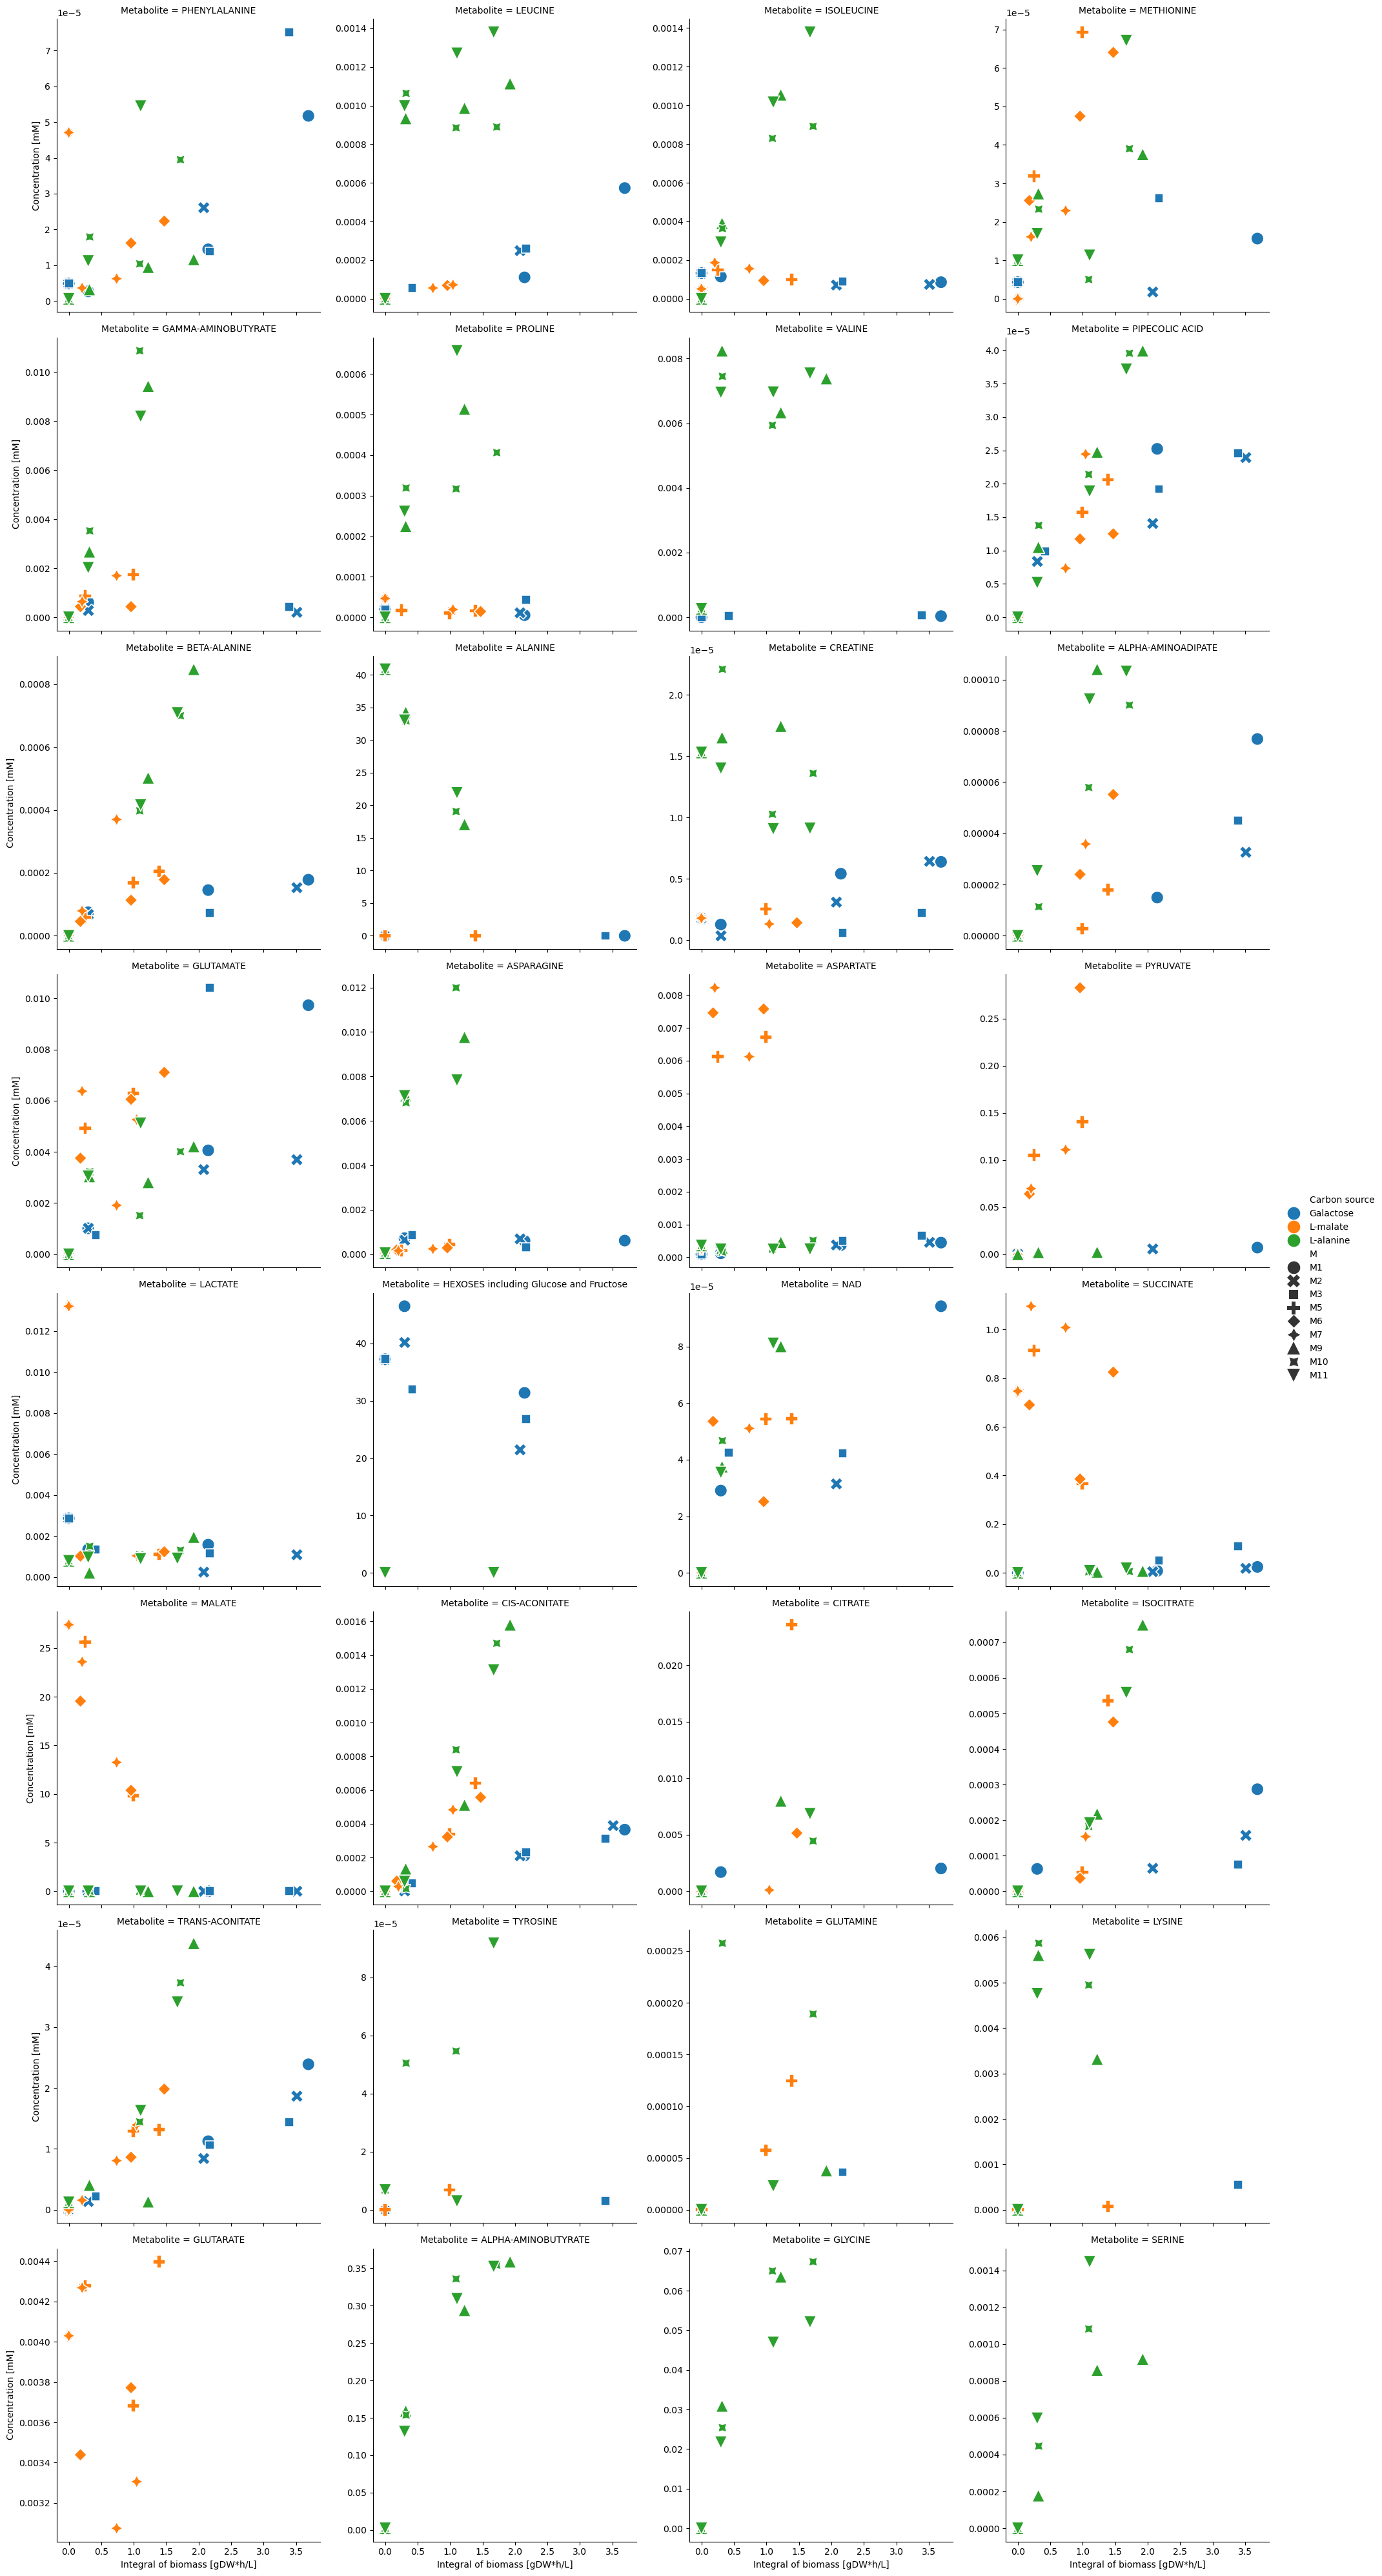

In [31]:
sns.relplot(data = df_conc_biomass, x = 'Integral of biomass [gDW*h/L]', y = 'Concentration [mM]', col = 'Metabolite', col_wrap=4, facet_kws={'sharey': False}, style = 'M',  hue = 'Carbon source', s = 200)

plt.show()

# Estimate rate per carbon source

In [32]:
df_conc_biomass.loc[idx,:]

Empty DataFrame
Columns: [M, Metabolite, Time, Concentration [mM], Integral of biomass [gDW*h/L], Carbon source]
Index: []

Galactose PHENYLALANINE


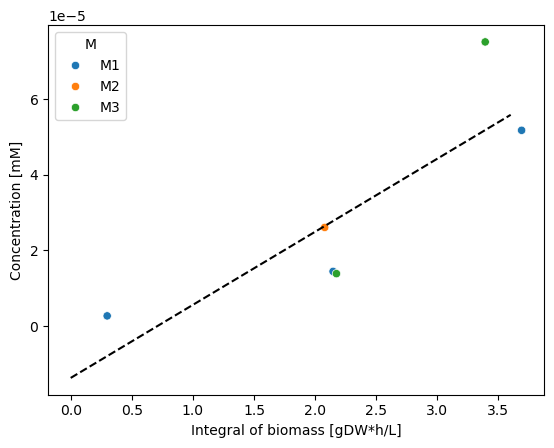

Galactose LEUCINE


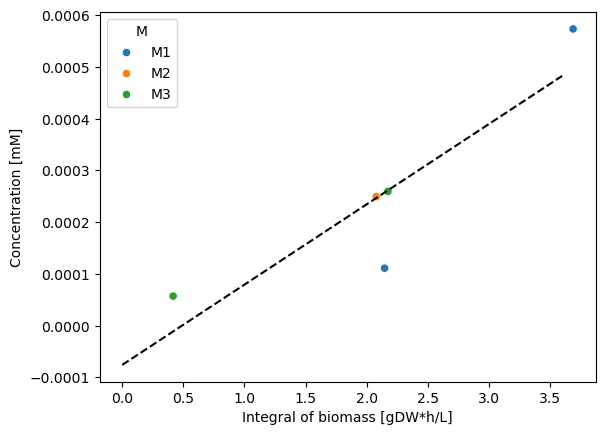

Galactose ISOLEUCINE


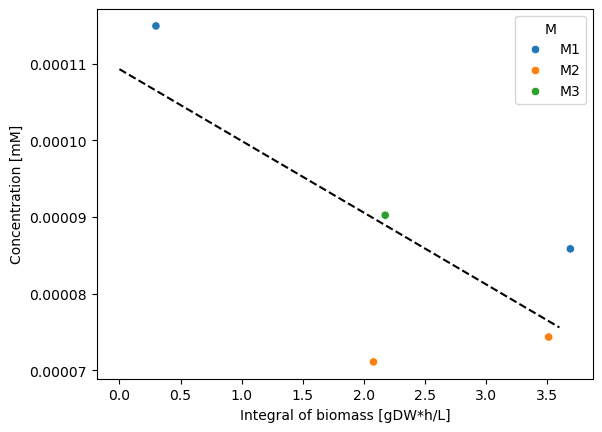

Galactose GAMMA-AMINOBUTYRATE


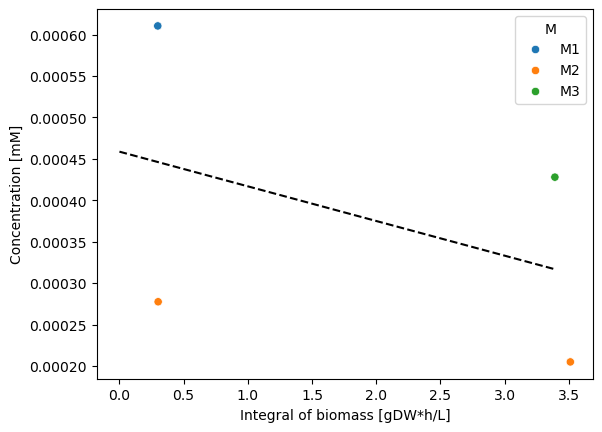

Galactose PIPECOLIC ACID


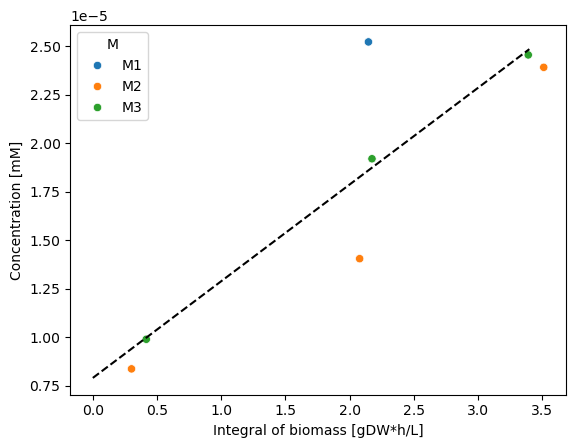

Galactose BETA-ALANINE


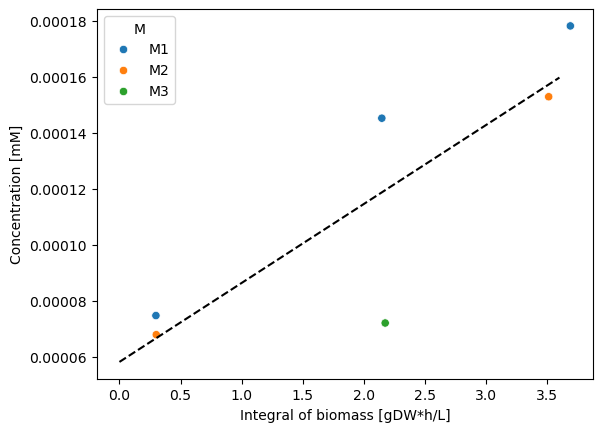

Galactose CREATINE


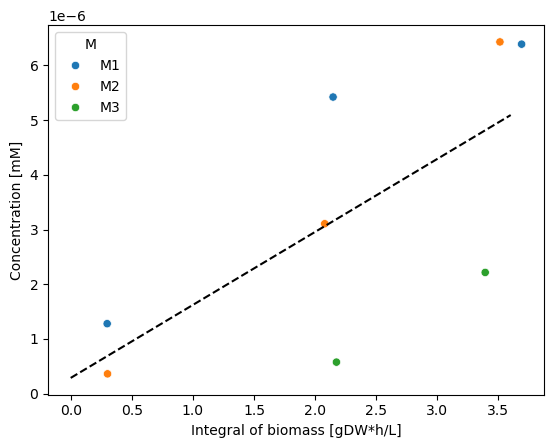

Galactose ALPHA-AMINOADIPATE


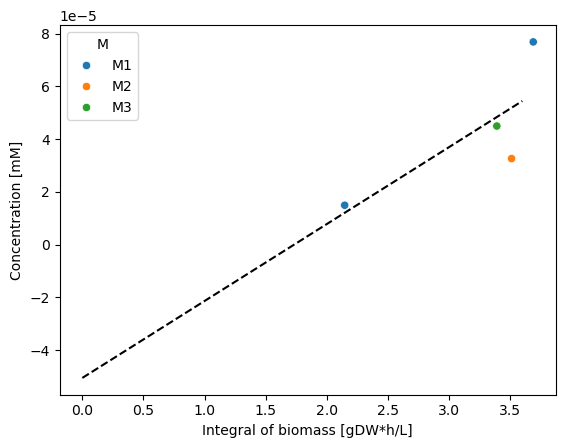

Galactose GLUTAMATE


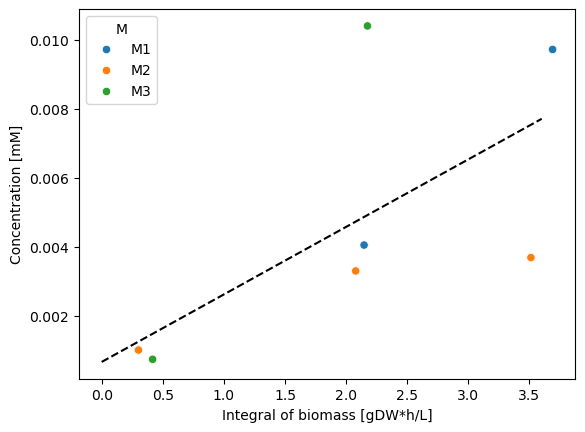

Galactose ASPARAGINE


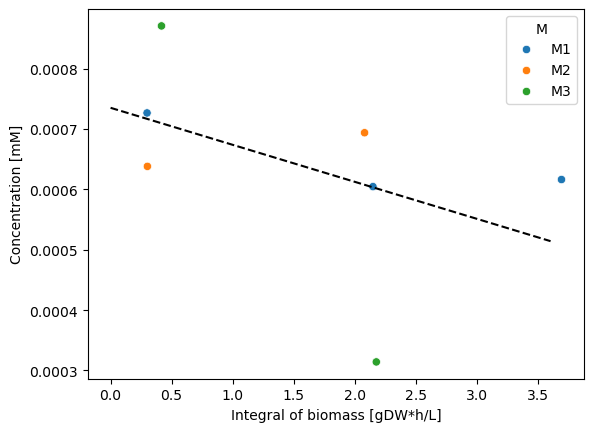

Galactose ASPARTATE


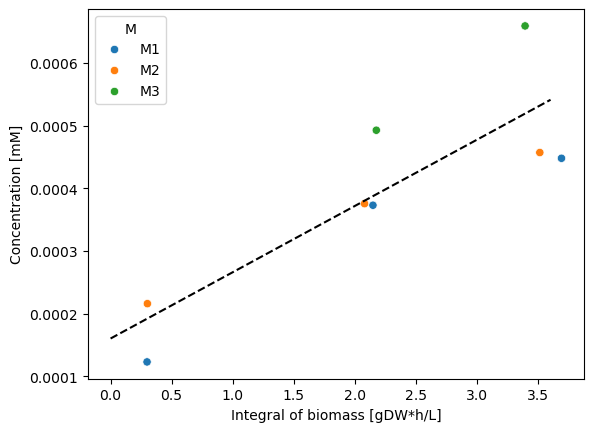

Galactose LACTATE


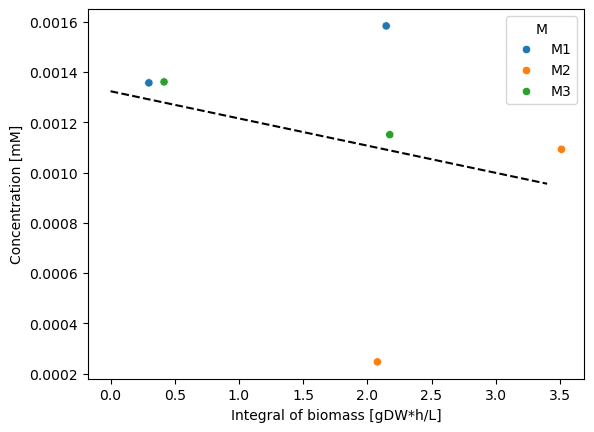

Galactose HEXOSES including Glucose and Fructose


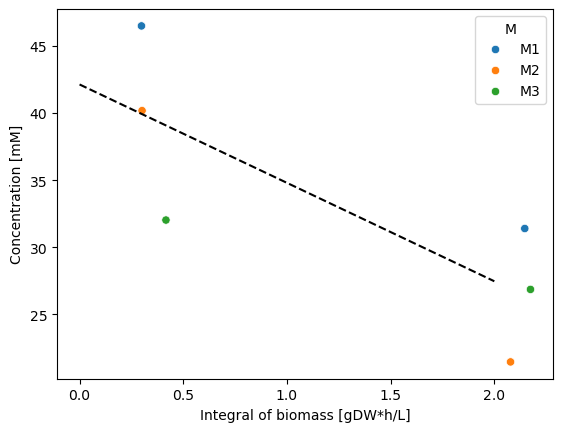

Galactose NAD


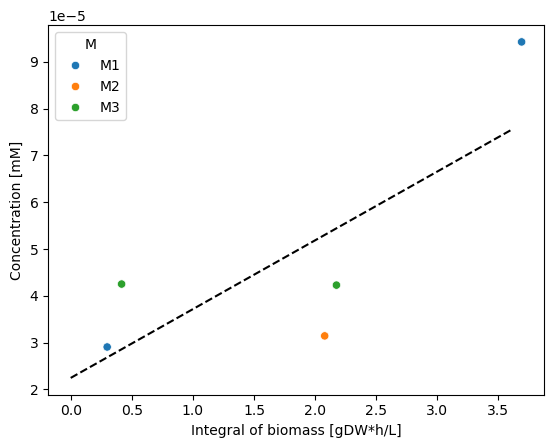

Galactose SUCCINATE


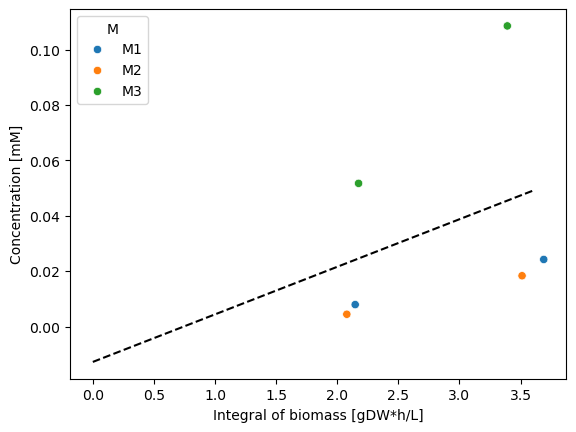

Galactose MALATE


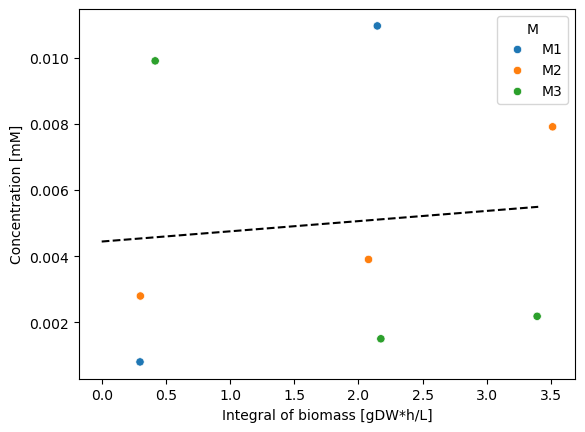

Galactose CIS-ACONITATE


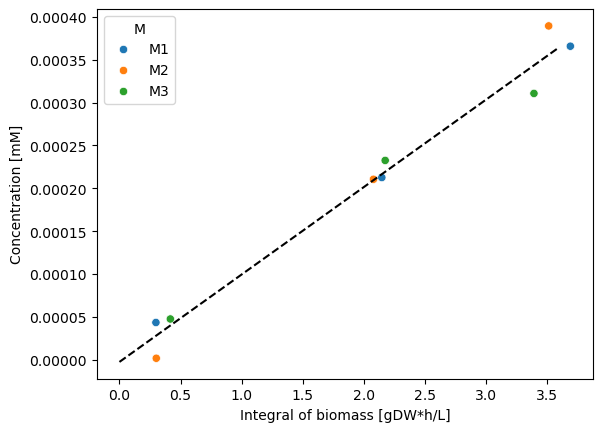

Galactose ISOCITRATE


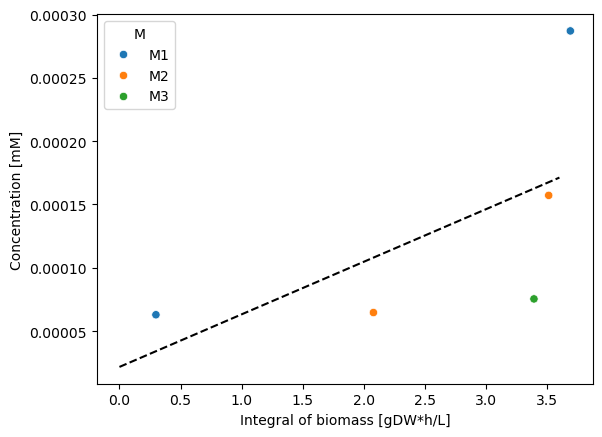

Galactose TRANS-ACONITATE


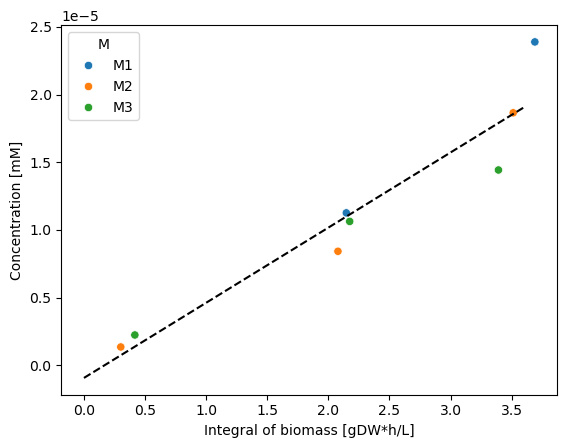

L-malate PHENYLALANINE


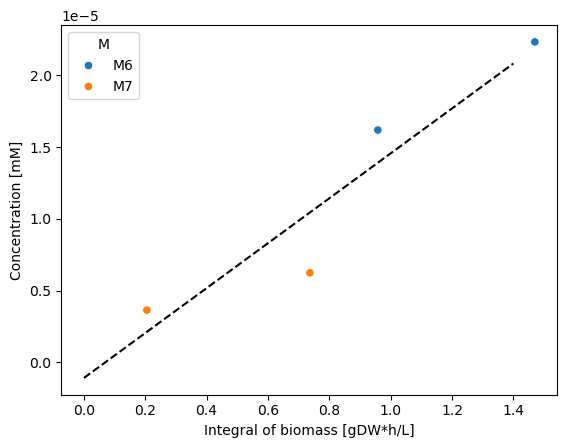

L-malate ISOLEUCINE


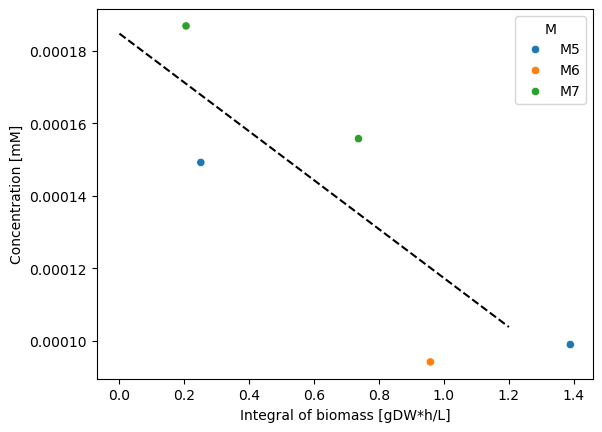

L-malate METHIONINE


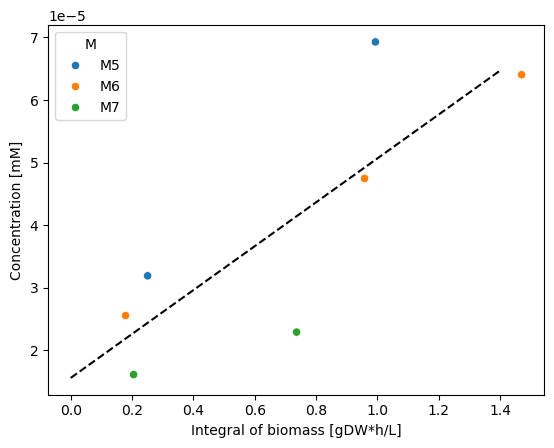

L-malate GAMMA-AMINOBUTYRATE


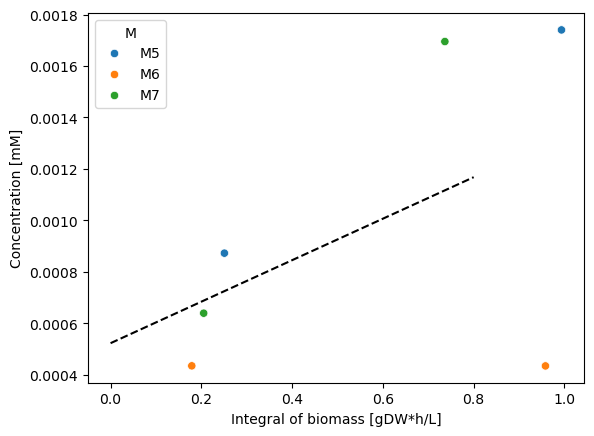

L-malate PROLINE


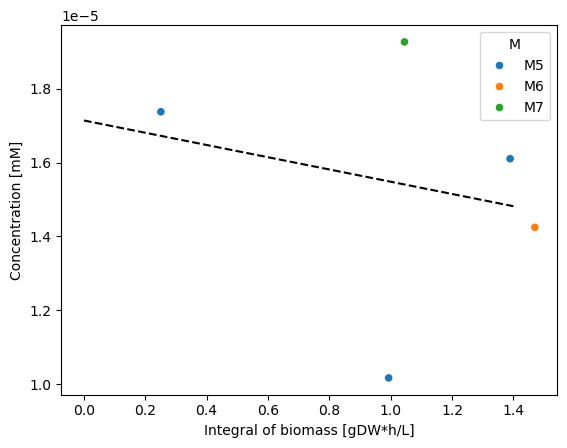

L-malate PIPECOLIC ACID


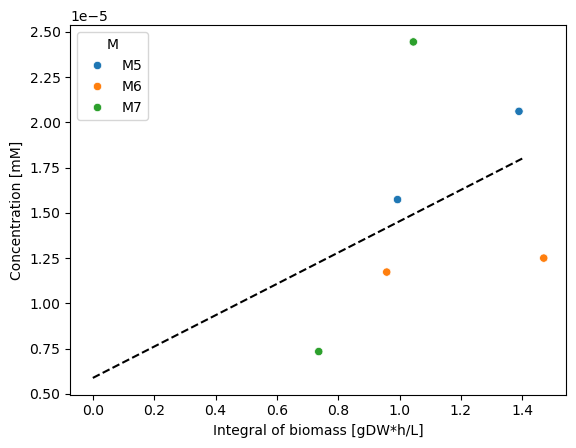

L-malate BETA-ALANINE


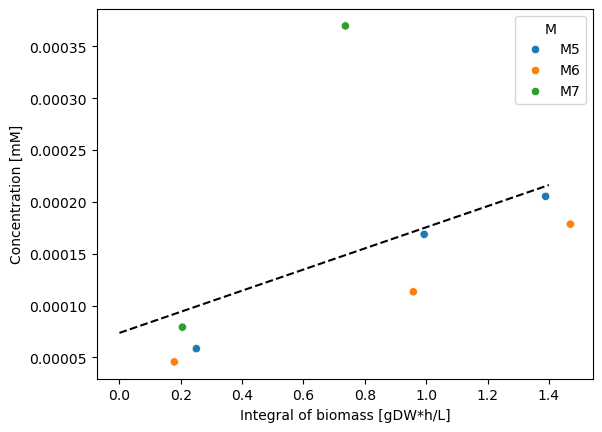

L-malate ALPHA-AMINOADIPATE


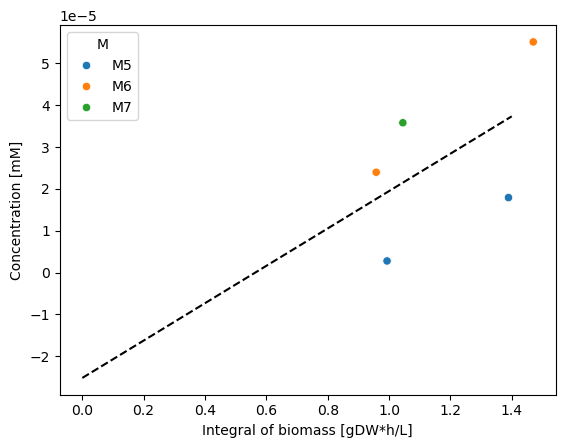

L-malate GLUTAMATE


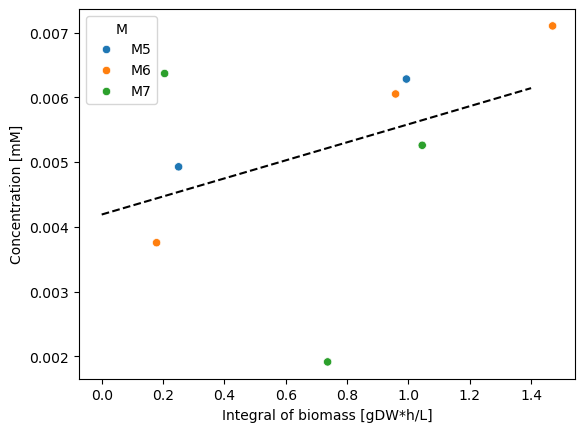

L-malate ASPARAGINE


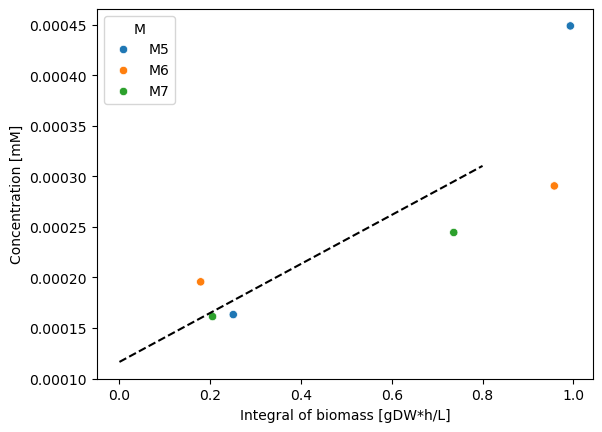

L-malate ASPARTATE


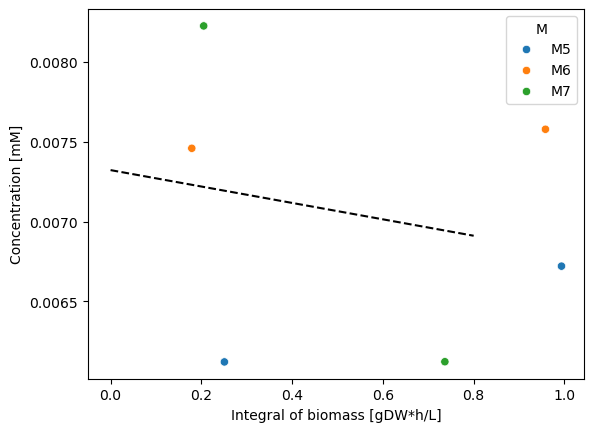

L-malate PYRUVATE


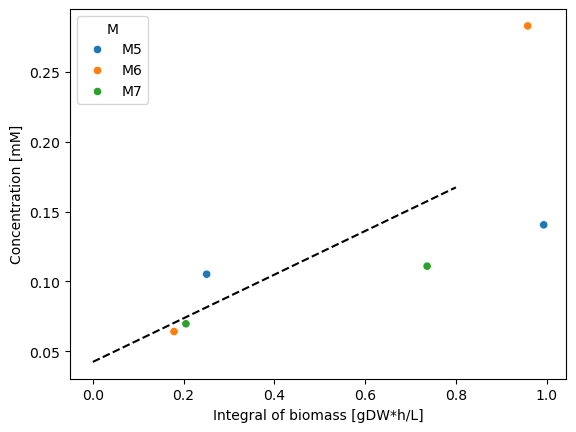

L-malate LACTATE


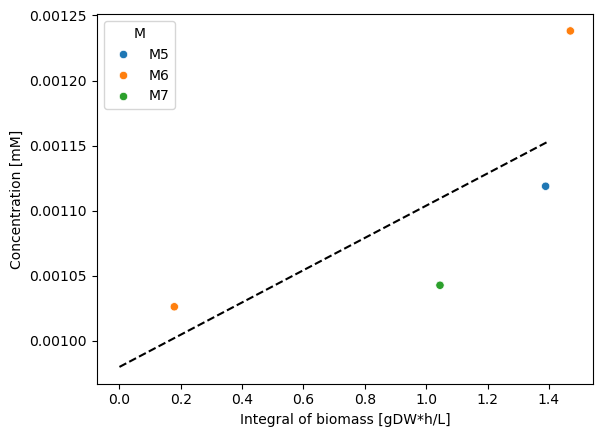

L-malate NAD


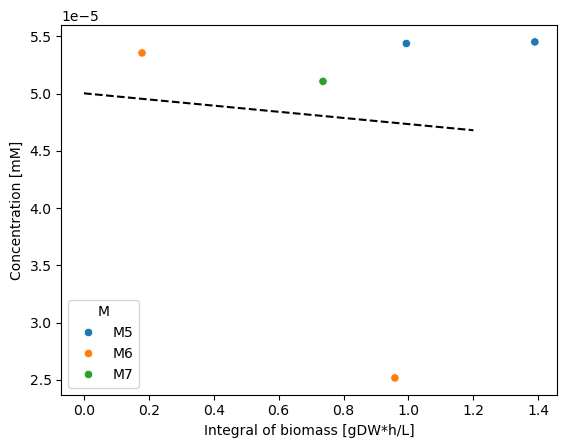

L-malate SUCCINATE


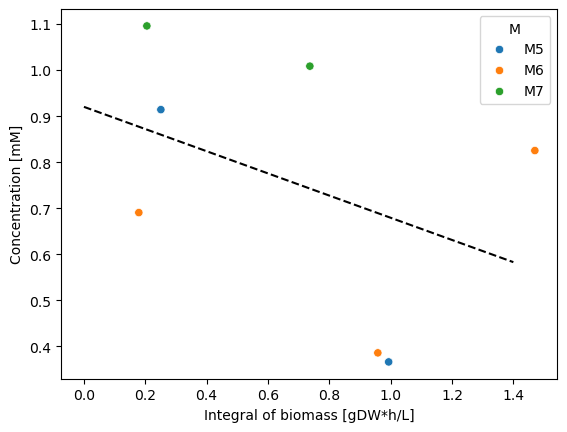

L-malate MALATE


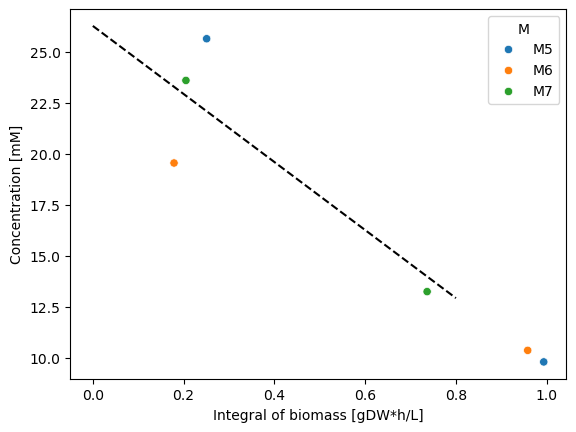

L-malate CIS-ACONITATE


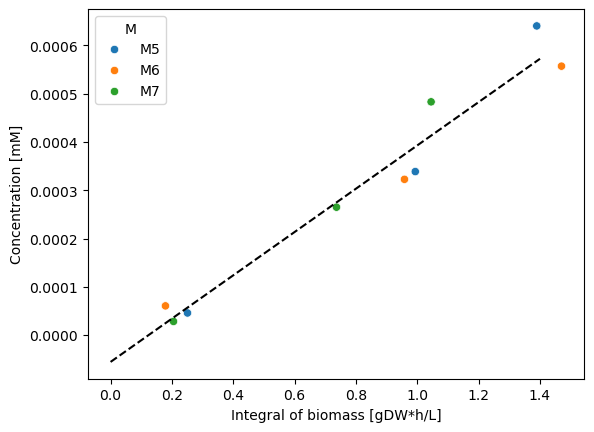

L-malate ISOCITRATE


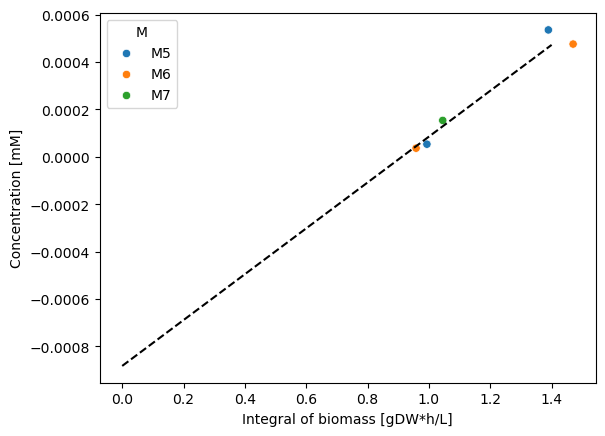

L-malate TRANS-ACONITATE


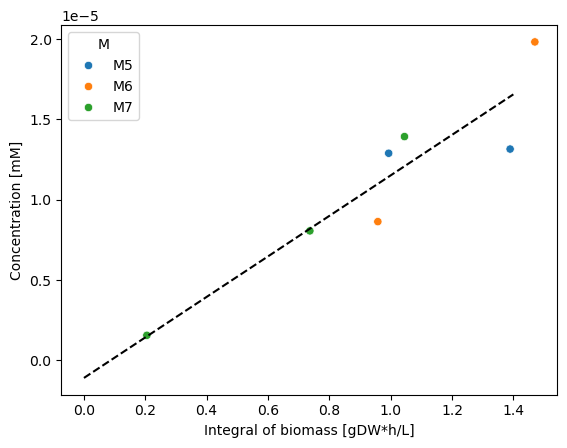

L-malate GLUTARATE


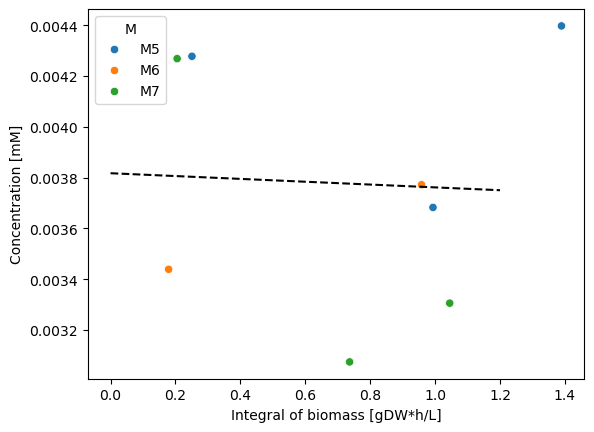

L-alanine PHENYLALANINE


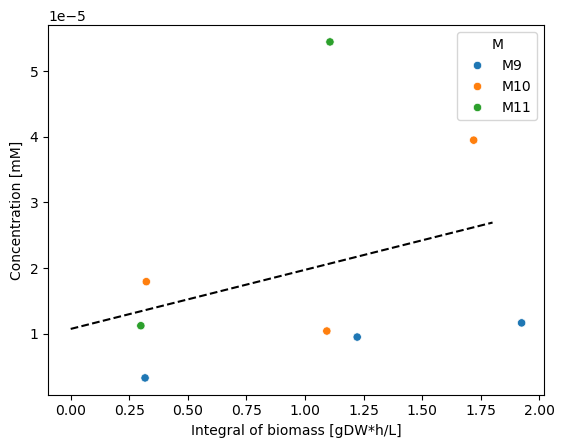

L-alanine LEUCINE


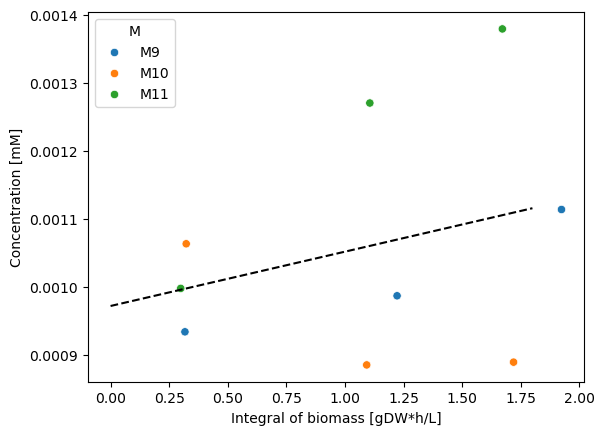

L-alanine ISOLEUCINE


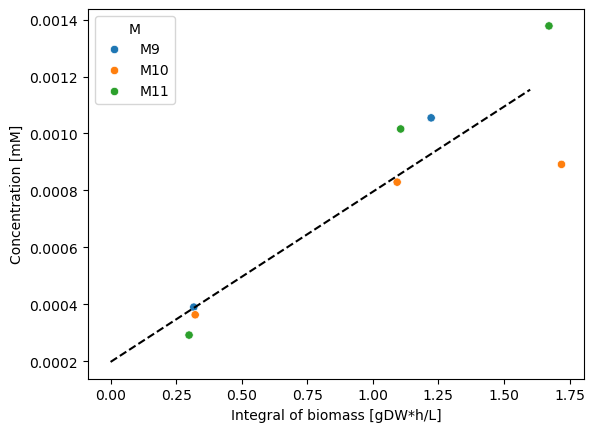

L-alanine METHIONINE


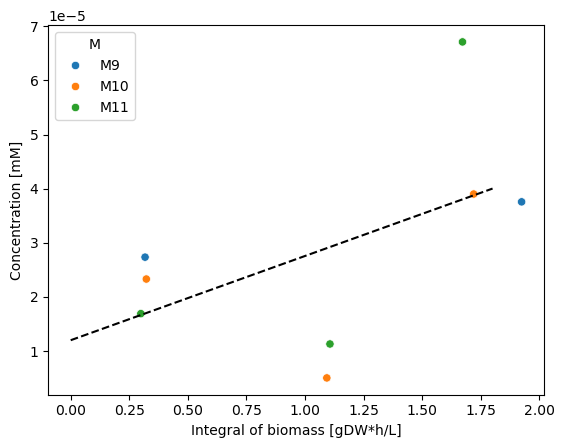

L-alanine GAMMA-AMINOBUTYRATE


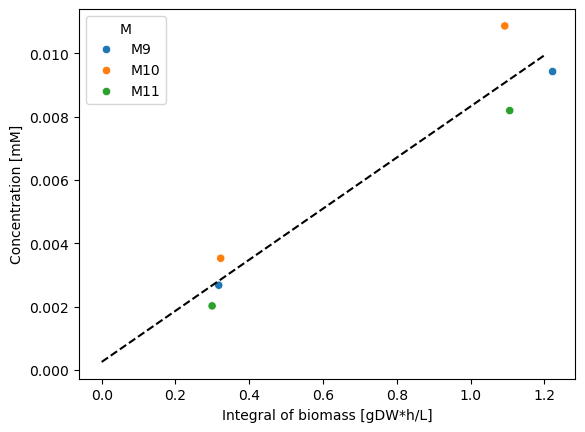

L-alanine PROLINE


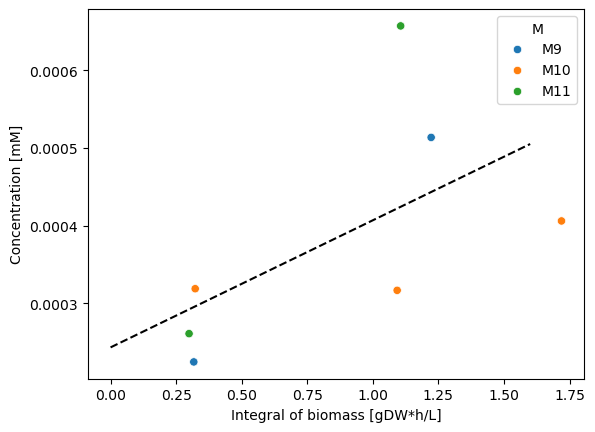

L-alanine VALINE


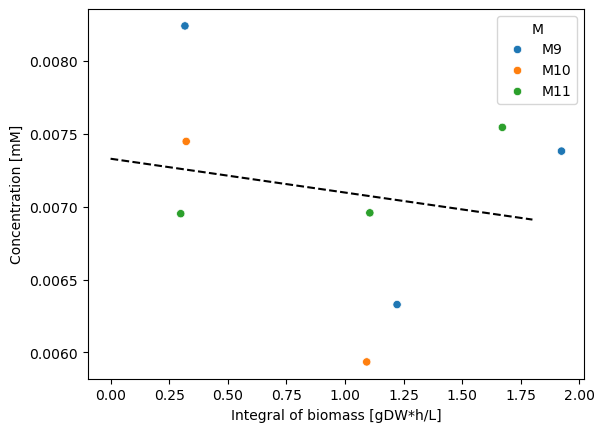

L-alanine PIPECOLIC ACID


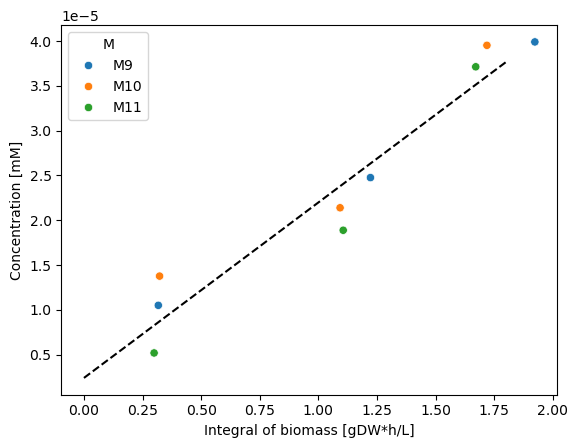

L-alanine BETA-ALANINE


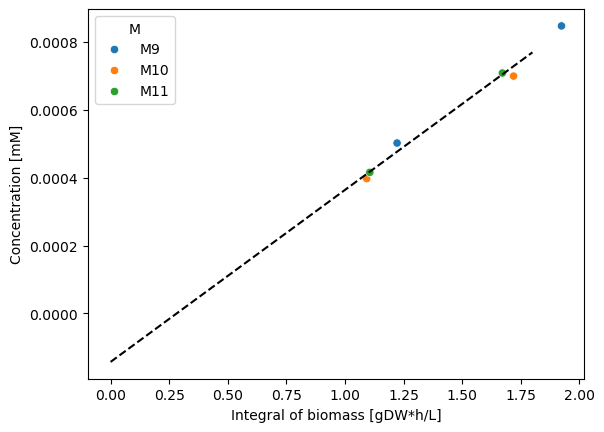

L-alanine ALANINE


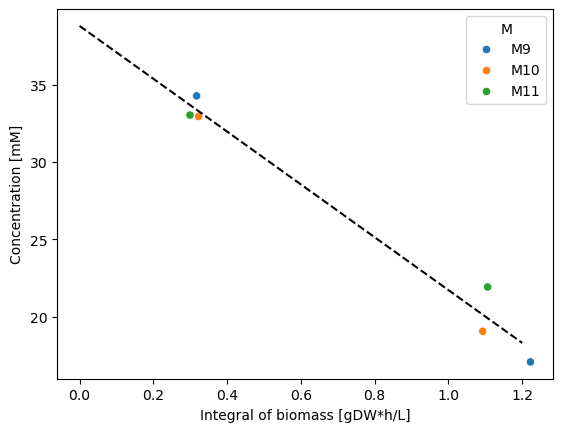

L-alanine CREATINE


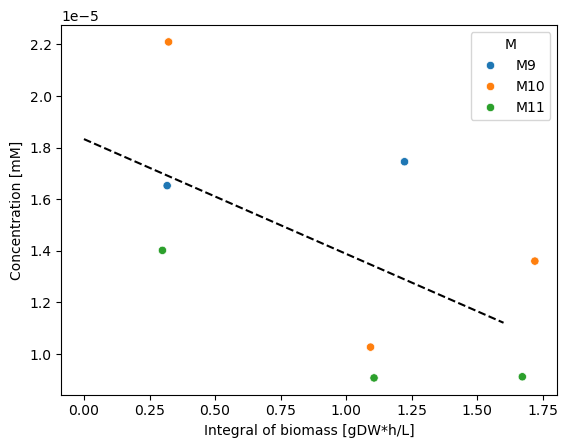

L-alanine ALPHA-AMINOADIPATE


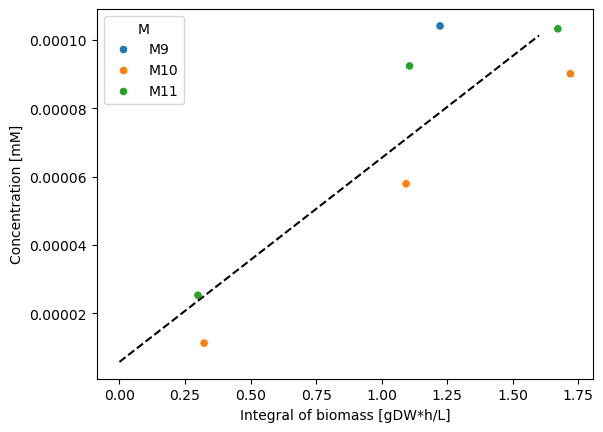

L-alanine GLUTAMATE


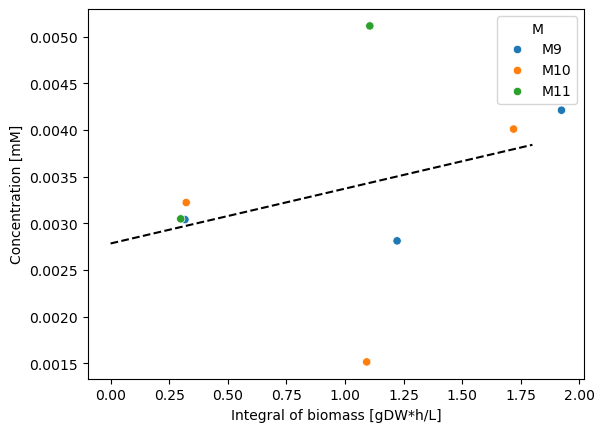

L-alanine ASPARAGINE


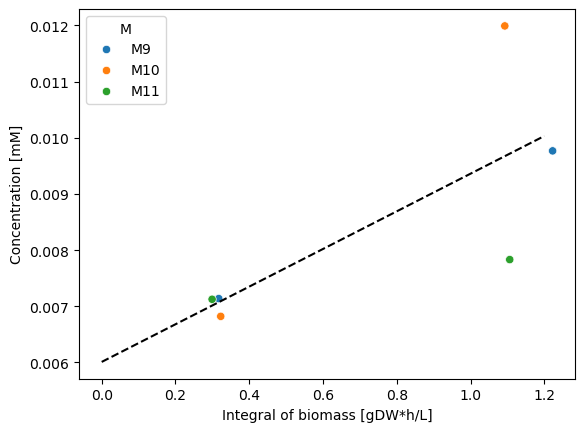

L-alanine ASPARTATE


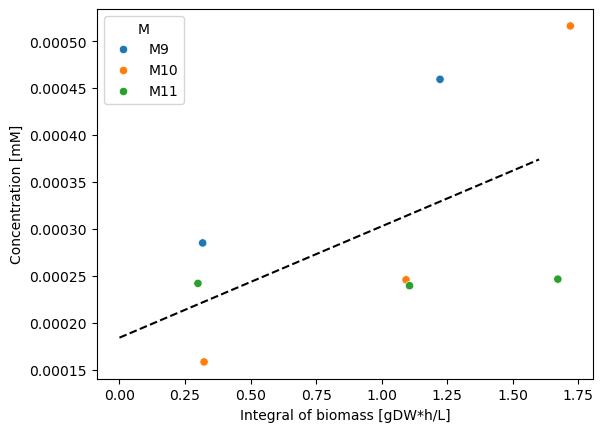

L-alanine LACTATE


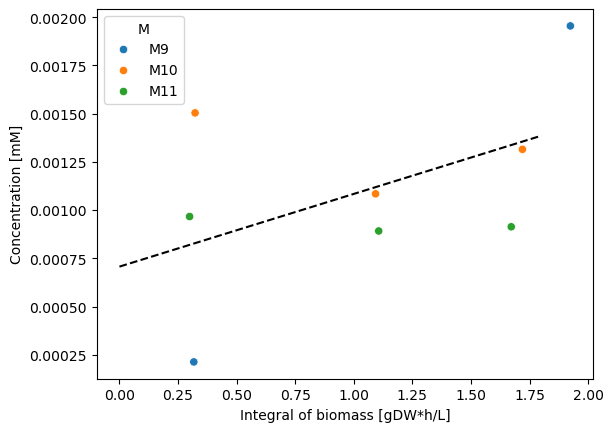

L-alanine NAD


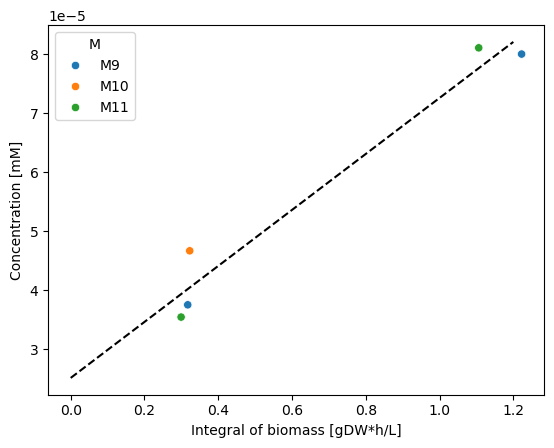

L-alanine SUCCINATE


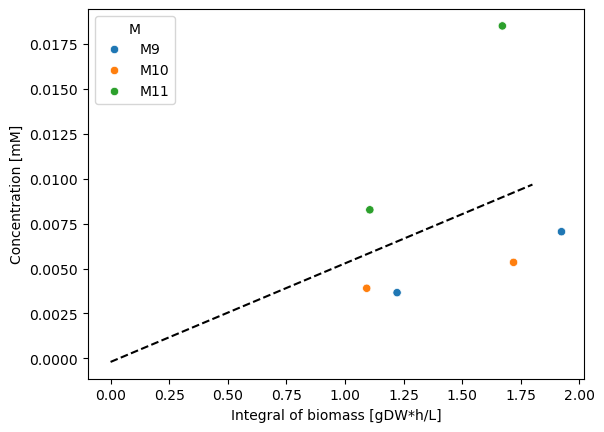

L-alanine MALATE


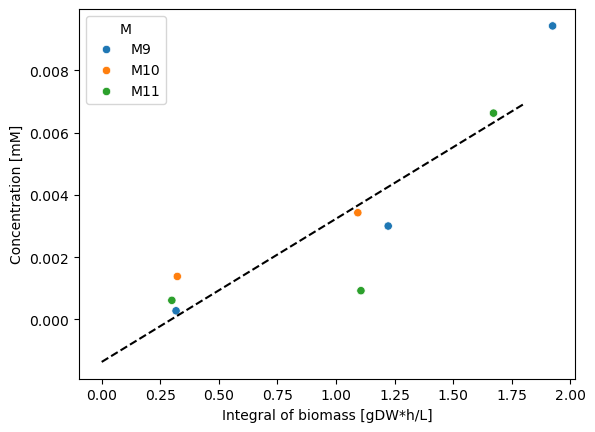

L-alanine CIS-ACONITATE


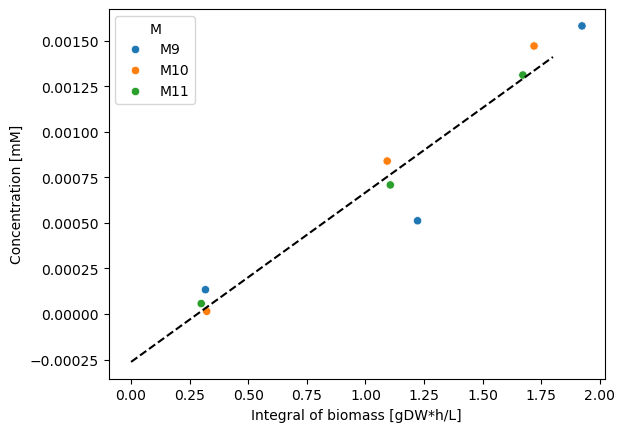

L-alanine ISOCITRATE


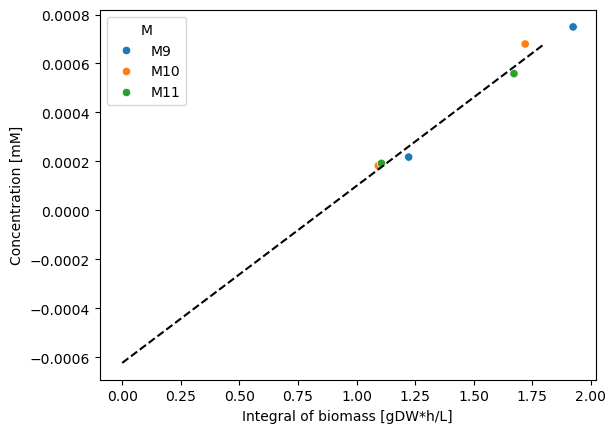

L-alanine TRANS-ACONITATE


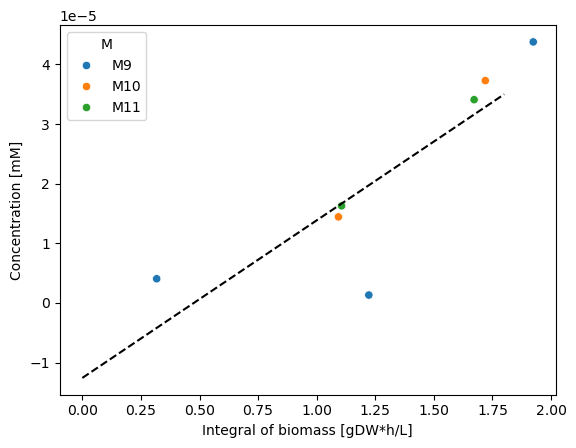

L-alanine TYROSINE


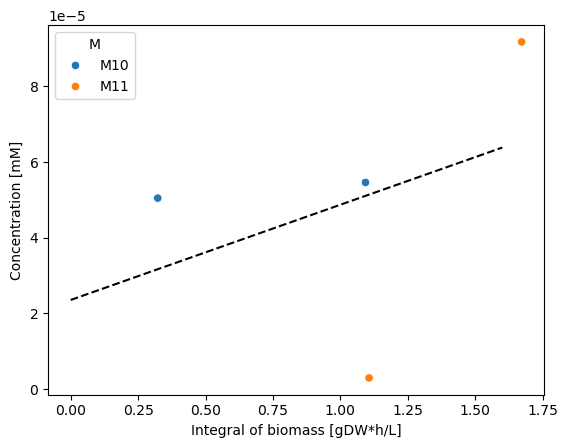

L-alanine GLUTAMINE


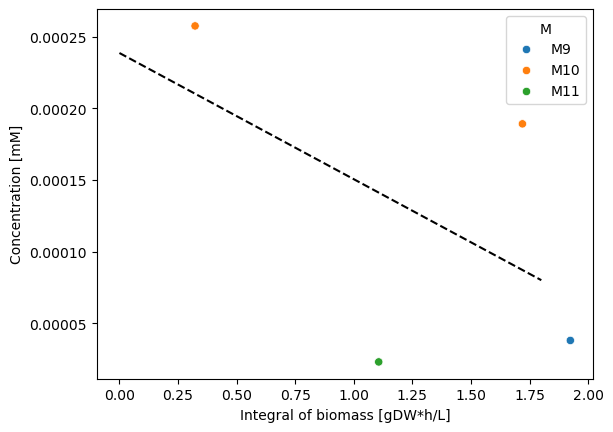

L-alanine LYSINE


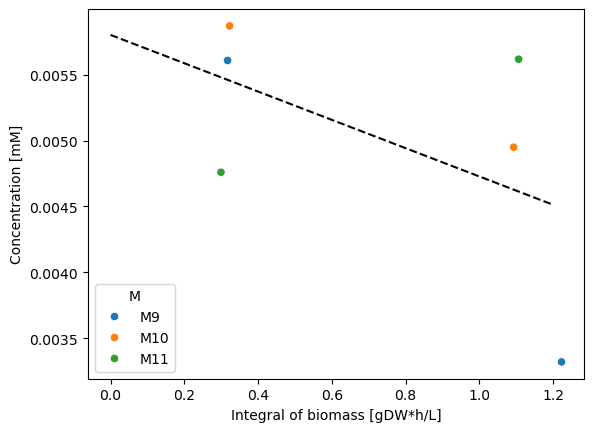

L-alanine ALPHA-AMINOBUTYRATE


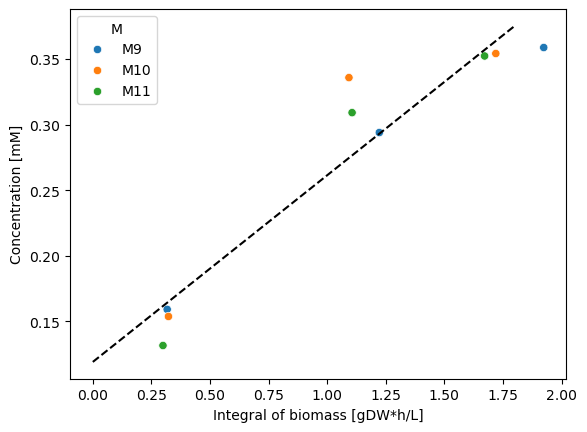

L-alanine GLYCINE


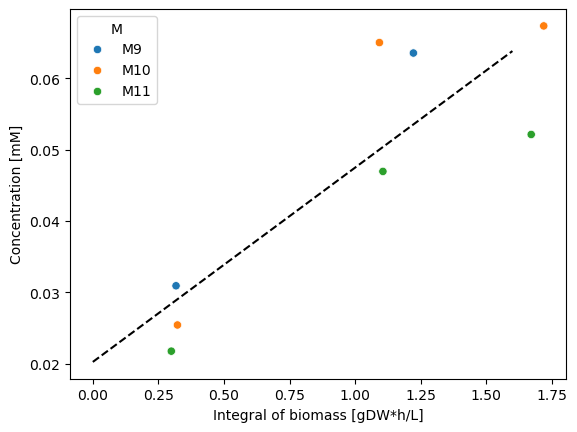

L-alanine SERINE


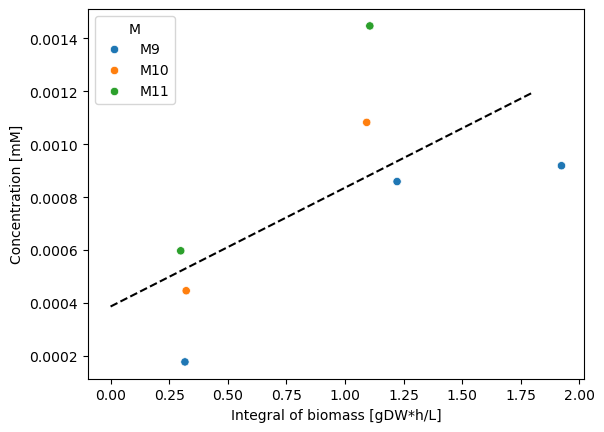

In [33]:
average_rate_data = []
for cs in df_conc_biomass['Carbon source'].unique():
    for m in df_conc_biomass.Metabolite.unique():
        idx = (df_conc_biomass['Carbon source'] == cs) & (df_conc_biomass.Metabolite==m)
        nonmedium_idx = df_conc_biomass.Time > 0
        idx = idx & nonmedium_idx
        if len( df_conc_biomass.loc[idx, 'Concentration [mM]']) > 3:
            print(cs, m)
            ax = sns.scatterplot(data = df_conc_biomass.loc[idx,:], x = 'Integral of biomass [gDW*h/L]', 
                            y = 'Concentration [mM]', hue = 'M')
            popt, pcov = scipy.optimize.curve_fit(lambda x,a,b: (a*x)+b, 
                            df_conc_biomass.loc[idx, 'Integral of biomass [gDW*h/L]'], 
                            df_conc_biomass.loc[idx, 'Concentration [mM]'])
            perr = np.sqrt(np.diag(pcov))
            
            average_rate_data.append([cs, m, popt[0], perr[0], len(df_conc_biomass.loc[idx,:].M.unique()), len(df_conc_biomass.loc[idx,:])])
            x_max = df_conc_biomass.loc[idx,'Integral of biomass [gDW*h/L]'].max()
            x_arr = np.arange(0, x_max, 0.2)
            yfit = popt[1]+popt[0]*x_arr
            ax.plot(x_arr, yfit, ls = '--', c = 'k')
            plt.show()

average_rate_df = pd.DataFrame(average_rate_data, columns = ['Carbon source', 'Metabolite', 'Rate', 'Rate std', 'N bioreactors', 'N samples'])

In [34]:
(average_rate_df['Rate'] > average_rate_df['Rate std']).sum()

42

## Uptake rates

In [35]:
df_rate.loc[(df_rate['Metabolite'] == 'MALATE')&(df_rate['Carbon source'] == 'L-malate'),'Rate [mmol/gDW/h]'].mean()

-17.907915989227387

In [36]:
df_rate.loc[(df_rate['Metabolite'] == 'ALANINE')&(df_rate['Carbon source'] == 'L-alanine'),'Rate [mmol/gDW/h]'].mean()

-18.455545069083623

In [37]:
df_rate.loc[(df_rate['Metabolite'] == 'HEXOSES including Glucose and Fructose')&(df_rate['Carbon source'] == 'Galactose'),'Rate [mmol/gDW/h]'].mean()

-5.837985832488621

In [38]:
ala = df_conc_biomass.loc[(df_conc_biomass['Metabolite'] == 'ALANINE')&(df_conc_biomass['Carbon source'] == 'L-alanine'),:]
np.polyfit(ala['Integral of biomass [gDW*h/L]'], ala['Concentration [mM]'], 1)

array([-18.50519986,  40.17663581])

In [39]:
gal = df_conc_biomass.loc[(df_conc_biomass['Metabolite'] == 'HEXOSES including Glucose and Fructose')&(df_conc_biomass['Carbon source'] == 'Galactose'),:]

In [40]:
np.polyfit(gal['Integral of biomass [gDW*h/L]'], gal['Concentration [mM]']/2, 1)

array([-2.9041662 , 19.62455341])

In [41]:
mal = df_conc_biomass.loc[(df_conc_biomass['Metabolite'] == 'MALATE')&(df_conc_biomass['Carbon source'] == 'L-malate'),:]

In [42]:
np.polyfit(mal['Integral of biomass [gDW*h/L]'], mal['Concentration [mM]'], 1)

array([-17.5771788 ,  26.97793079])

# Get models and estimate metabolite values

In [43]:
model_ez = reframed.load_cbmodel('../../models/e_coli/momentiJO1366.xml')
model_ez.solver = 'gurobi'

In [44]:
reframed.FBA(model_ez)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-19


Objective: 0.7429753865197839
Status: Optimal

In [45]:
model_ez.reactions.R_EX_glc__D_e.lb = 0

In [46]:
cs_to_exchange = {
    'Galactose': 'R_EX_gal_e',
    'L-malate': 'R_EX_mal__L_e',
    'L-alanine': 'R_EX_ala__L_e'
}

# The model is not able to achieve measured growth rate on galactose because of one erroneous enzyme value
- R_GALKr_TG_forward
- Interestingly, the reverse reaction has a much lower value, so I replace the forward value with the reverse

In [47]:
print(model_ez.reactions['R_GALKr_TG_forward'].to_string())
print(model_ez.reactions['R_GALKr_TG_reverse'].to_string())
new_string = "R_GALKr_TG_forward2: M_atp_c + M_gal_c + 0.00037387562982106 M_prot_pool --> M_adp_c + M_gal1p_c + M_h_c"
model_ez.add_reaction_from_str(new_string)
model_ez.remove_reaction('R_GALKr_TG_forward')

R_GALKr_TG_forward: M_atp_c + M_gal_c + 0.0161922306874758 M_prot_pool --> M_adp_c + M_gal1p_c + M_h_c
R_GALKr_TG_reverse: M_adp_c + M_gal1p_c + M_h_c + 0.00037387562982106 M_prot_pool --> M_atp_c + M_gal_c


In [48]:
for met, ex_id in cs_to_exchange.items():
    sol = reframed.FBA(model_ez, constraints={ex_id:(-20,0), 'R_EX_glc__D_e':(0,0)})
    print(met, sol)

Galactose Objective: 0.4904814735282622
Status: Optimal

L-malate Objective: 0.550031902976589
Status: Optimal

L-alanine Objective: 0.3002121695960787
Status: Optimal



In [49]:
model_ez.get_objective()

{'R_BIOMASS_Ec_iJO1366_core_53p95M': 1.0}

# We now use the measured growth rates to define the corresponding uptake rates
The growth rates are estimated from linear regression of the log-scaled OD curves, see notebook in folder with experimental data

In [50]:
growth_rate_dict = {"Galactose": (0.273864,	0.016978), #mean rate, std
                    "L-alanine": (0.207638, 0.005340),
                    "L-malate":	 (0.396022,	0.008710)}

In [51]:
uptake_rate = {}
for met, ex_id in cs_to_exchange.items():
    mu = growth_rate_dict[met][0]
    std = growth_rate_dict[met][1]
    
    sol = reframed.FBA(model_ez, constraints={ex_id:(-20,0), 'R_EX_glc__D_e':(0,0),
                        'R_BIOMASS_Ec_iJO1366_core_53p95M':(mu-std, mu+std)}, objective = {ex_id: 1})
    uptake_rate[ex_id] = sol.fobj
    print(met, sol)

Galactose Objective: -2.7417437680394983
Status: Optimal

L-malate Objective: -8.739156642528238
Status: Optimal

L-alanine Objective: -4.812664914351242
Status: Optimal



In [52]:
sol.fobj

-4.812664914351242

In [53]:
measured_metabolite_ids = [f'M_{m_id}_c' for m_id in mapping_dict.values() if isinstance(m_id, str)]

In [54]:
# uptake_rate = {
#     'R_EX_gal_e': -5,
#     'R_EX_mal__L_e': -17,
#     'R_EX_ala__L_e': -18,
# }
sp_dict = {}
for cs, ex_id in cs_to_exchange.items():
    sp_dict[cs] = leakage_reframed.estimate_shadow_prices(model_ez, constraints={ex_id:(uptake_rate[ex_id], 0)}, delta = 0.01, metabolites=measured_metabolite_ids)
        

In [55]:
mv_df = pd.DataFrame(sp_dict)*-1

In [56]:
mv_df

Galactose  L-malate  L-alanine
M_gbbtn_c          NaN       NaN        NaN
M_crn_c            NaN       NaN        NaN
M_acon_C_c    0.076557  0.068156   0.074846
M_cit_c       0.076556  0.068094   0.074845
M_fru_c       0.103446  0.104735   0.114375
M_icit_c      0.076558  0.068217   0.074847
M_lac__L_c    0.051713  0.053292   0.051374
M_mal__L_c    0.051728  0.044950   0.050937
M_nad_c       0.374442  0.386199   0.395660
M_succ_c      0.055866  0.048986   0.055095
M_acon_T_c    0.076557  0.068156   0.074846
M_asn__L_c    0.056945  0.051653   0.055106
M_asp__L_c    0.052766  0.045044   0.050914
M_ala_B_c     0.051734  0.044220   0.049877
M_4abut_c     0.074500  0.066893   0.072754
M_glu__L_c    0.075524  0.067246   0.073785
M_gln__L_c    0.079669  0.071687   0.077948
M_gly_c       0.026433  0.030837   0.028144
M_ile__L_c    0.131459  0.120587   0.124747
M_leu__L_c    0.118145  0.122628   0.113449
M_lys__L_c    0.123149  0.111500   0.117444
M_met__L_c    0.156052  0.156456   0.151952
M_phe__L_c    0.176923  0.171445   0.187482
M_pro__L_c    0.095190  0.084803   0.091461
M_ser__L_c    0.044558  0.046247   0.046820
M_tyr__L_c    0.169685  0.164569   0.180208
M_val__L_c    0.094212  0.091868   0.090454
M_ala__L_c    0.047586  0.044121   0.045698
M_pyr_c       0.039306  0.036935   0.038458
M_citr__L_c   0.105620  0.100133   0.101901
M_his__L_c    0.111432  0.120297   0.119302
M_f6p_c       0.104482  0.105814   0.115416
M_g6p_c       0.104482  0.105818   0.115416

# Turnover

In [57]:
turnover_dict = {}
for cs, ex_id in cs_to_exchange.items():
    solution = reframed.pFBA(model_ez, constraints={ex_id:(uptake_rate[ex_id], 0)})
    turnover = solution.get_metabolites_turnover(model_ez)
    turnover_dict[cs] = {m: turnover[m] for m in measured_metabolite_ids}
    print(cs)
    solution.show_values('BIO')
    # solution.show_values(ex_id)
    solution.show_values('R_EX')
    print("####")

Galactose
R_BIOMASS_Ec_iJO1366_core_53p95M  0.256886
R_EX_ca2_e   -0.00133709
R_EX_cl_e    -0.00133709
R_EX_co2_e    5.90571
R_EX_cobalt2_e -6.42215e-06
R_EX_cu2_e   -0.000182132
R_EX_fe2_e   -0.00412585
R_EX_gal_e   -2.74174
R_EX_h_e      2.36033
R_EX_h2o_e    12.69
R_EX_k_e     -0.0501423
R_EX_meoh_e   5.13772e-07
R_EX_mg2_e   -0.00222849
R_EX_mn2_e   -0.000177508
R_EX_mobd_e  -3.31383e-05
R_EX_nh4_e   -2.77458
R_EX_ni2_e   -8.29742e-05
R_EX_o2_e    -5.35754
R_EX_pi_e    -0.2478
R_EX_so4_e   -0.0647892
R_EX_zn2_e   -8.75981e-05
####
L-malate
R_BIOMASS_Ec_iJO1366_core_53p95M  0.387312
R_EX_ca2_e   -0.00201596
R_EX_cl_e    -0.00201596
R_EX_co2_e    19.0581
R_EX_cobalt2_e -9.6828e-06
R_EX_cu2_e   -0.000274604
R_EX_fe2_e   -0.00622062
R_EX_h_e     -13.9196
R_EX_h2o_e    20.5478
R_EX_k_e     -0.0756006
R_EX_mal__L_e -8.73916
R_EX_meoh_e   7.74624e-07
R_EX_mg2_e   -0.00335993
R_EX_mn2_e   -0.000267633
R_EX_mobd_e  -4.99632e-05
R_EX_nh4_e   -4.18329
R_EX_ni2_e   -0.000125102
R_EX_o2_e    -9

# Make table

In [58]:
data = []
Nc = []
mass = []
turnover_list = []
bigg_id_list = []
for _, row in df_rate.iterrows():
    cs = row['Carbon source']
    met = row['Metabolite']
    bigg_id = mapping_dict[met]
    if isinstance(bigg_id, str):
        m_id = f'M_{bigg_id}_c'
        data.append(-sp_dict[cs][m_id])
        m = model_ez.metabolites[m_id]
        element_dict = ng_utils.get_element_dict(m)
        Nc.append(element_dict['C'])
        mass.append(ng_utils.get_mol_weight(m))
        turnover_list.append(turnover_dict[cs][m_id])
        bigg_id_list.append(bigg_id)
        
    else:
        data.append(np.nan)
        Nc.append(np.nan)
        mass.append(np.nan)
        turnover_list.append(np.nan)
        bigg_id_list.append(np.nan)
        
df_rate['Metabolite value [gDW/mmol]'] = data
df_rate['N carbons'] = Nc
df_rate['Mol weight [g/mol]'] = mass
df_rate['Turnover [mmol/gDW/h]'] = turnover_list
df_rate['BiGG ID'] = bigg_id_list

In [59]:
df_rate['Species'] = "E. coli"
df_rate['Dataset'] = 'SINTEF-23'

In [60]:
df_rate.to_csv('sintef_2023_rates_0824.csv')

In [61]:
df_rate

M           Metabolite Carbon source  Rate [mmol/gDW/h]  Rate std  \
0     M1        PHENYLALANINE     Galactose           0.000012  0.000003   
1     M1              LEUCINE     Galactose           0.000149  0.000069   
2     M1           ISOLEUCINE     Galactose          -0.000011  0.000003   
3     M1           METHIONINE     Galactose           0.000003       inf   
4     M1  GAMMA-AMINOBUTYRATE     Galactose           0.001951       inf   
..   ...                  ...           ...                ...       ...   
227  M11               MALATE     L-alanine           0.003237  0.001558   
228  M11        CIS-ACONITATE     L-alanine           0.000801  0.000090   
229  M11              CITRATE     L-alanine           0.004103       inf   
230  M11           ISOCITRATE     L-alanine           0.000312  0.000118   
231  M11      TRANS-ACONITATE     L-alanine           0.000019  0.000004   

     Metabolite value [gDW/mmol]  N carbons  Mol weight [g/mol]  \
0                       0.176923        9.0           165.18914   
1                       0.118145        6.0           131.17292   
2                       0.131459        6.0           131.17292   
3                       0.156052        5.0           149.21134   
4                       0.074500        4.0           103.11976   
..                           ...        ...                 ...   
227                     0.050937        4.0           132.07156   
228                     0.074846        6.0           171.08442   
229                     0.074845        6.0           189.09970   
230                     0.074847        6.0           189.09970   
231                     0.074846        6.0           171.08442   

     Turnover [mmol/gDW/h] BiGG ID  Species    Dataset  
0                 0.047592  phe__L  E. coli  SINTEF-23  
1                 0.115735  leu__L  E. coli  SINTEF-23  
2                 0.074633  ile__L  E. coli  SINTEF-23  
3                 0.039710  met__L  E. coli  SINTEF-23  
4                 0.000000   4abut  E. coli  SINTEF-23  
..                     ...     ...      ...        ...  
227               5.671678  mal__L  E. coli  SINTEF-23  
228               1.985696  acon_C  E. coli  SINTEF-23  
229               1.985696     cit  E. coli  SINTEF-23  
230               1.985696    icit  E. coli  SINTEF-23  
231               0.000000  acon_T  E. coli  SINTEF-23  

[232 rows x 12 columns]